In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
#!pip install scapy
!pip install  --user  seaborn==0.11.0

  Using cached https://files.pythonhosted.org/packages/bc/45/5118a05b0d61173e6eb12bc5804f0fbb6f196adb0a20e0b16efc2b8e98be/seaborn-0.11.0-py3-none-any.whl


In [24]:
#train_df = pd.read_csv("Mar-29-2021.csv", index_col=0)
train_df = pd.read_csv("server2_processed.csv")
train_df.head()

Implementation    Mode                 TestName  Status  \
0          quant  server  quic_server_test_stream     NaN   
1        quic-go  server  quic_server_test_stream     NaN   
2        quic-go  server  quic_server_test_stream     NaN   
3        quic-go  server  quic_server_test_stream     NaN   
4        quic-go  server  quic_server_test_stream     NaN   

                  ErrorIEV                                      OutputFile  \
0  Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1  Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2  Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3  Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4  Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

   NbPktSend  isPass  
0       23.0     0.0  
1       16.0     0.0  
2        8.0     0.0  
3       14.0     0.0  
4       14.0     0.0

In [10]:
server_name = train_df.Implementation.unique()
servers = []
for s in server_name:
    if "cargo run" in s:
        servers.append("quinn")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quinn")
    if "./http_server" in s:
        servers.append("lsquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "lsquic")
    if "./picoquicdemo" in s:
        servers.append("picoquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "picoquic")
    if "./server -d" in s:
        servers.append("quant")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quant")
    if "./server -c" in s:
        servers.append("quic-go")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "quic-go")
    if "python3" in s:
        servers.append("aioquic")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "aioquic")
    if "echo" in s:
        servers.append("mvfst")
        train_df["Implementation"] = train_df["Implementation"].replace(s, "mvfst")
        
print(servers)
train_df["isPass"] = train_df["isPass"].replace(0.0, 0)
train_df["isPass"] = train_df["isPass"].replace(1.0, 1)
train_df.head()

['quant', 'quic-go', 'aioquic', 'quinn', 'mvfst', 'picoquic']


Implementation    Mode                  TestName  Status  \
Run                                                            
0            quant  server  quic_server_test_stream0     NaN   
1          quic-go  server  quic_server_test_stream0     NaN   
2          quic-go  server  quic_server_test_stream0     NaN   
3          quic-go  server  quic_server_test_stream0     NaN   
4          quic-go  server  quic_server_test_stream0     NaN   

                   ErrorIEV                                      OutputFile  \
Run                                                                           
0    ivy_return_code(1)+"")  /results/temp/355/quic_server_test_stream0.iev   
1    ivy_return_code(1)+"")  /results/temp/405/quic_server_test_stream0.iev   
2    ivy_return_code(1)+"")  /results/temp/406/quic_server_test_stream0.iev   
3    ivy_return_code(1)+"")  /results/temp/456/quic_server_test_stream0.iev   
4    ivy_return_code(1)+"")  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0          0.0     0.0  
1          0.0     0.0  
2          0.0     0.0  
3          0.0     0.0  
4          0.0     0.0

In [ ]:
for i, row in train_df.iterrows():
    if isinstance(row["TestName"], str):
        train_df.loc[i, "TestName"] = row["TestName"].replace("0","")
    else:
        index = row["OutputFile"].find("q")
        train_df.loc[i, "TestName"] = row["OutputFile"][index:].replace("0","").replace(".iev","")
                        
train_df.head(100)

In [16]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server-result-2" + row["OutputFile"][8:]
        f = open(resultFile, "r")
        content = f.read()
        if "frame.connection_close:" in content and not "quic_server_test_connection_close" in resultFile:
            start_index = content.find("frame.connection_close:")
            end_index = content.find(",",start_index)
            train_df.loc[i, "ErrorIEV"] = content[start_index:end_index+1].replace(",","") + "}"
        elif "Run out of cid" in content:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif "ivy_return_code(139)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 139"
        elif "ivy_return_code(134)" in content :
            train_df.loc[i, "ErrorIEV"] = "Segmentation Fault 134"
        elif content.count("tls_recv_event") > 10:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed"
        elif "timeout" in content and "undecryptable_packet_event" in content:
            train_df.loc[i, "ErrorIEV"] = "Handshake not completed" 
        elif "ivy_return_code(1)+value(" in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"] = "Run out of cid"
        elif 'ivy_return_code(1)+"")' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'assumption_failed(""' in row["ErrorIEV"]:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            c = c.replace("\n","")
            c = c.replace("    ","")
            train_df.loc[i, "ErrorIEV"] = c
        elif 'ivy_return_code(1)+"")' in content:
            start_index = content.find('assumption_failed(""')
            end_index = content.find('"")',start_index)
            c = content[start_index:end_index+1]
            c = c.replace('assumption_failed(""',"")
            train_df.loc[i, "ErrorIEV"] = c
    else:
        train_df.loc[i, "ErrorIEV"] = "No Error"

for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        train_df.loc[i, "ErrorIEV"]  = train_df.loc[i, "ErrorIEV"].replace("\n","").replace("    ","")
train_df.head()

Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1          quic-go  server  quic_server_test_stream     NaN   
2          quic-go  server  quic_server_test_stream     NaN   
3          quic-go  server  quic_server_test_stream     NaN   
4          quic-go  server  quic_server_test_stream     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0          0.0     0.0  
1          0.0     0.0  
2          0.0     0.0  
3          0.0     0.0  
4          0.0     0.0

In [18]:
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        if 'timeout+> client' in row["ErrorIEV"]:
            train_df.loc[i, "ErrorIEV"]  = "Handshake not completed" 

In [25]:
train_df["Implementation"].head(100)

0        quant
1      quic-go
2      quic-go
3      quic-go
4      quic-go
5      aioquic
6      aioquic
7      aioquic
8      aioquic
9        quinn
10       quinn
11       quinn
12       quinn
13       mvfst
14       mvfst
15       mvfst
16    picoquic
17    picoquic
18       quant
19       quant
20       quant
21     quic-go
22     quic-go
23     quic-go
24     quic-go
25     aioquic
26     aioquic
27     aioquic
28     aioquic
29       quinn
        ...   
70     quic-go
71     quic-go
72     quic-go
73     aioquic
74     aioquic
75     aioquic
76     aioquic
77       quinn
78       quinn
79       quinn
80       quinn
81       mvfst
82       mvfst
83       mvfst
84       mvfst
85    picoquic
86    picoquic
87    picoquic
88    picoquic
89       quant
90       quant
91       quant
92       quant
93     quic-go
94     quic-go
95     quic-go
96     quic-go
97     aioquic
98     aioquic
99     aioquic
Name: Implementation, Length: 100, dtype: object

In [19]:
train_df.TestName.unique()
train_df["ErrorIEV"].unique().tolist()

['Handshake not completed',
 'frame.connection_close:{err_code:0xa}',
 'No Error',
 'require is_frame_encoding_error;"',
 'Segmentation Fault 139',
 'frame.connection_close:{err_code:0x7}',
 'Segmentation Fault 134',
 'server_return_code(1)+timeout',
 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"',
 'require stream_id_allowed(dcid,f.id);  # [6]"',
 'require stream_id_allowed(dcid,f.id);  # [4]"',
 'Run out of cid',
 'frame.connection_close:{err_code:0xc}',
 'require ~path_challenge_pending(dcid,f.data);"',
 'require dcid = 0;"',
 'require conn_total_data(the_cid) > 0;"',
 'require ~is_no_error;"',
 'require initial_source_connection_id.is_set(trans_params(scid));  # [5]"',
 'require is_protocol_violation"',
 'frame.connection_close:{err_code:0x8}',
 'require is_no_error"',
 'require f.update_max_ack_delay > 0x20; #hardcoded"',
 'require is_transport_parameter_error;"',
 'require is_connection_id_limit_error;"',
 'server_return_code(-4)+ivy_return_code(1)']

In [21]:
from scapy.all import *
import threading
import multiprocessing

# splitting dataframe by row index 
total_rows = train_df.shape[0]
print(total_rows)
cnt  = 10 #multiprocessing.cpu_count()
size = total_rows / cnt
size = int(size)
print(size)
list_of_dfs = [train_df.loc[i:i+size-1,:] for i in range(0, len(train_df),size)]
print(len(list_of_dfs))
print()
j = 0


def process_pkt(df):
    for index, row in df.iterrows():
        outfile = row["OutputFile"]
        if "iev" in row["OutputFile"] :
            i =  row["OutputFile"][outfile.find("/",13)+1:outfile.find("/",14)] 
            if isinstance(row["TestName"],str) and not row["TestName"] == np.nan :
                resultFile = "temp/" + str(i) + "_quic_server_" + str(row["TestName"])  + ".pcap"
                packets = rdpcap(resultFile)
                ln = len(packets)
                df.loc[index, "NbPktSend"] = ln
    
        
for index in range(cnt):
    process_pkt(list_of_dfs[index])
    toPrint = (j/size) * 10
    print(str(toPrint) + "% Processed")
    train_df.to_csv(path_or_buf="server2_processed.csv",index=False)
    j += size
    

train_df.head()

10800
1080
10



C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


0.0% Processed
10.0% Processed
20.0% Processed
30.0% Processed
40.0% Processed
50.0% Processed
60.0% Processed
70.0% Processed
80.0% Processed
90.0% Processed


Implementation    Mode                 TestName  Status  \
Run                                                           
0            quant  server  quic_server_test_stream     NaN   
1          quic-go  server  quic_server_test_stream     NaN   
2          quic-go  server  quic_server_test_stream     NaN   
3          quic-go  server  quic_server_test_stream     NaN   
4          quic-go  server  quic_server_test_stream     NaN   

                    ErrorIEV                                      OutputFile  \
Run                                                                            
0    Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1    Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2    Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3    Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4    Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

     NbPktSend  isPass  
Run                     
0         23.0     0.0  
1         16.0     0.0  
2          8.0     0.0  
3         14.0     0.0  
4         14.0     0.0

In [ ]:
train_df["ErrorOUT"] = ""
train_df["ErrorERR"] = ""
for i, row in train_df.iterrows():
    if row["isPass"] == 0.0:
        resultFile = "server_result" + row["OutputFile"][8:]
        resultFile = resultFile.replace(".iev",".out")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorOUT"] = content[start_index:end_index+1]
        resultFile = resultFile.replace(".iev",".err")
        f = open(resultFile, "r")
        content = f.read()
        content = content.lower()
        if "error" in content:
            start_index = content.find("error")
            start_index = content.find("\n",start_index)
            end_index   = content.find("\n",start_index)
            train_df.loc[i, "ErrorERR"] = content[start_index:end_index+1]
                        
train_df.head()

In [ ]:
train_df.to_csv(path_or_buf="server2_processed.csv",index=False)

In [39]:
subdf = train_df.loc[train_df['TestName'] == 'quic_server_test_token_error']
for i, row in train_df.iterrows():
    if row['TestName'] == 'quic_server_test_token_error':
        if row["ErrorIEV"] == "Handshake not completed":
            train_df.loc[i, "isPass"] = 1.0

In [48]:
train_df.TestName.unique()


array(['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_no_icid', 'quic_server_test_ext_min_ack_delay'],
      dtype=object)

In [46]:
train_df = train_df[train_df.TestName != 'quic_server_test_retirecoid_error']
train_df = train_df[train_df.TestName != 'quic_server_test_newcoid_zero_error']
train_df = train_df[train_df.TestName != 'quic_server_test_blocked_streams_maxstream_error']
train_df = train_df[train_df.TestName != 'quic_server_test_accept_maxdata']
train_df.head()

Implementation    Mode                 TestName  Status  \
0          quant  server  quic_server_test_stream     NaN   
1        quic-go  server  quic_server_test_stream     NaN   
2        quic-go  server  quic_server_test_stream     NaN   
3        quic-go  server  quic_server_test_stream     NaN   
4        quic-go  server  quic_server_test_stream     NaN   

                  ErrorIEV                                      OutputFile  \
0  Handshake not completed  /results/temp/355/quic_server_test_stream0.iev   
1  Handshake not completed  /results/temp/405/quic_server_test_stream0.iev   
2  Handshake not completed  /results/temp/406/quic_server_test_stream0.iev   
3  Handshake not completed  /results/temp/456/quic_server_test_stream0.iev   
4  Handshake not completed  /results/temp/457/quic_server_test_stream0.iev   

   NbPktSend  isPass  ErrorsCode  
0       23.0     0.0           0  
1       16.0     0.0           0  
2        8.0     0.0           0  
3       14.0     0.0           0  
4       14.0     0.0           0

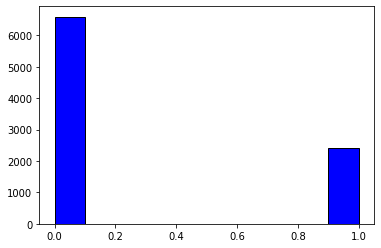

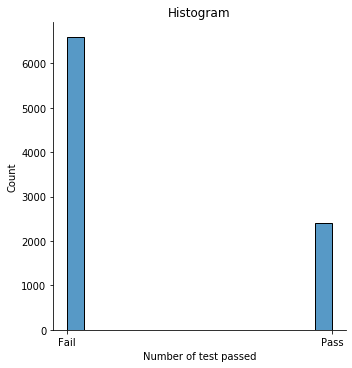

In [47]:
# matplotlib histogram

x = ["Pass","Fail"]

cnt = train_df['isPass'].value_counts()

plt.hist(train_df['isPass'], color = ['blue'], edgecolor = 'black')

# seaborn histogram
sns.displot(train_df['isPass'], kde=False)

plt.xticks(np.arange(0, 2, 1))
positions = (0, 1)
labels = ("Fail", "Pass")
plt.xticks(positions, labels)
# Add labels
plt.title('Histogram')
plt.xlabel('Number of test passed')
plt.ylabel('Count')
plt.show()

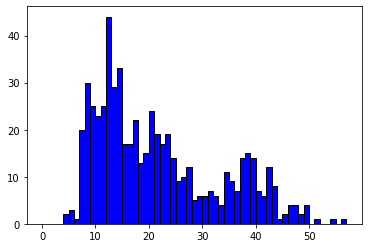

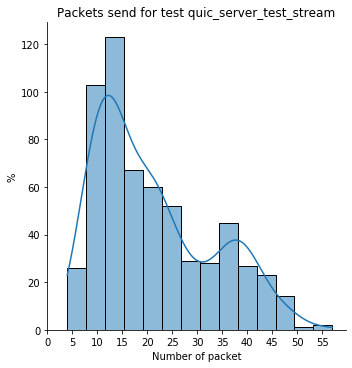

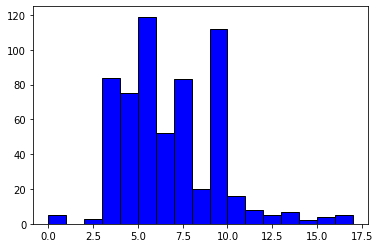

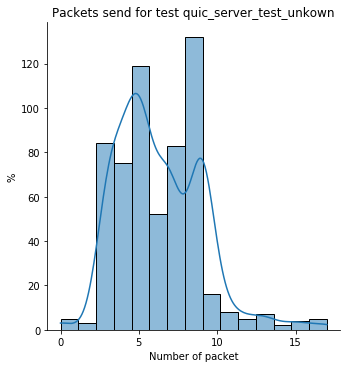

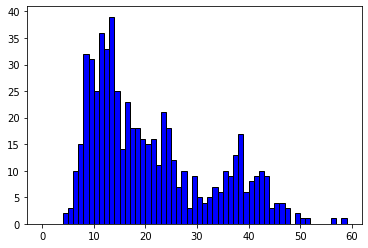

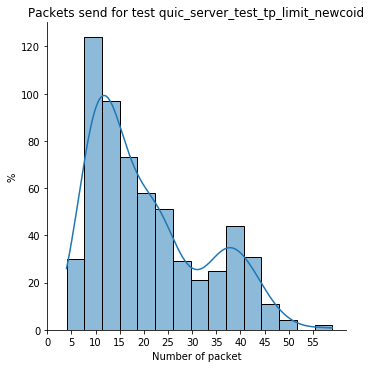

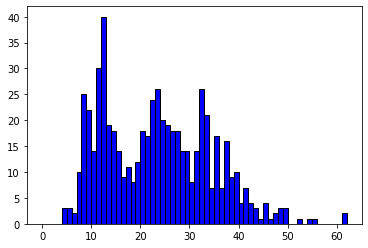

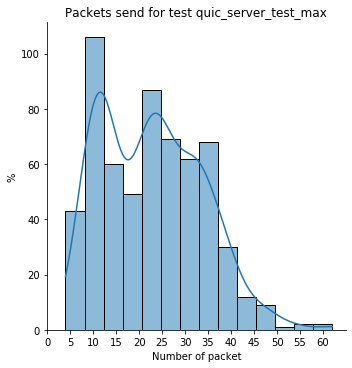

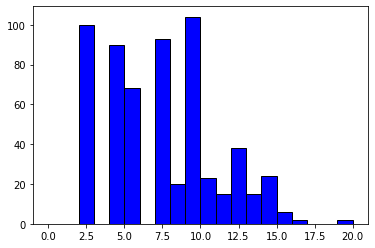

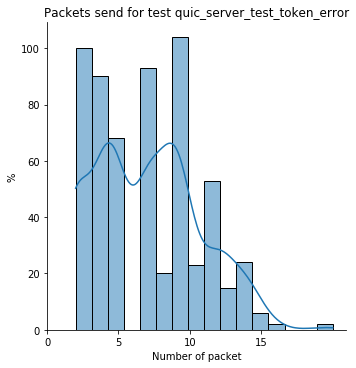

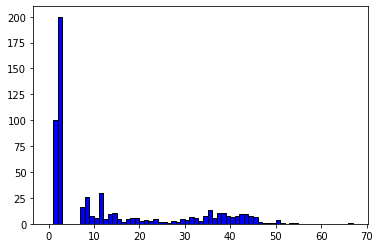

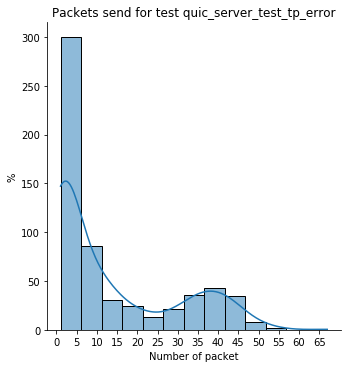

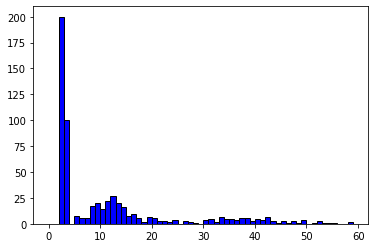

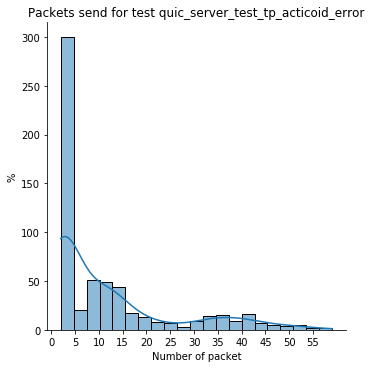

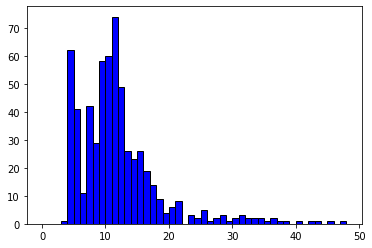

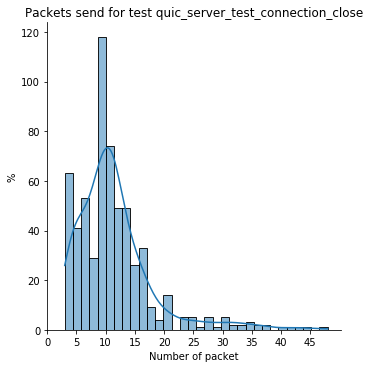

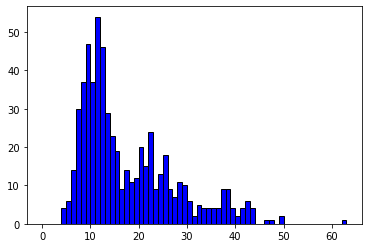

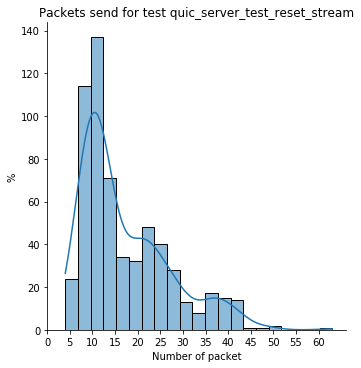

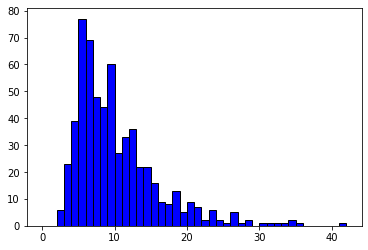

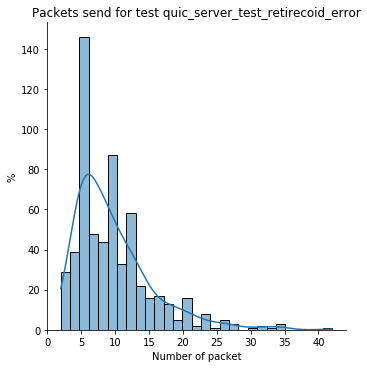

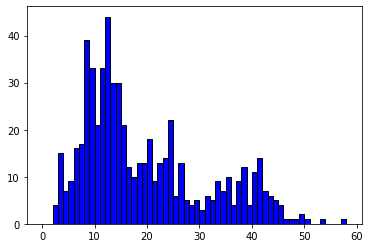

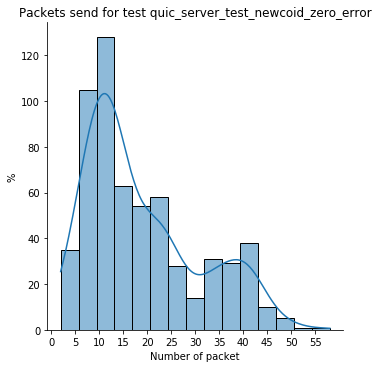

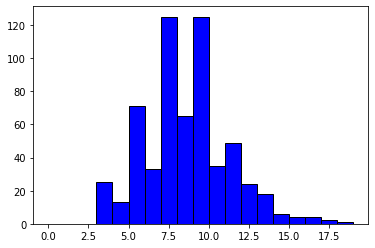

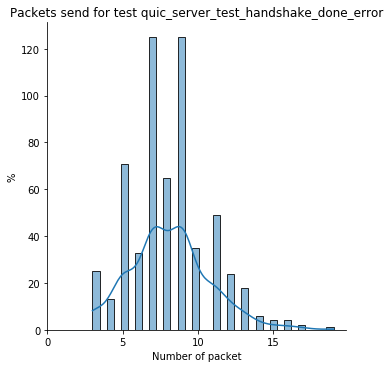

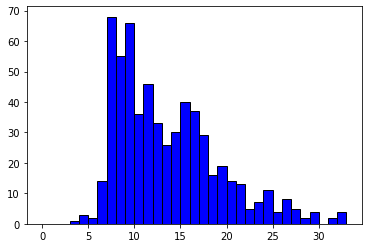

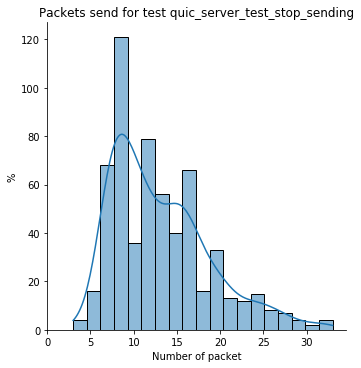

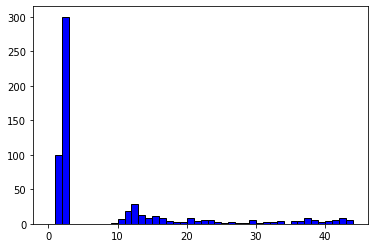

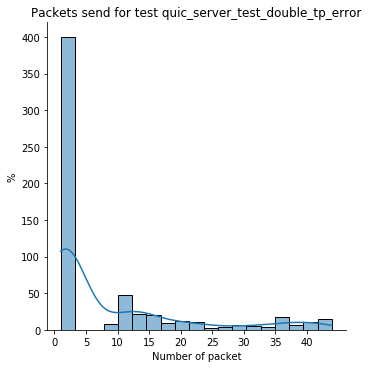

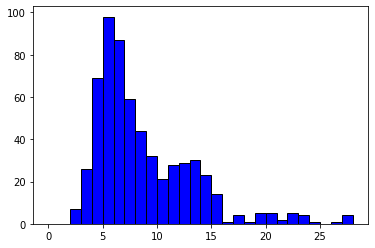

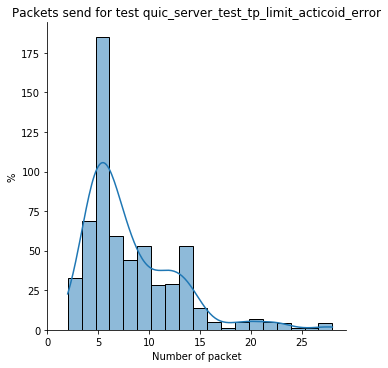

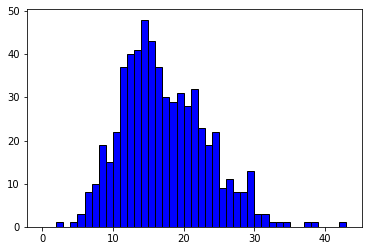

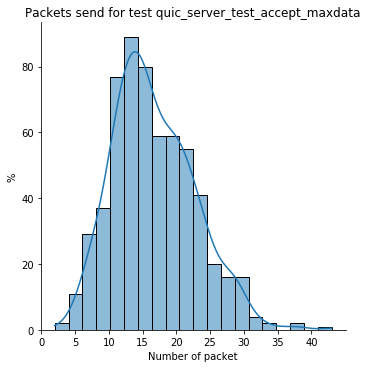

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


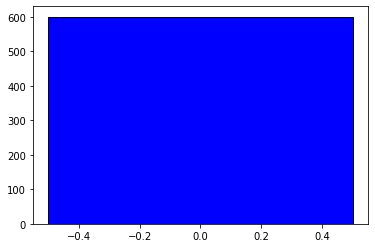

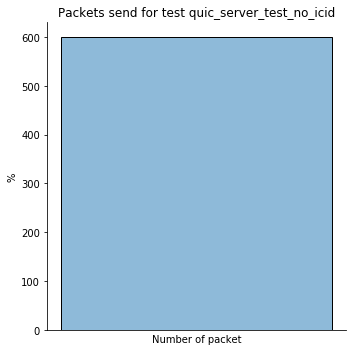

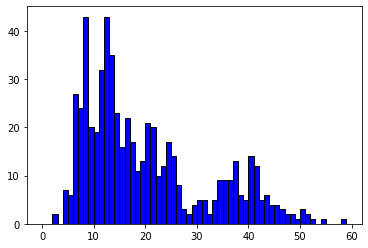

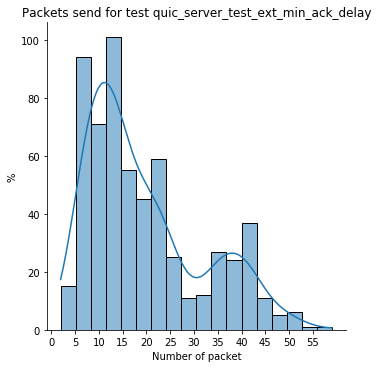

In [28]:
# Failure per test

train_df.TestName.unique()
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_no_icid', 'quic_server_test_ext_min_ack_delay']

#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    #subdf = subdf.loc[subdf['Implementation'] != "quinn"]
    max_value = subdf["NbPktSend"].max() 
    
    plt.hist(subdf['NbPktSend'], color = 'blue', edgecolor = 'black',
             range = [0,max_value],bins=max(int(max_value),1))

    # seaborn histogram
    sns.displot(subdf['NbPktSend'],
                 kde=True)
    # Add labels
    plt.xticks(np.arange(0, int(max_value),5))
    # positions = (0, 1)
    # labels = ("Fail", "Pass")
    # plt.xticks(positions, labels)
    plt.title("Packets send for test " + t)
    plt.xlabel('Number of packet')
    plt.ylabel('%')
    filename = 'plot/' + "packets_" + t + '.png'
    plt.savefig(filename)
    plt.show()

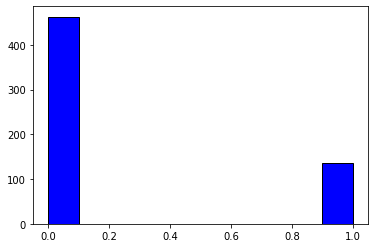

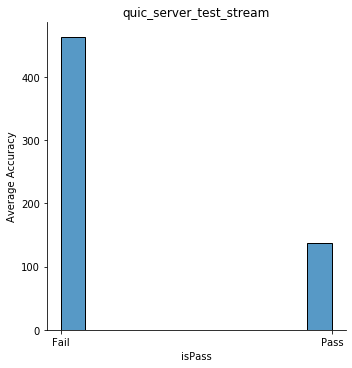

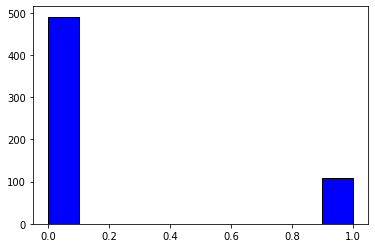

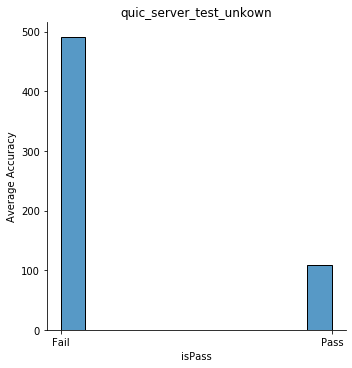

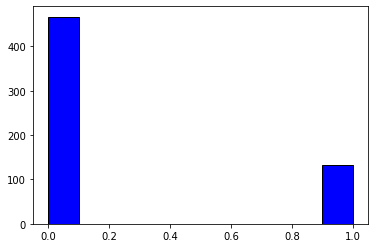

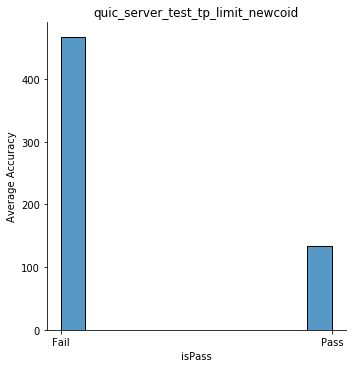

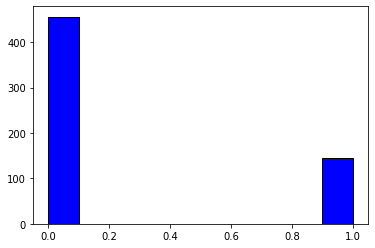

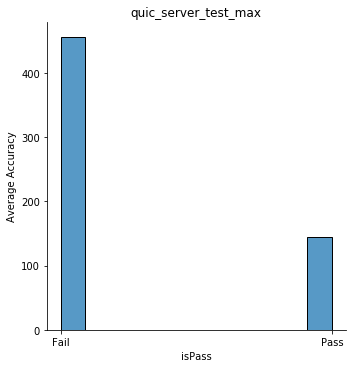

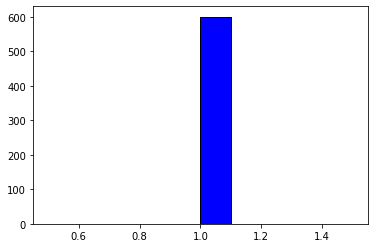

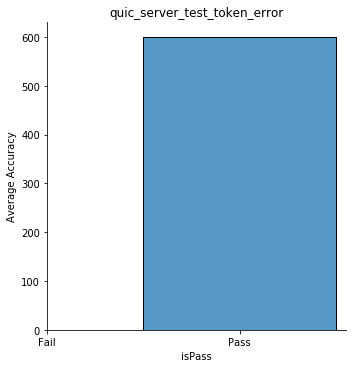

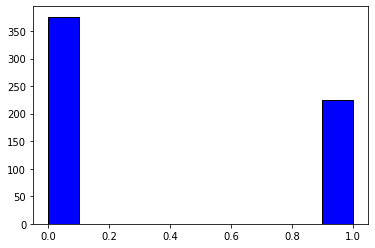

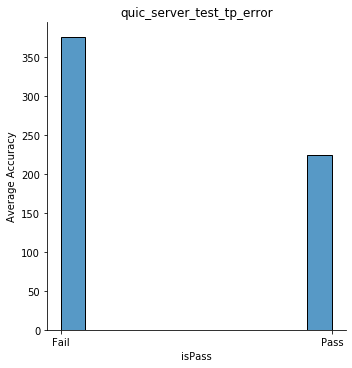

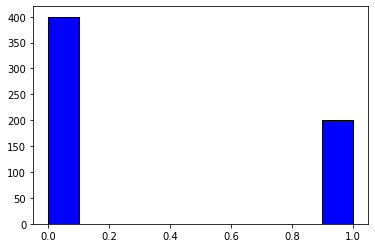

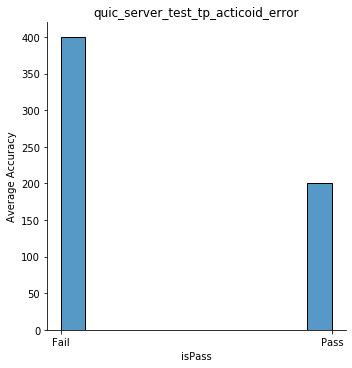

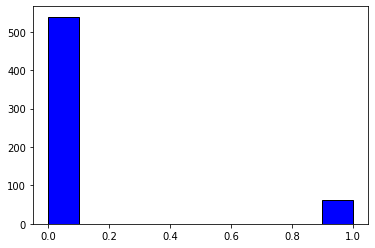

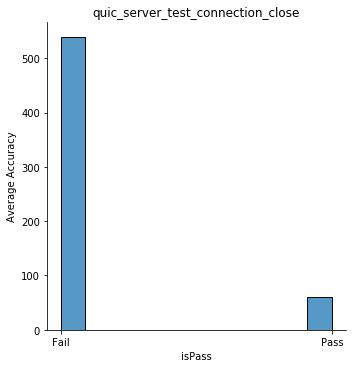

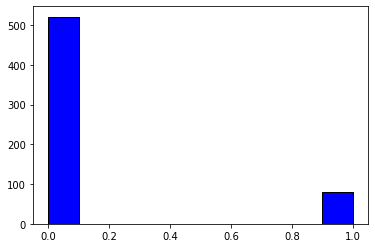

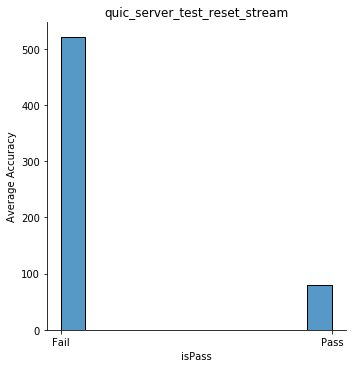

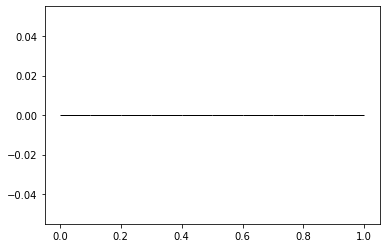

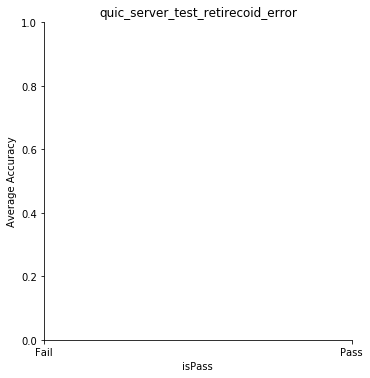

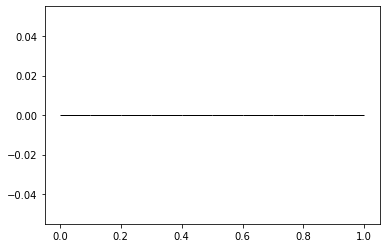

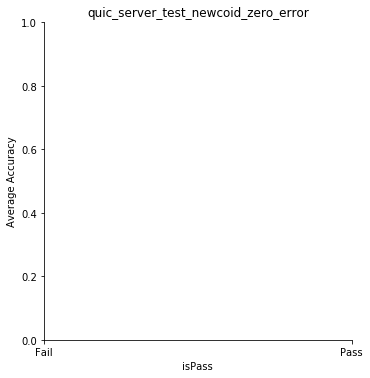

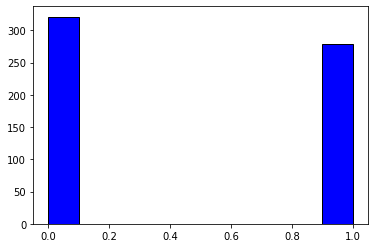

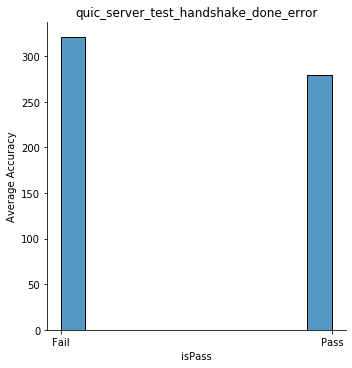

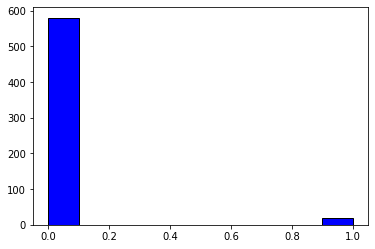

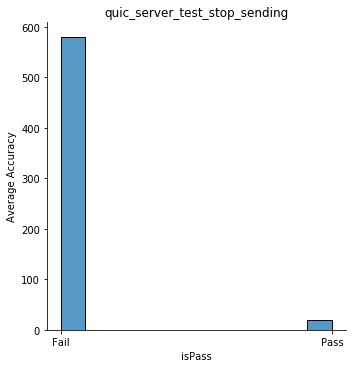

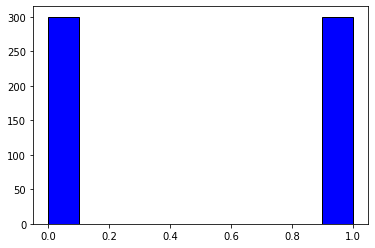

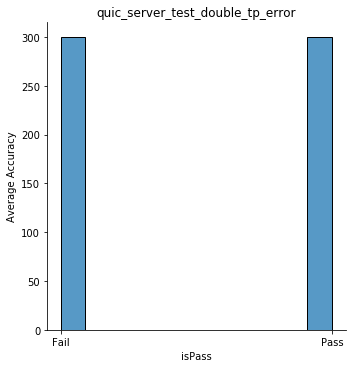

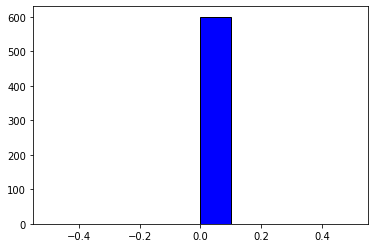

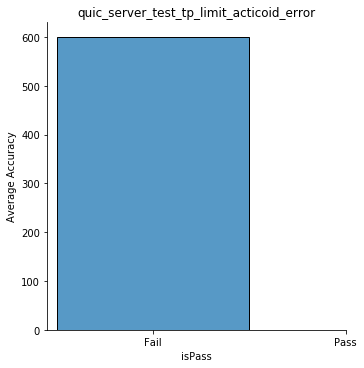

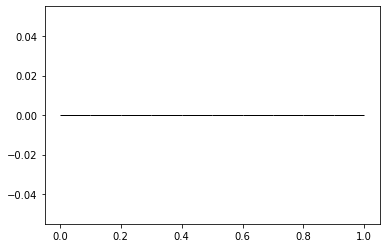

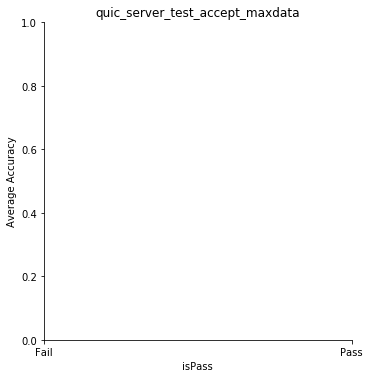

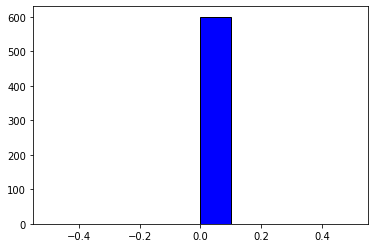

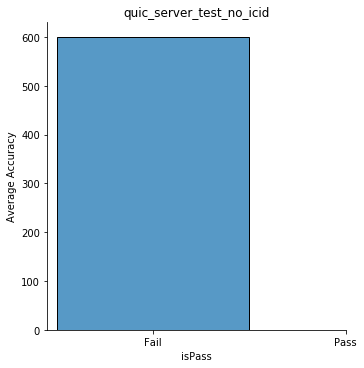

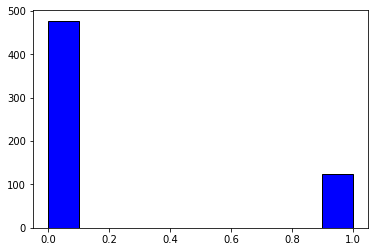

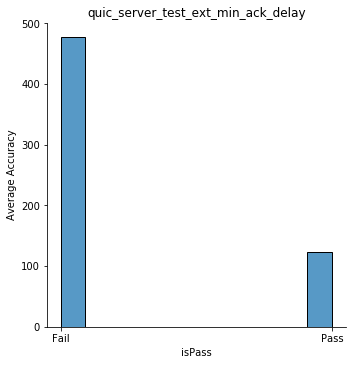

In [49]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('Average Accuracy')
    plt.show()

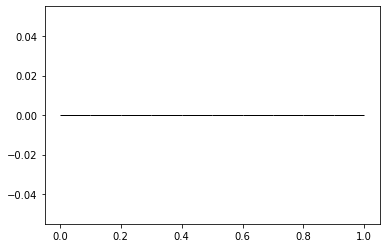

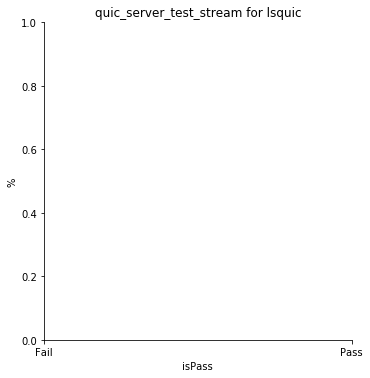

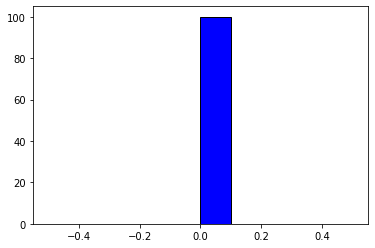

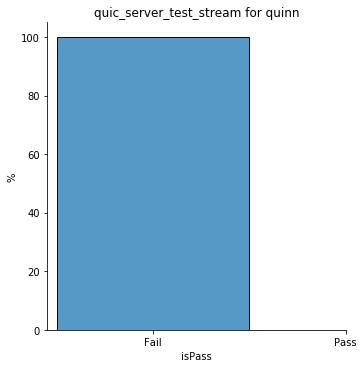

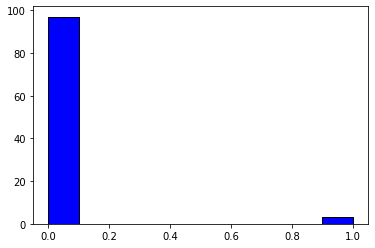

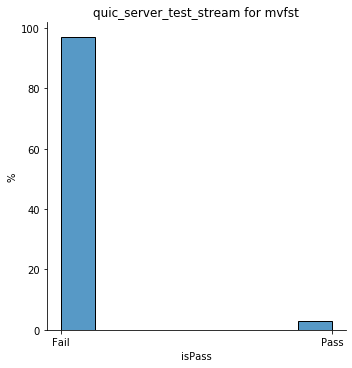

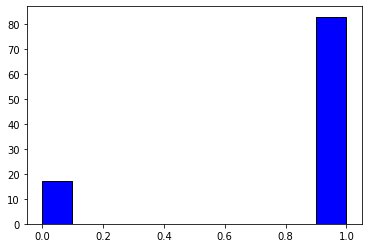

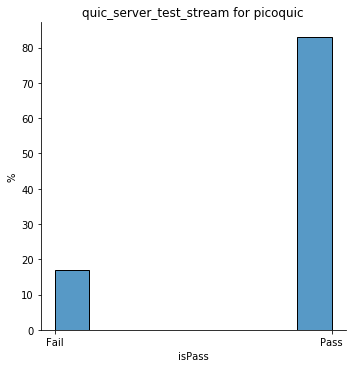

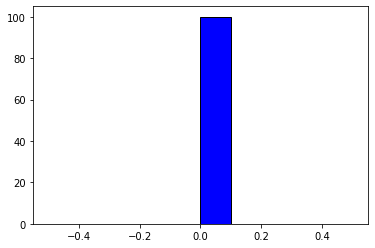

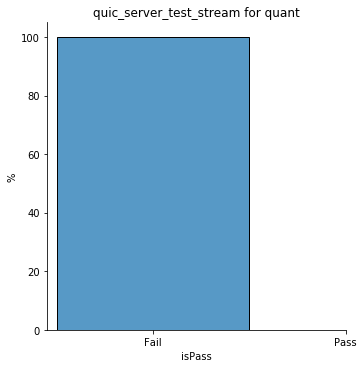

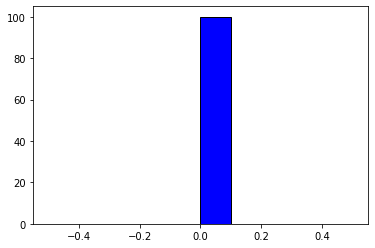

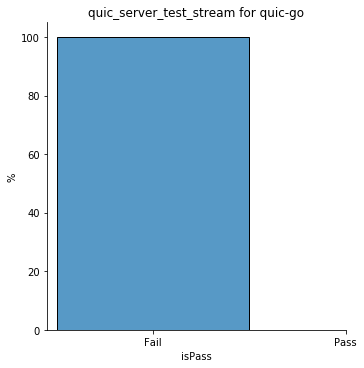

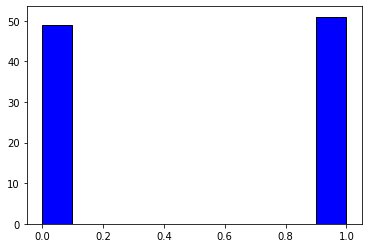

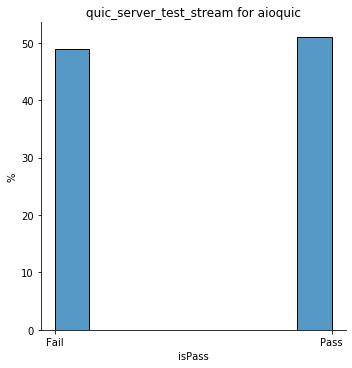

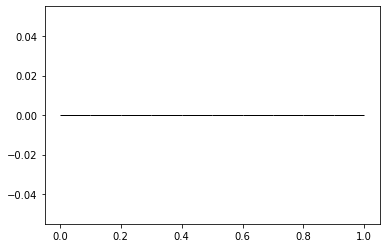

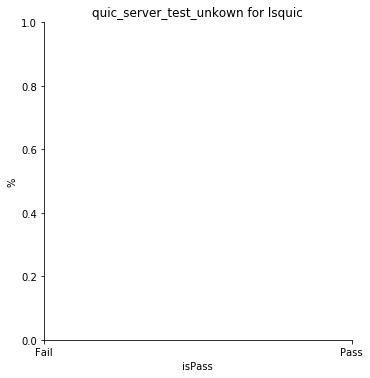

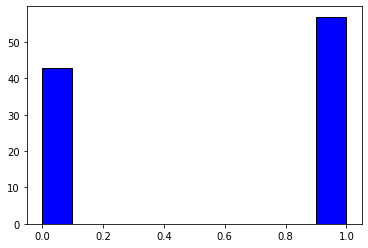

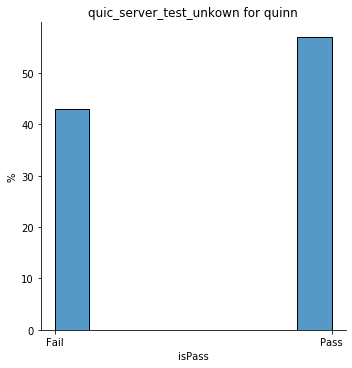

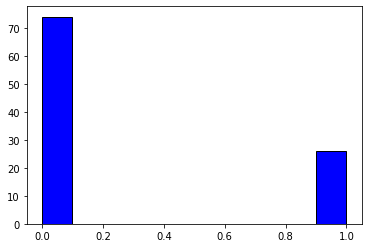

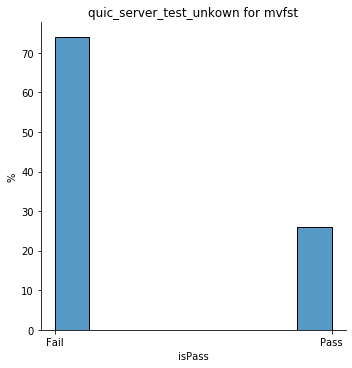

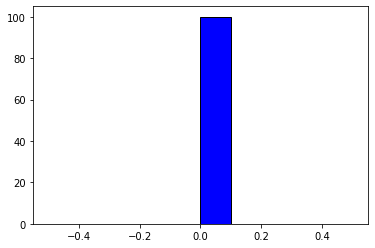

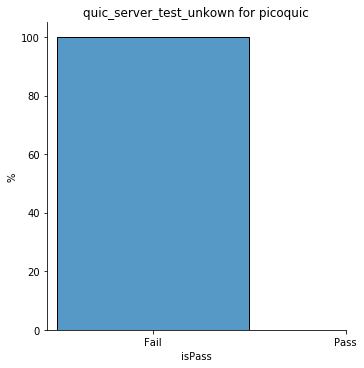

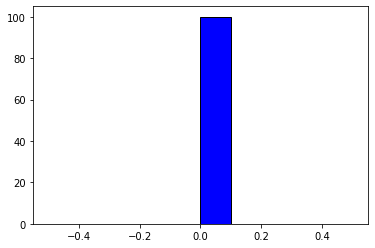

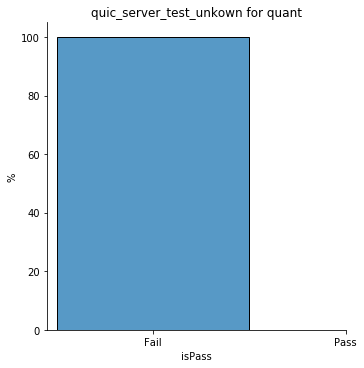

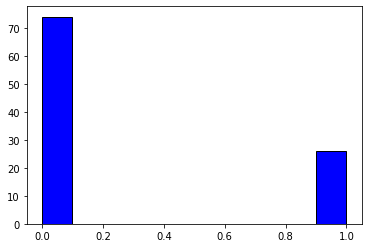

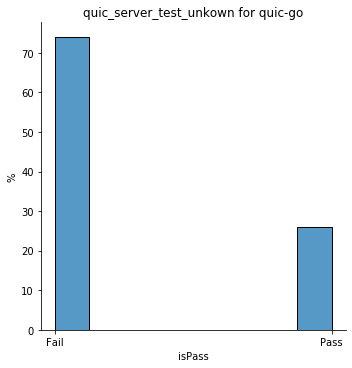

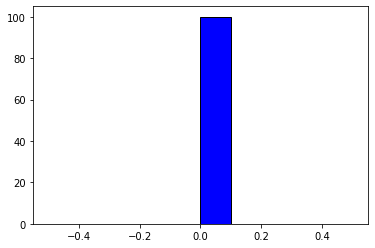

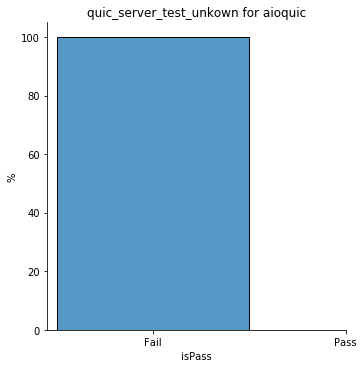

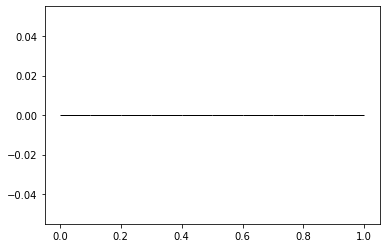

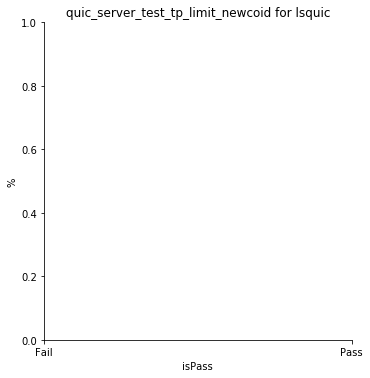

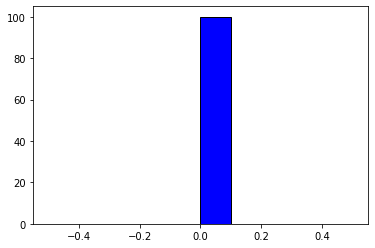

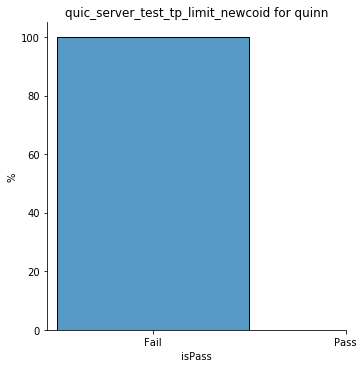

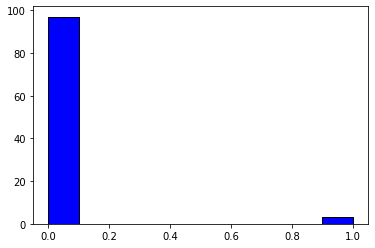

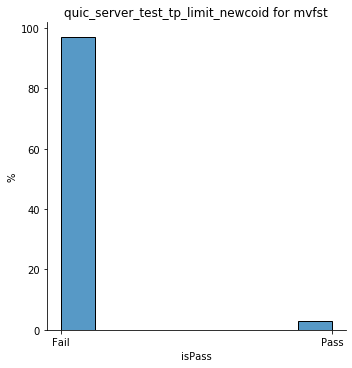

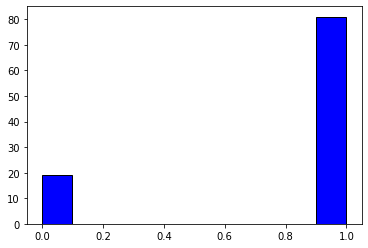

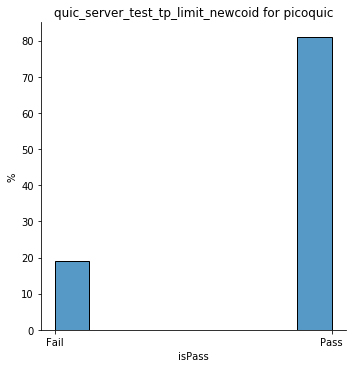

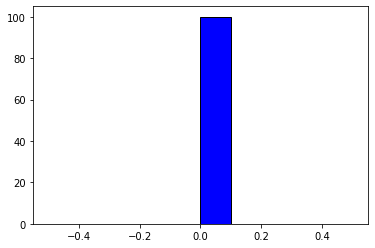

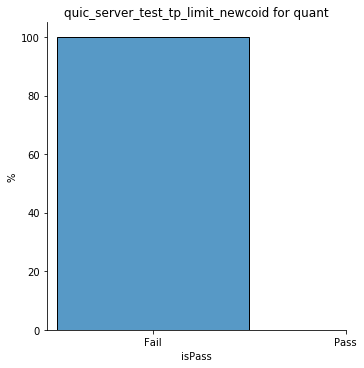

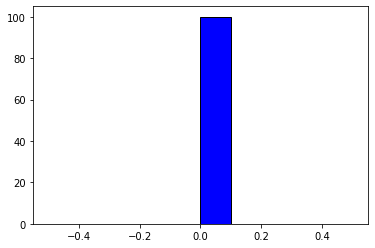

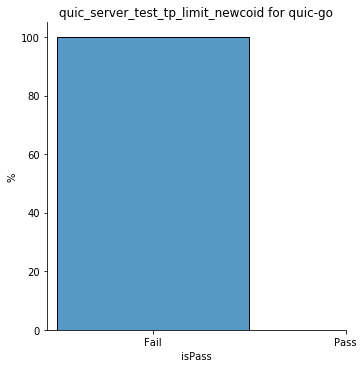

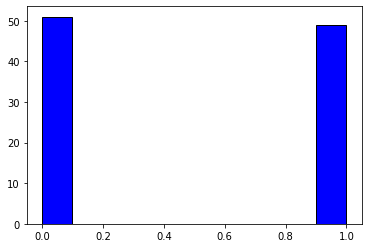

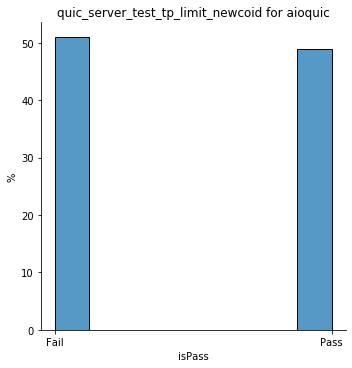

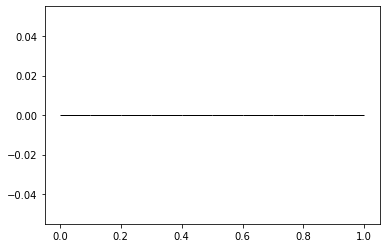

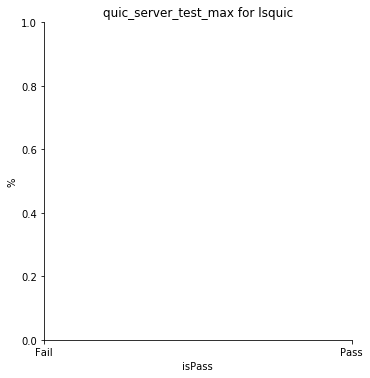

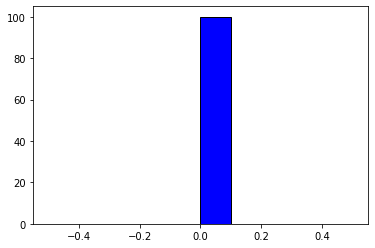

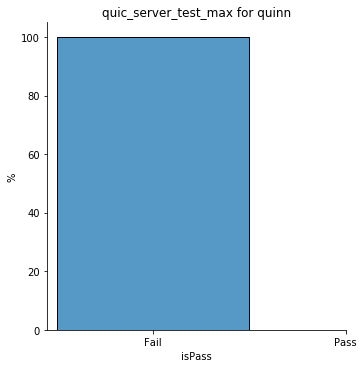

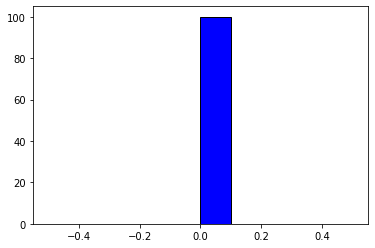

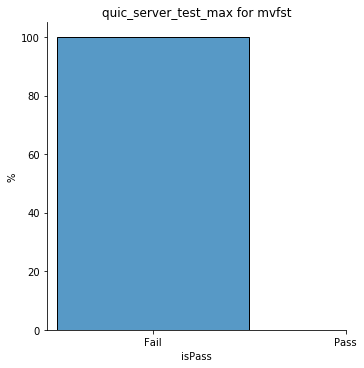

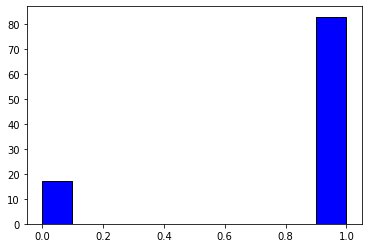

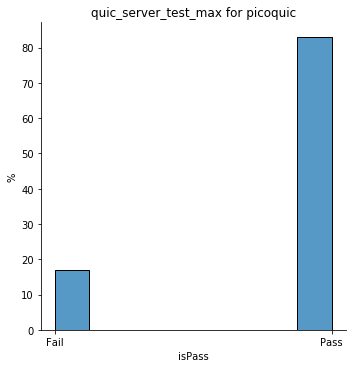

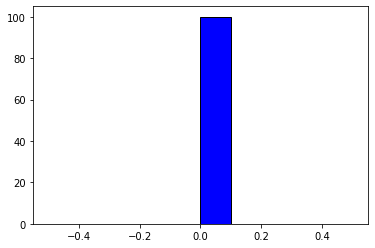

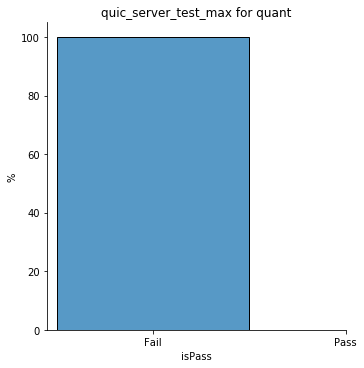

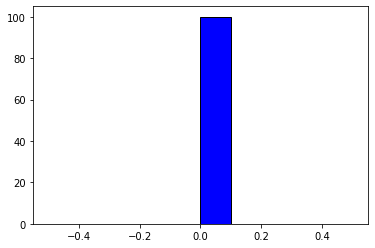

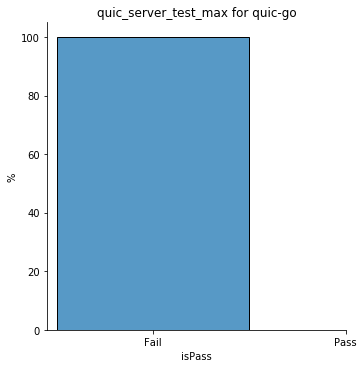

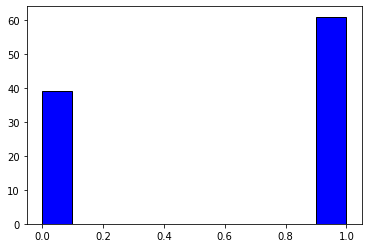

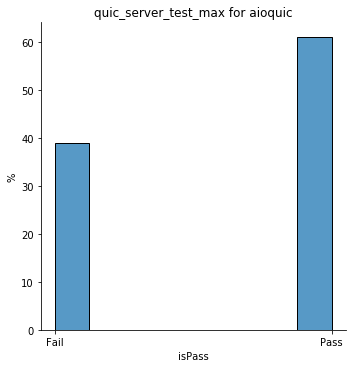

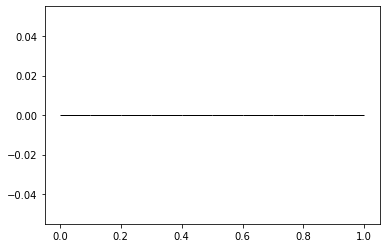

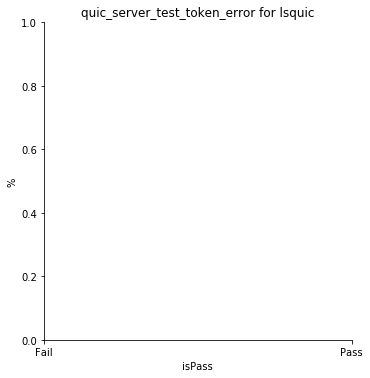

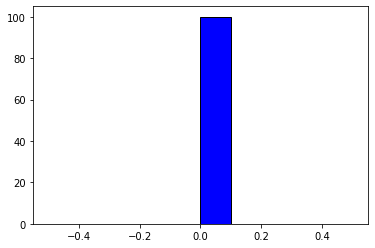

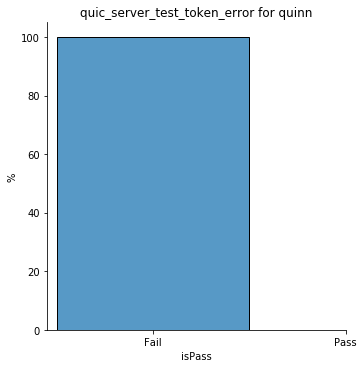

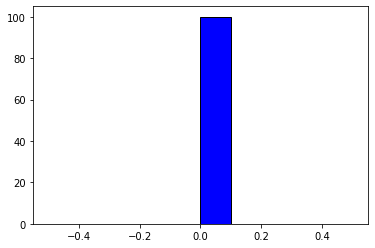

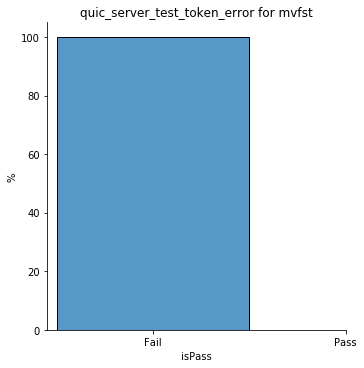

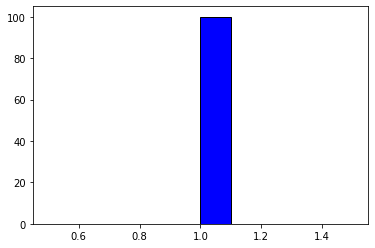

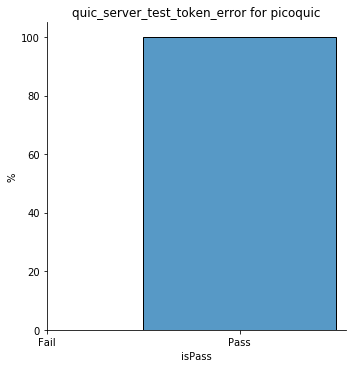

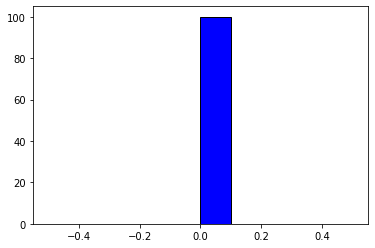

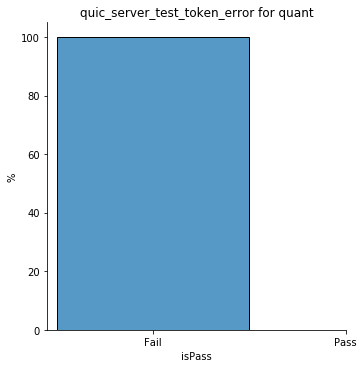

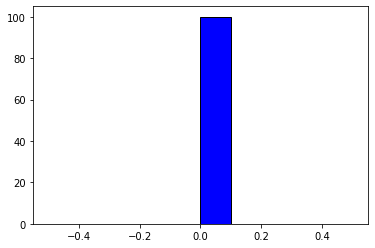

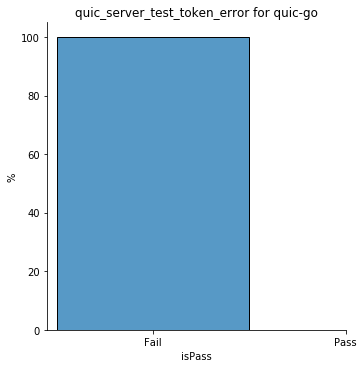

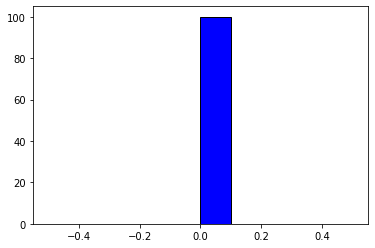

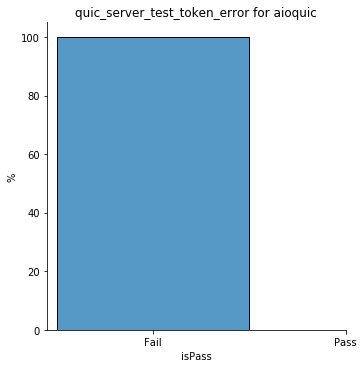

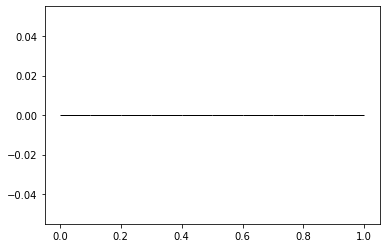

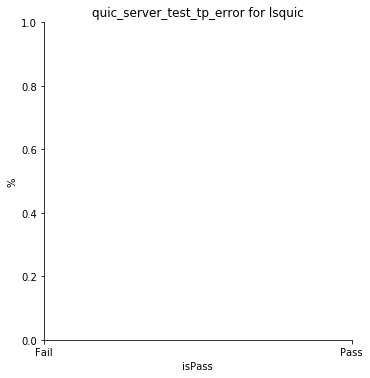

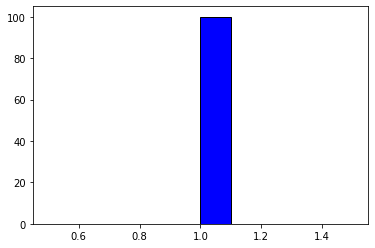

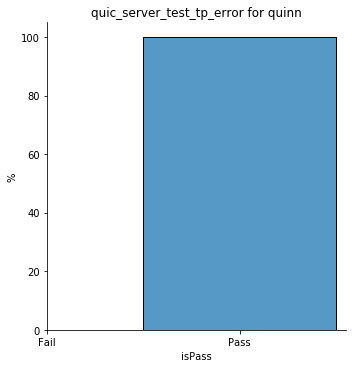

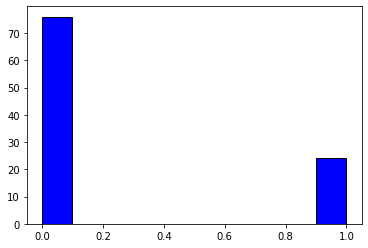

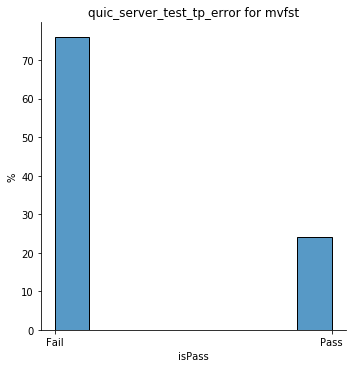

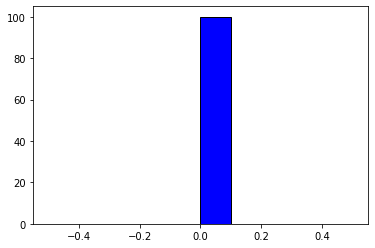

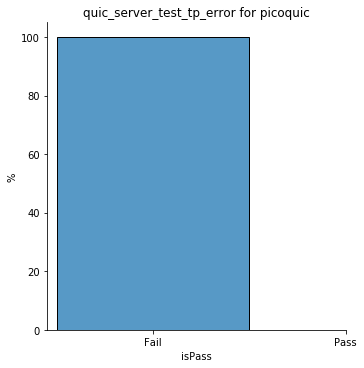

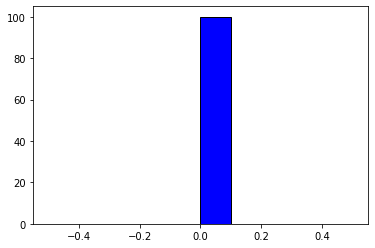

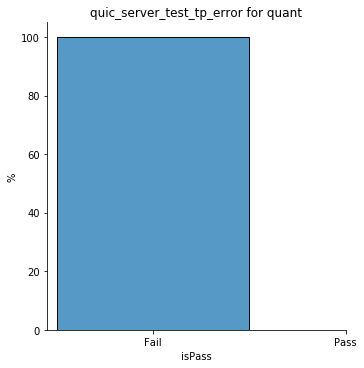

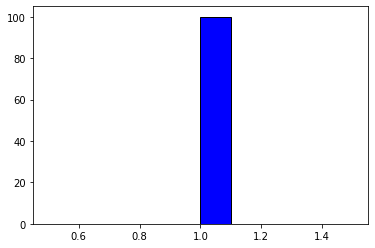

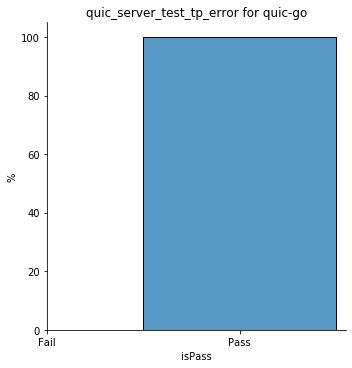

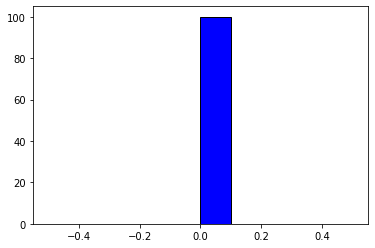

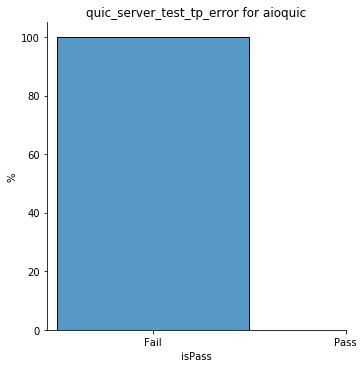

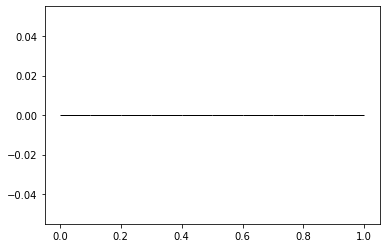

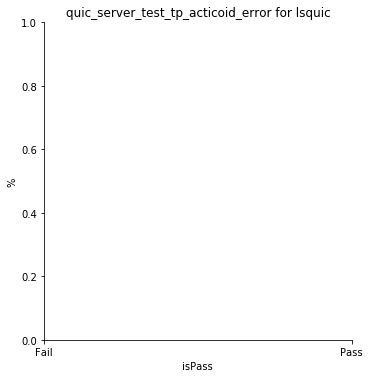

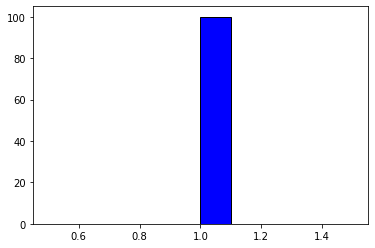

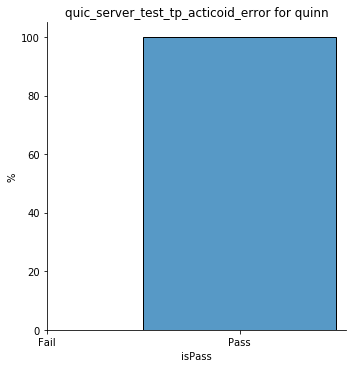

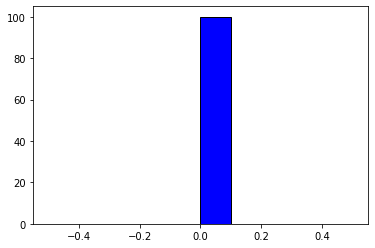

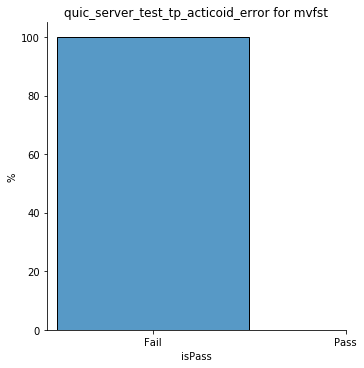

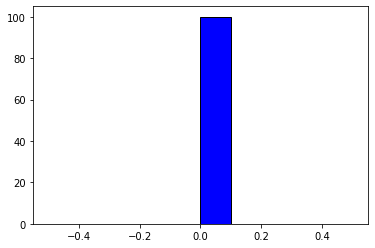

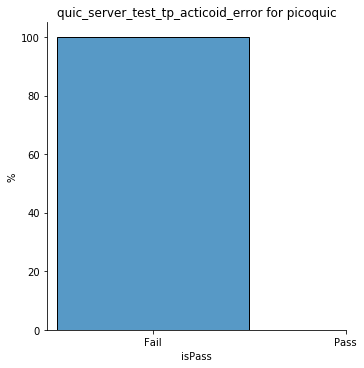

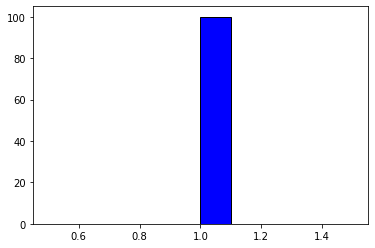

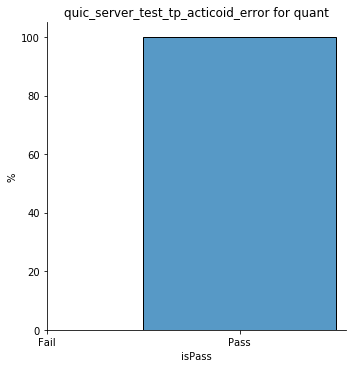

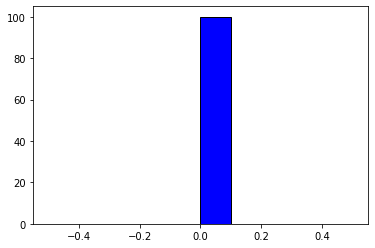

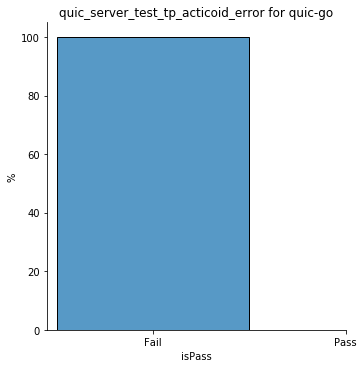

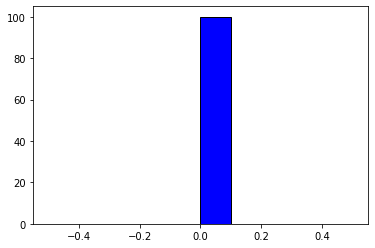

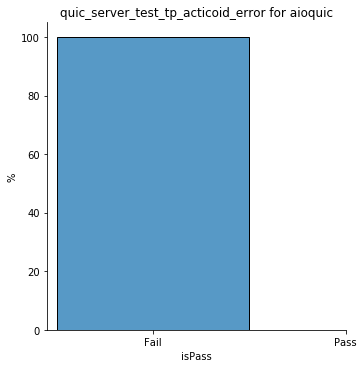

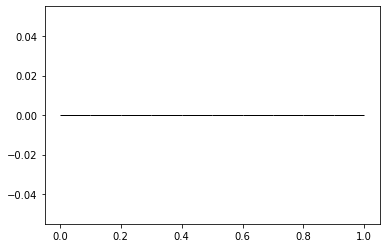

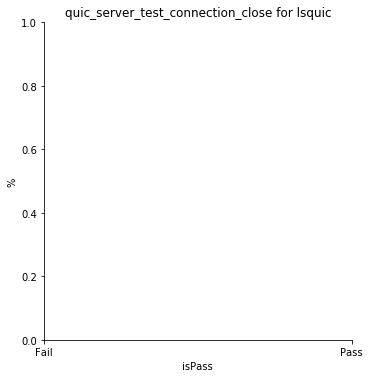

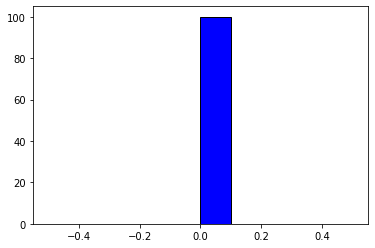

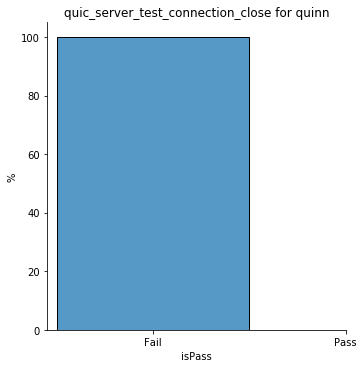

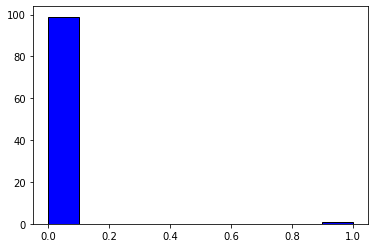

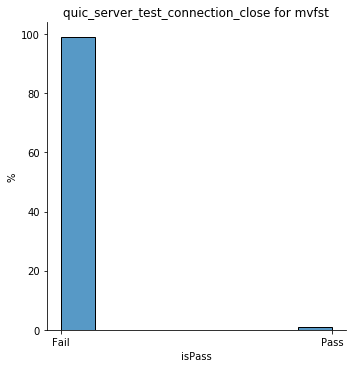

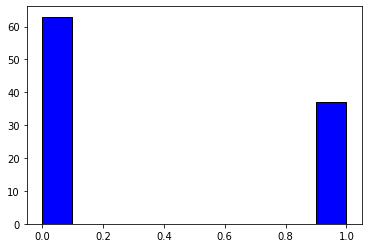

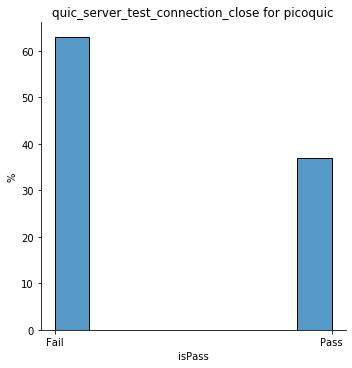

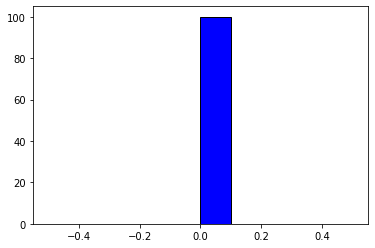

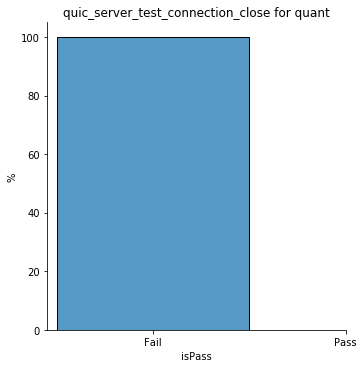

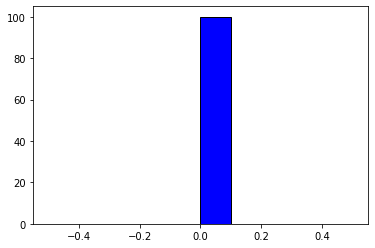

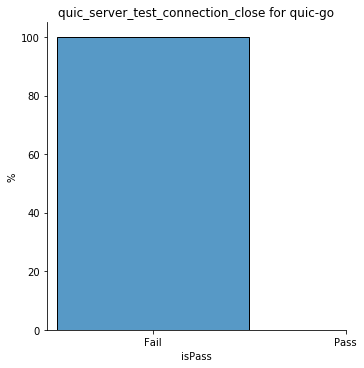

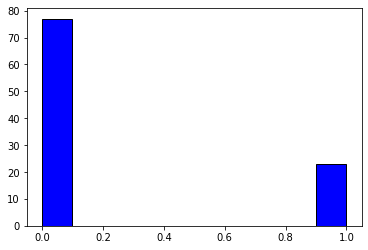

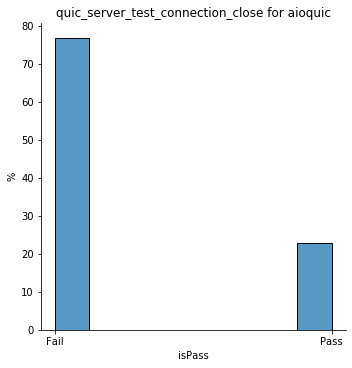

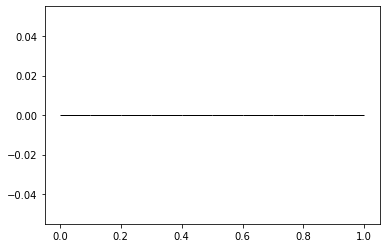

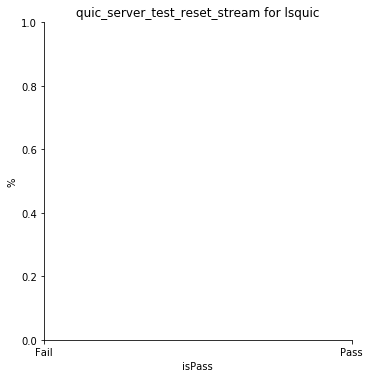

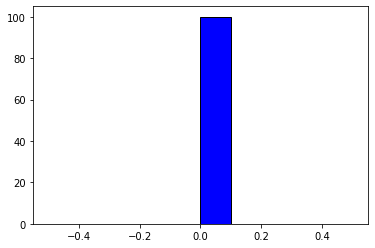

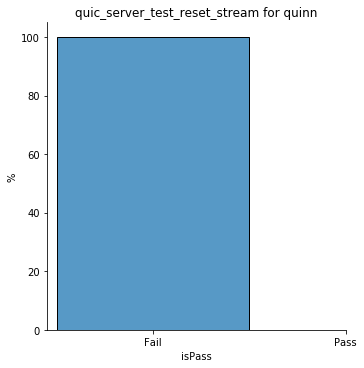

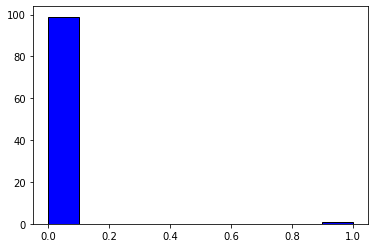

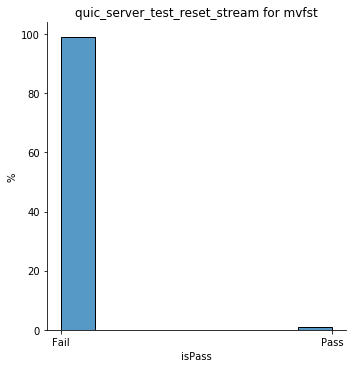

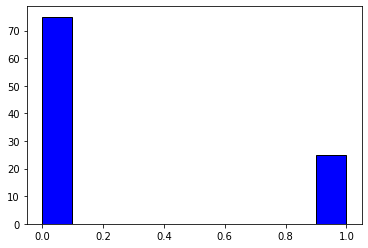

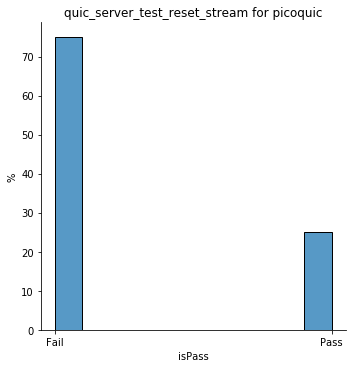

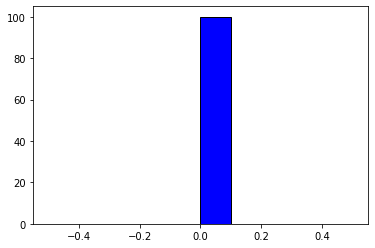

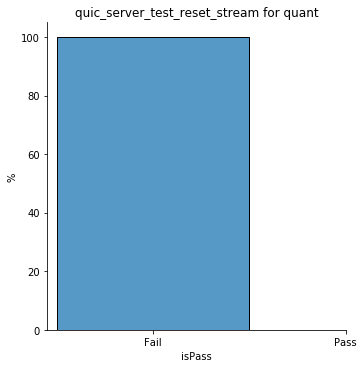

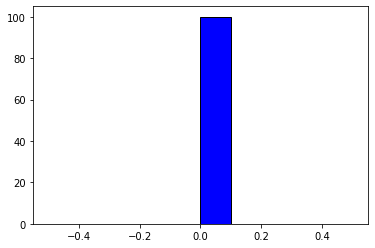

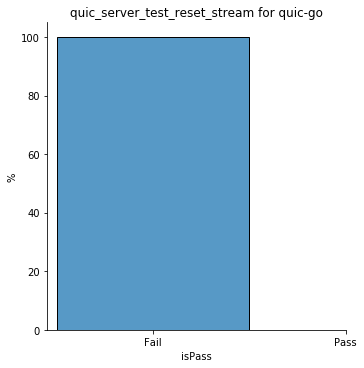

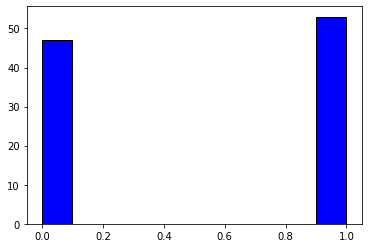

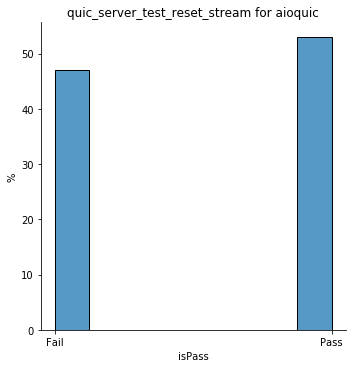

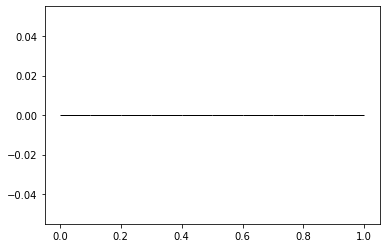

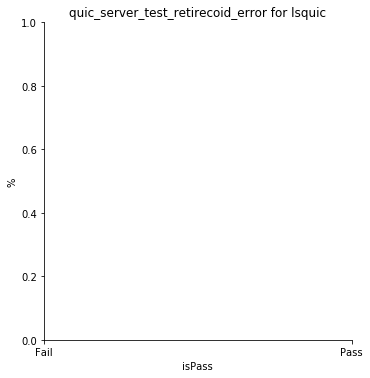

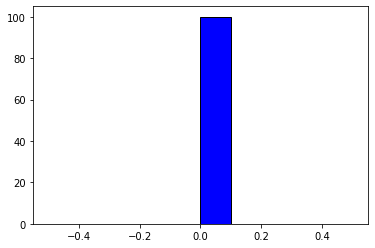

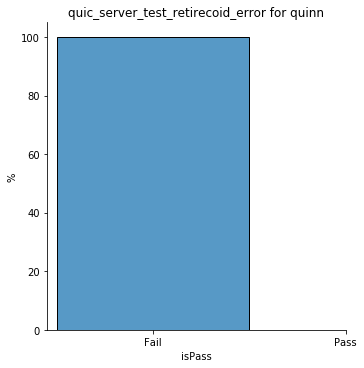

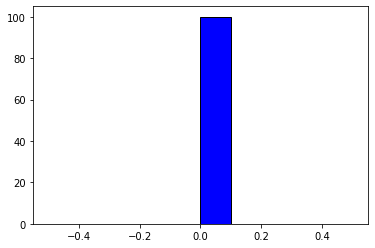

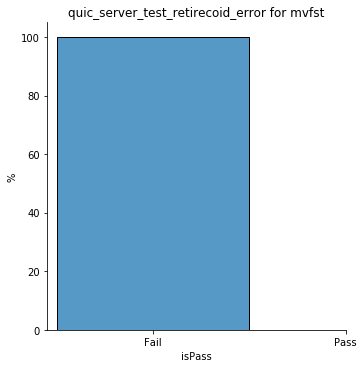

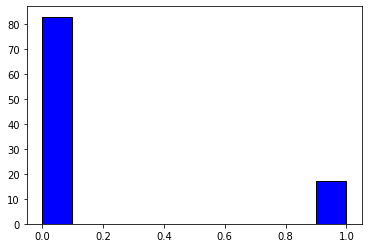

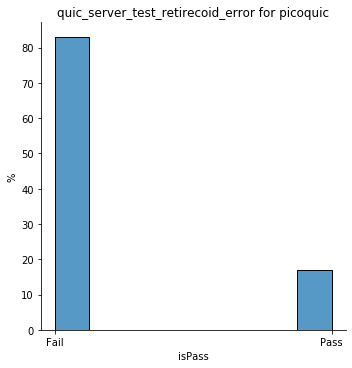

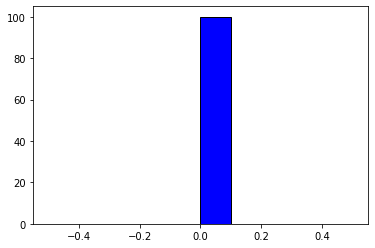

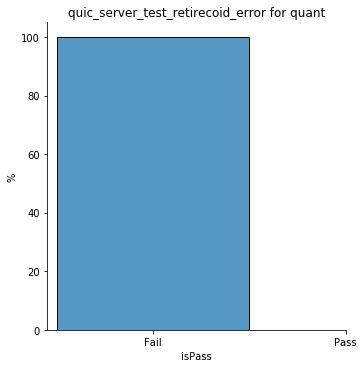

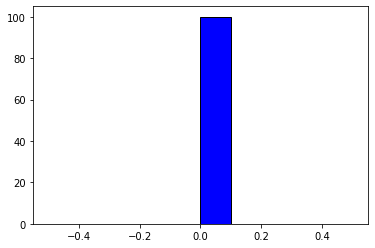

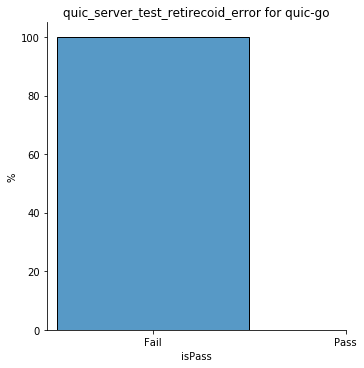

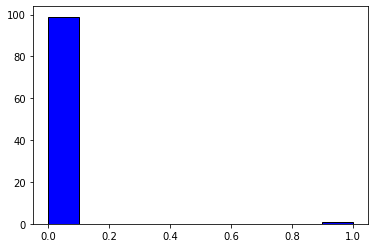

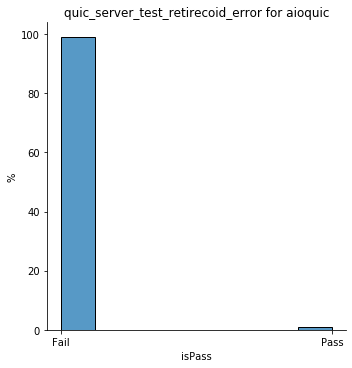

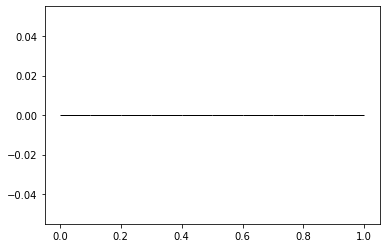

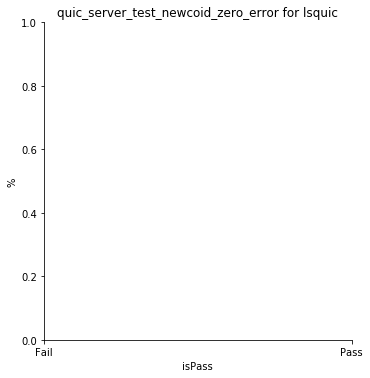

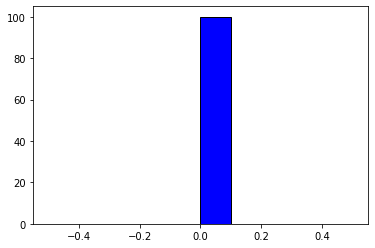

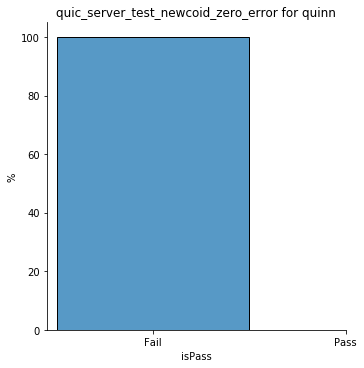

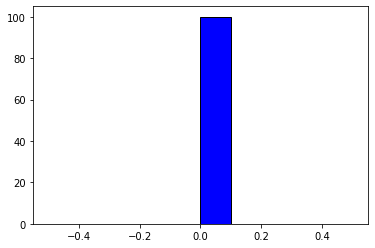

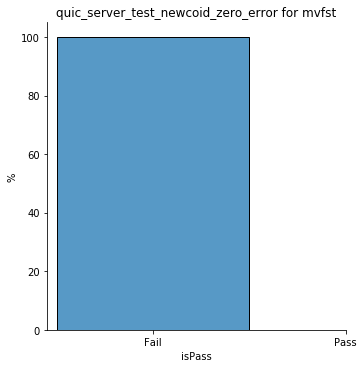

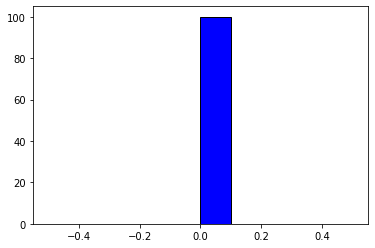

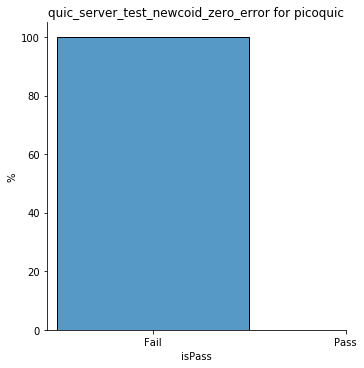

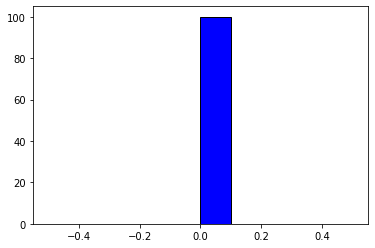

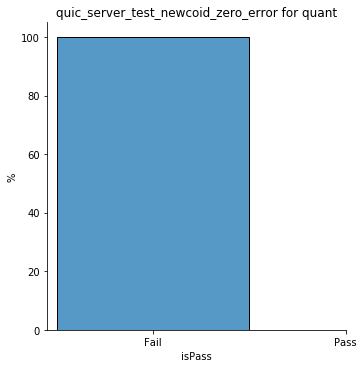

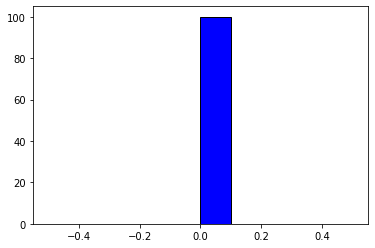

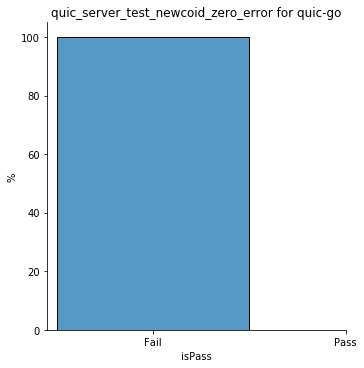

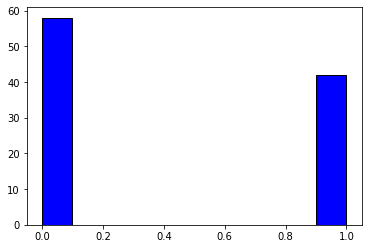

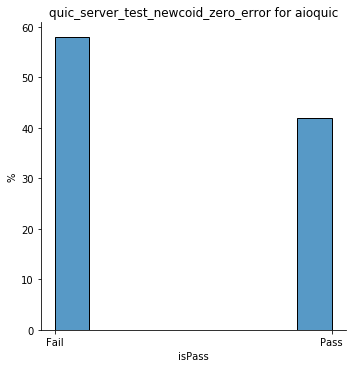

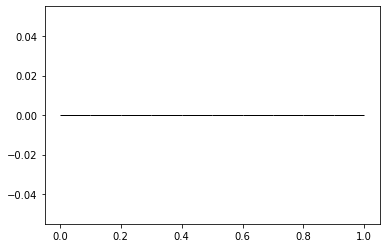

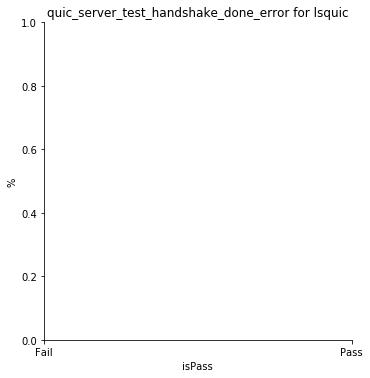

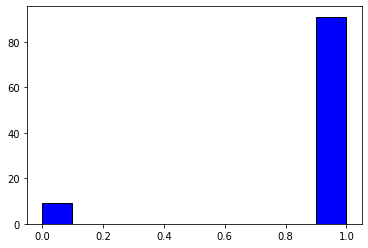

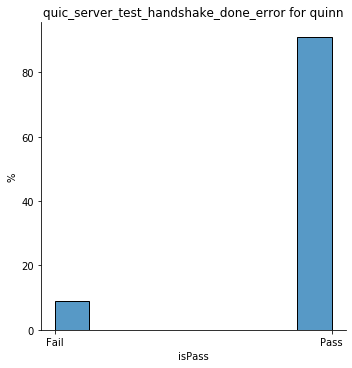

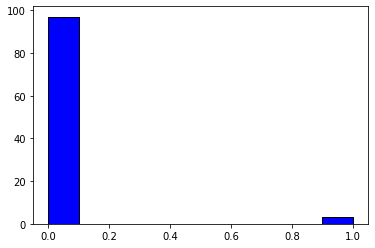

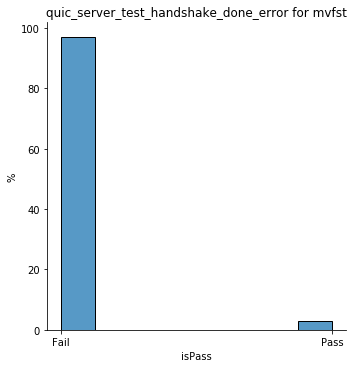

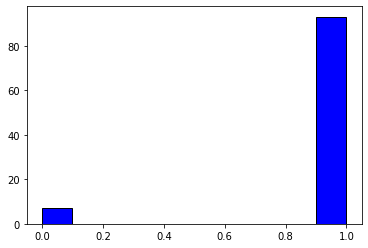

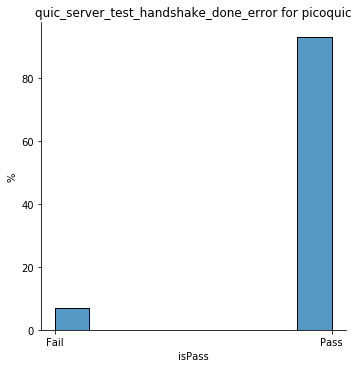

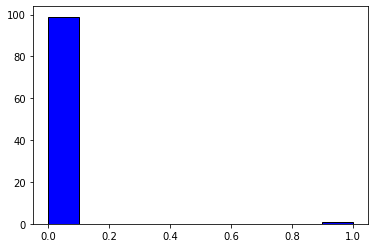

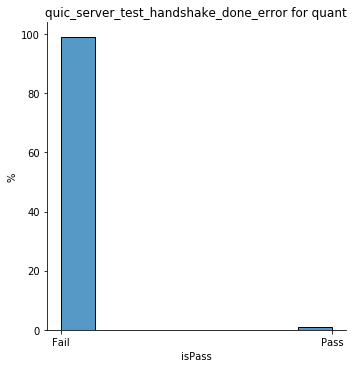

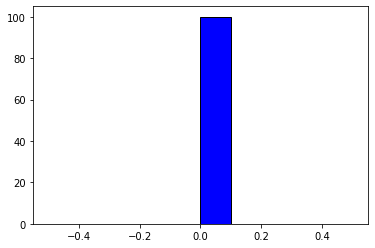

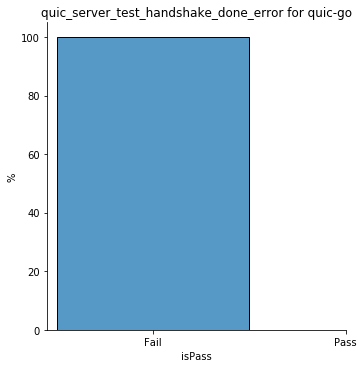

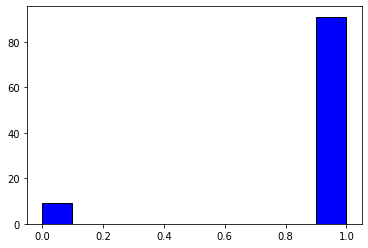

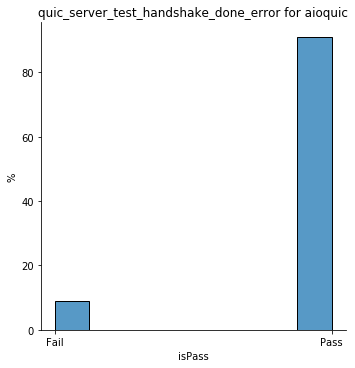

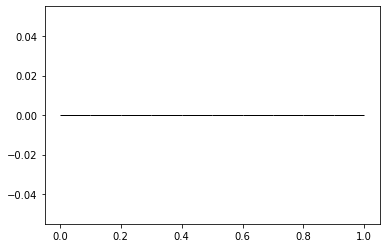

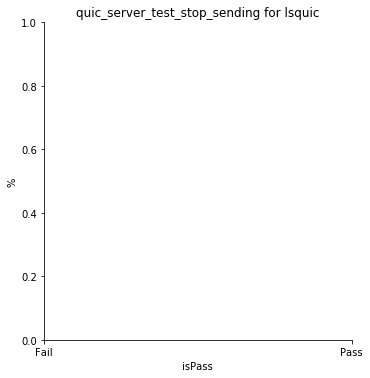

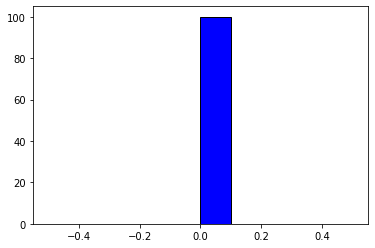

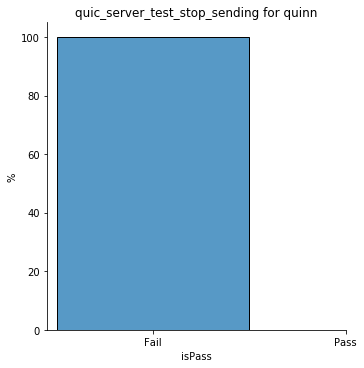

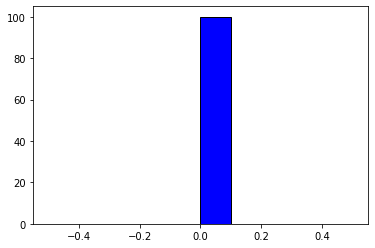

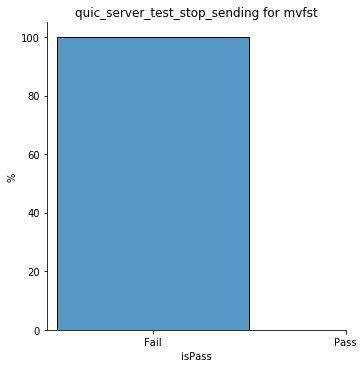

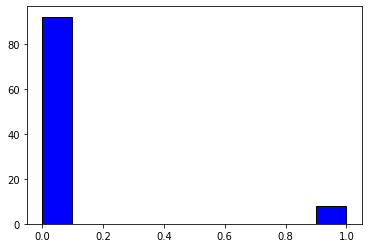

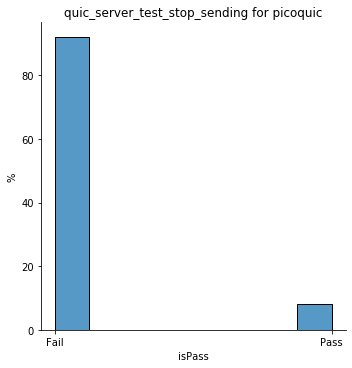

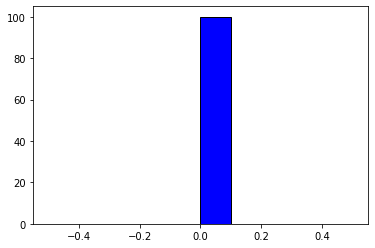

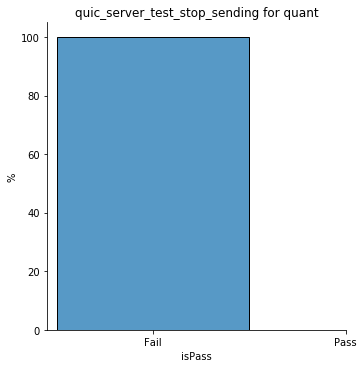

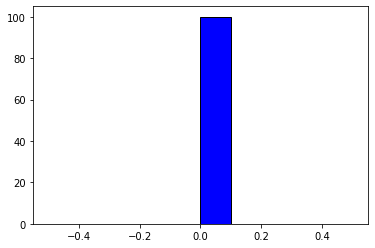

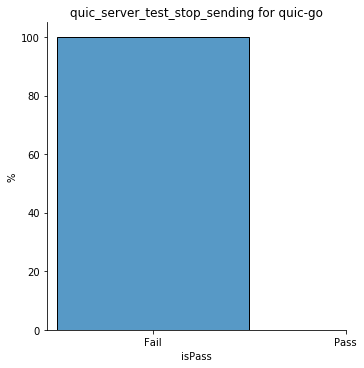

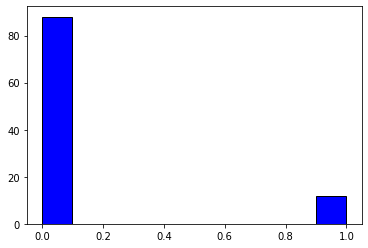

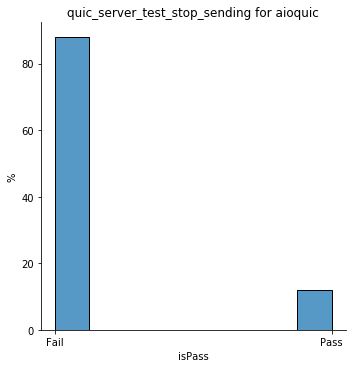

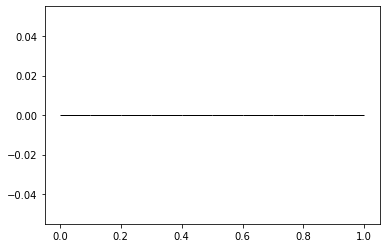

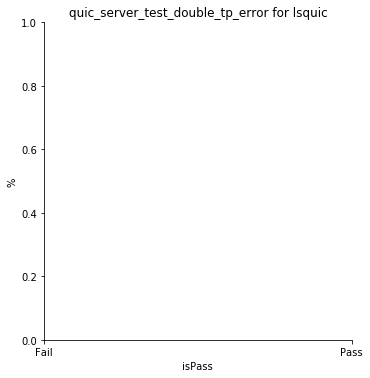

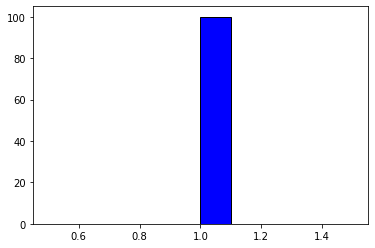

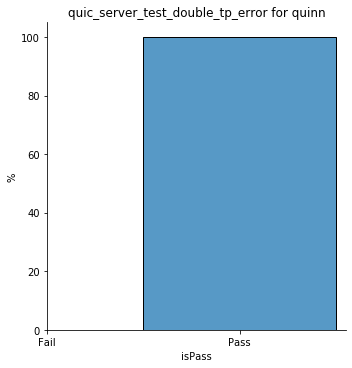

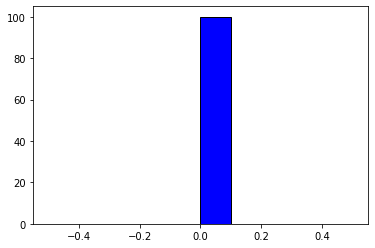

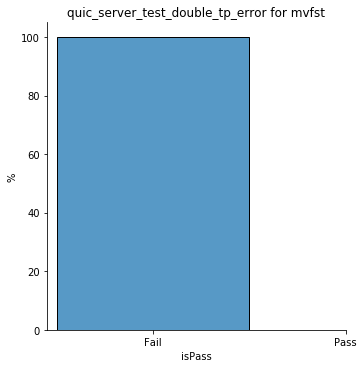

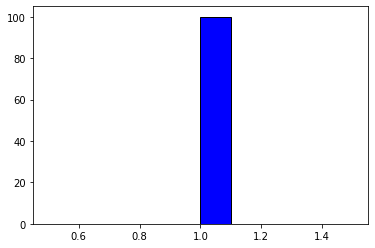

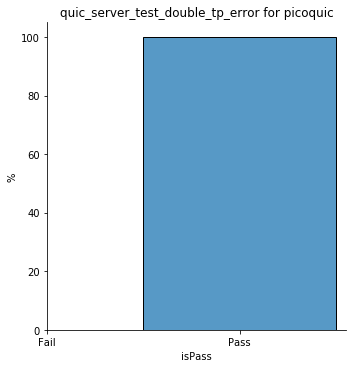

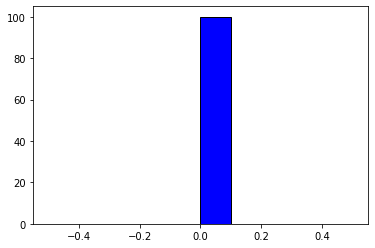

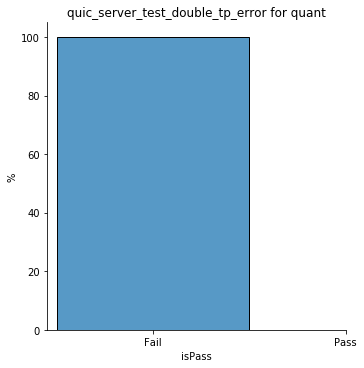

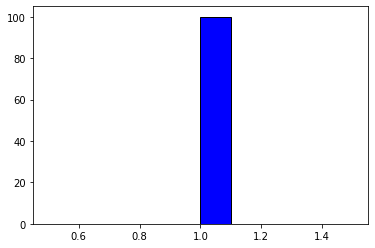

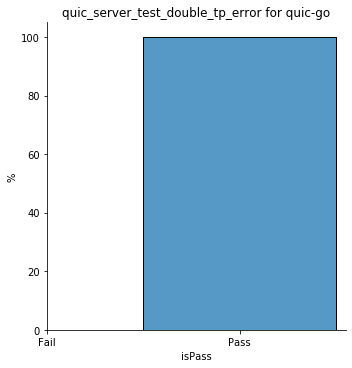

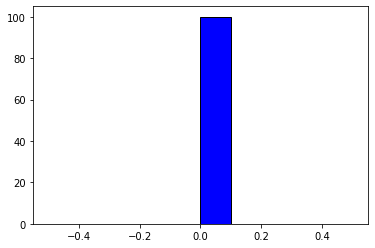

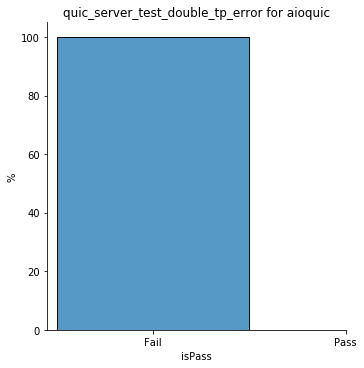

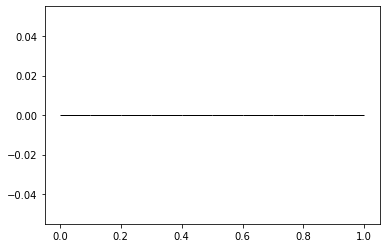

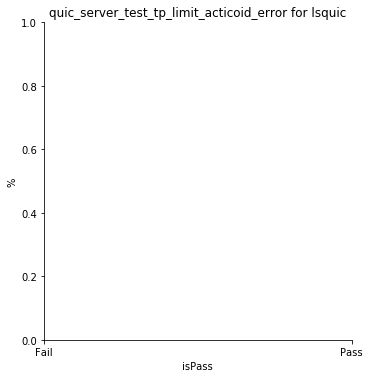

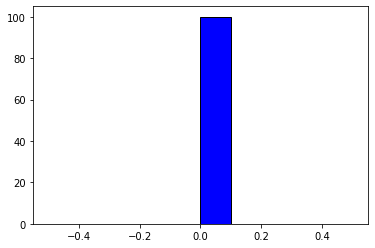

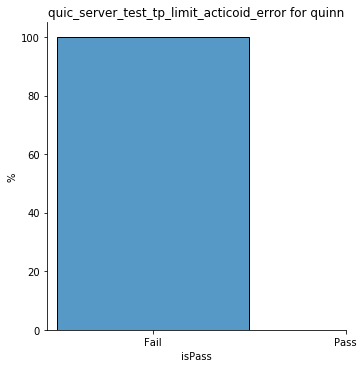

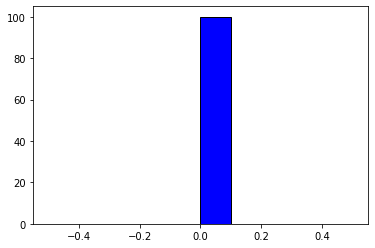

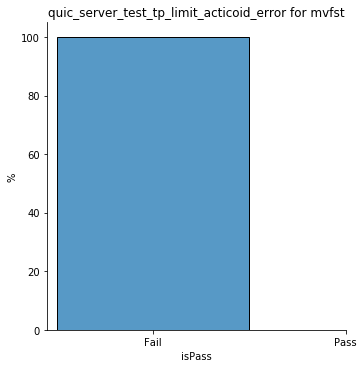

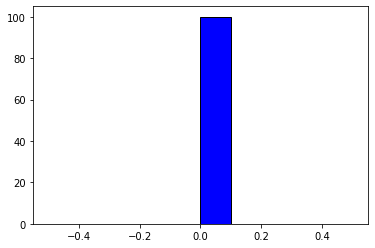

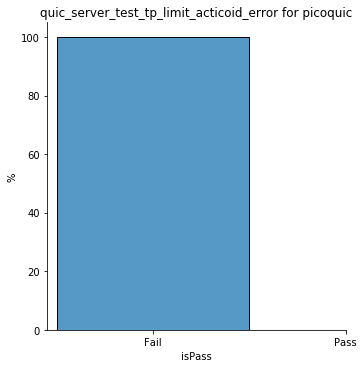

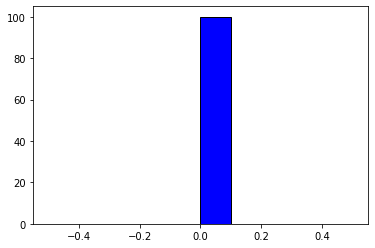

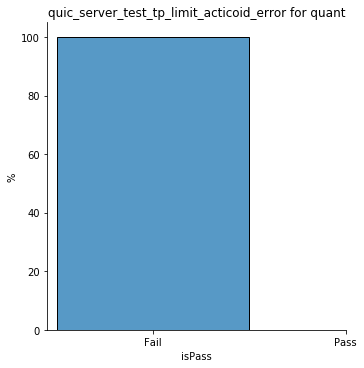

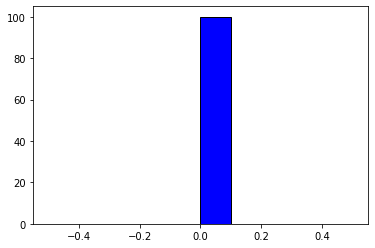

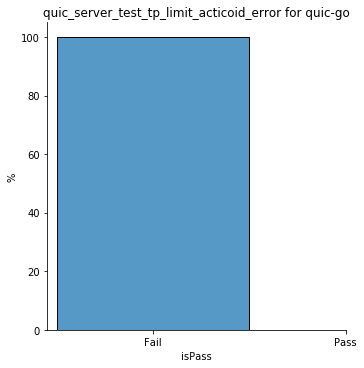

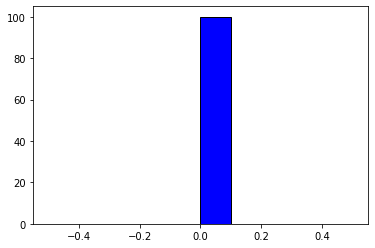

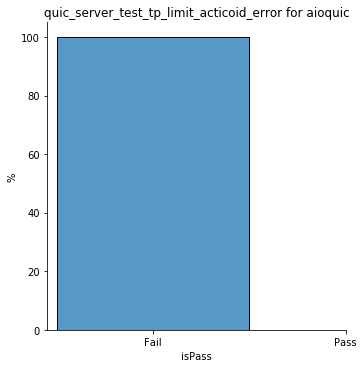

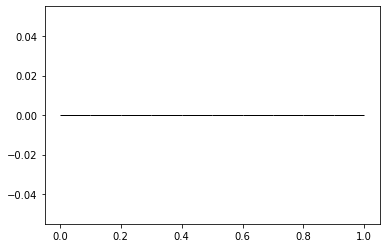

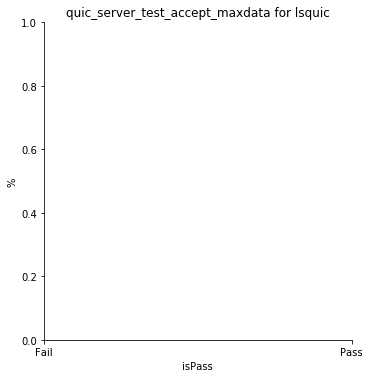

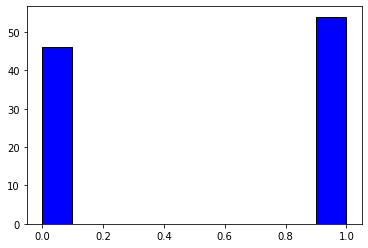

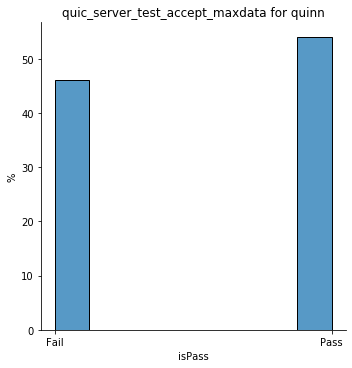

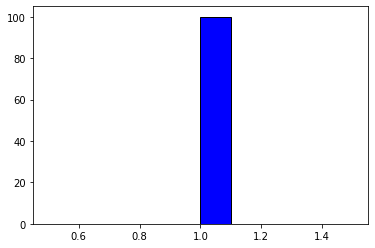

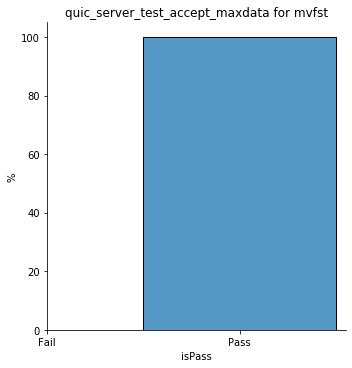

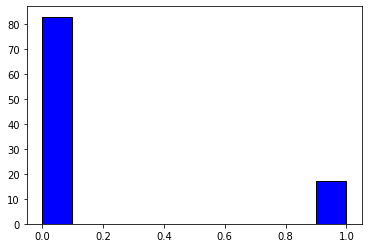

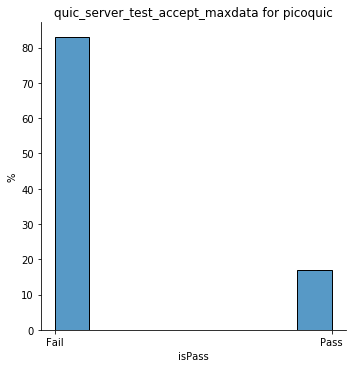

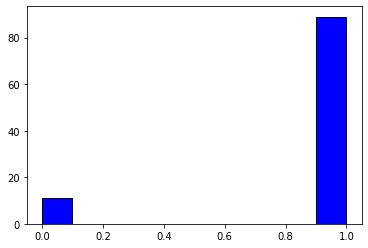

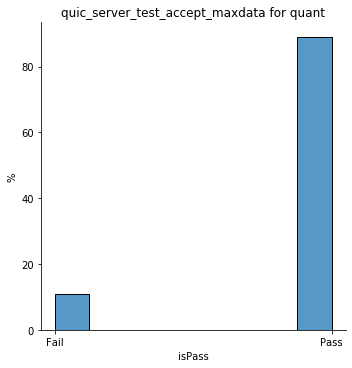

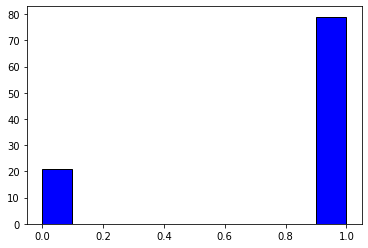

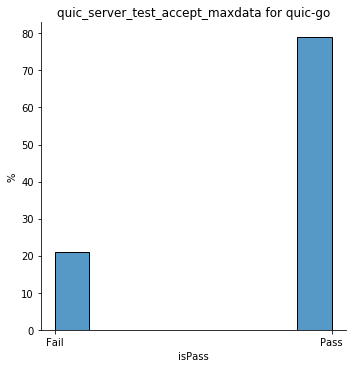

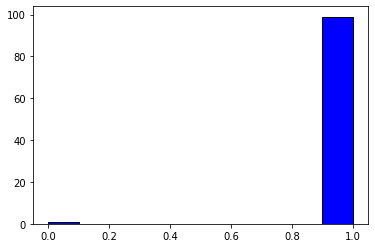

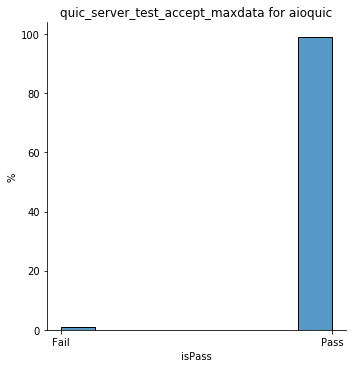

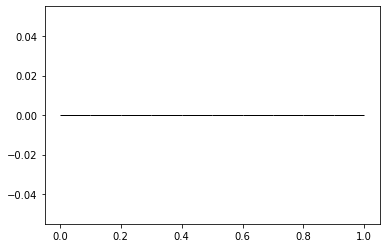

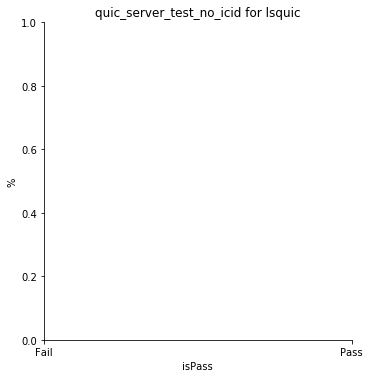

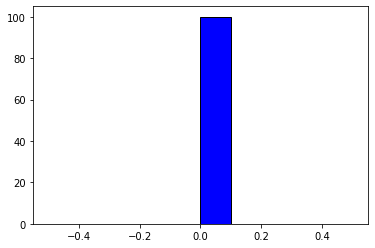

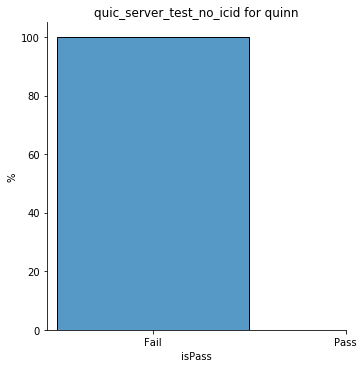

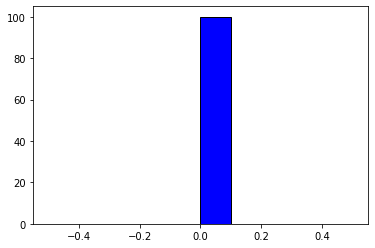

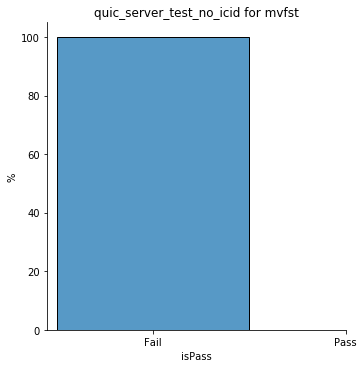

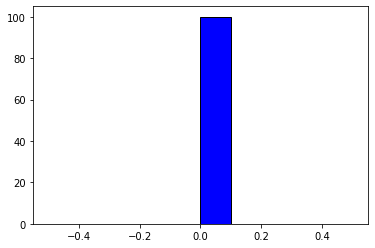

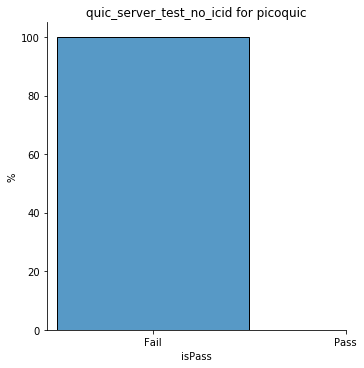

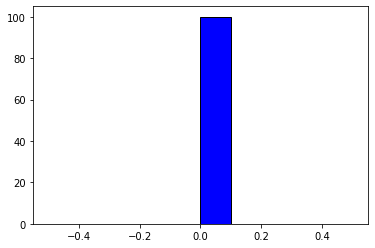

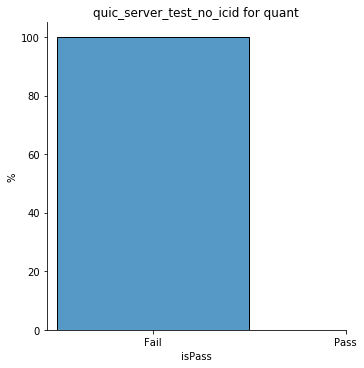

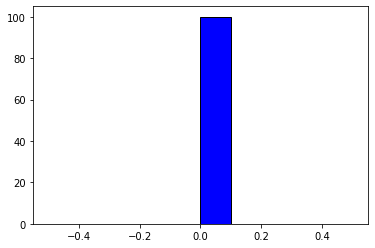

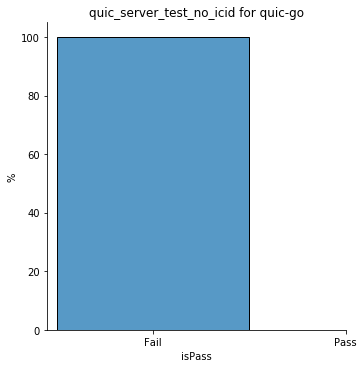

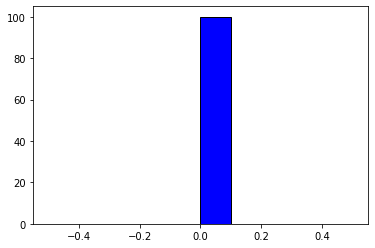

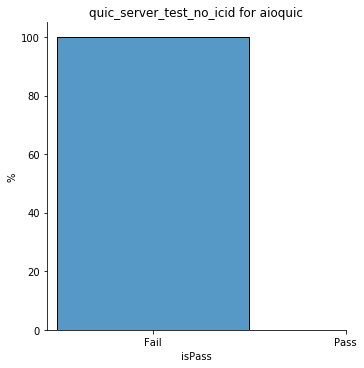

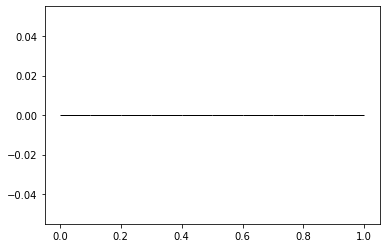

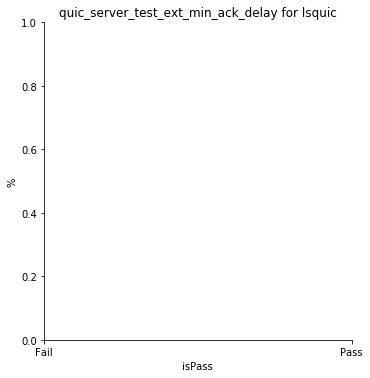

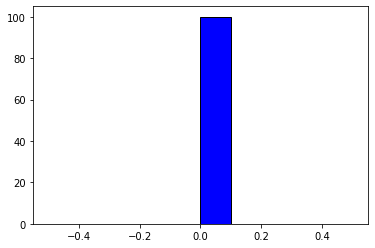

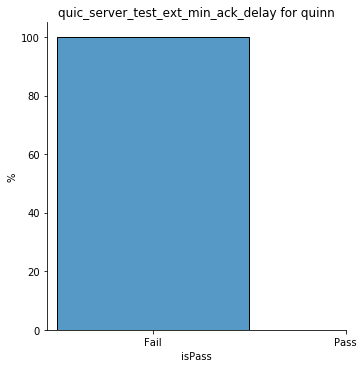

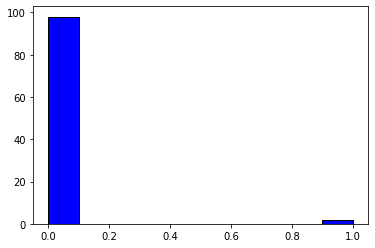

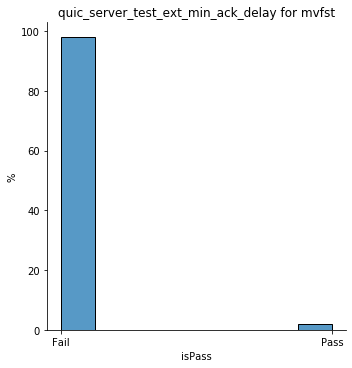

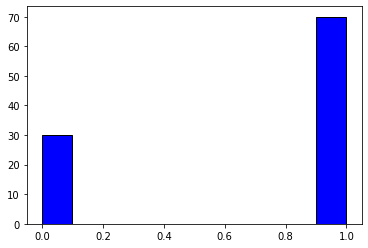

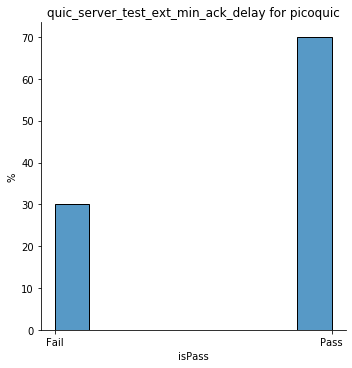

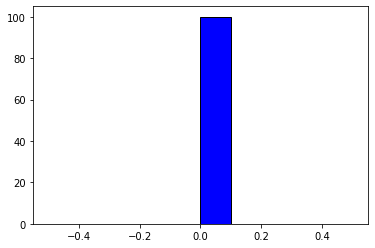

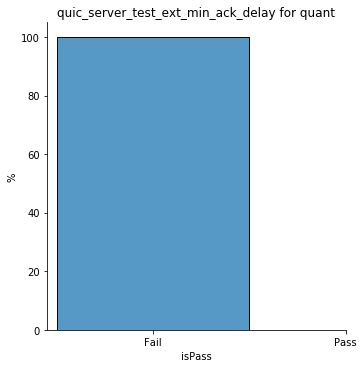

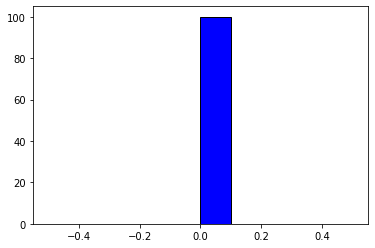

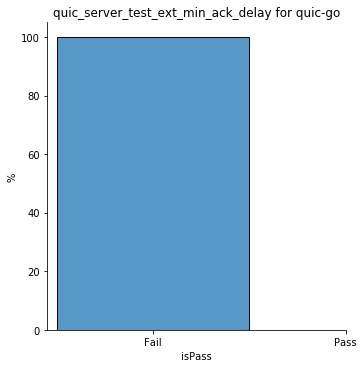

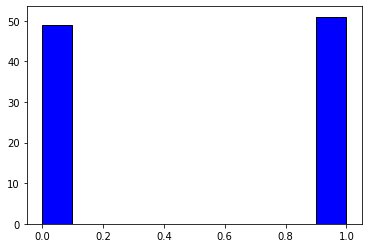

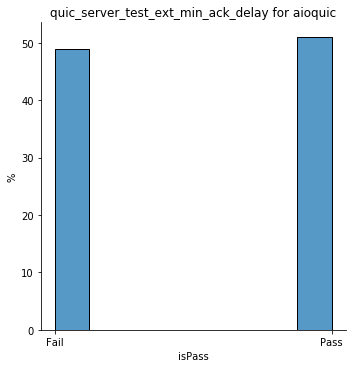

In [32]:
# Failure per test and per implementation

train_df.Implementation.unique()
tests = ['quic_server_test_stream', 
         'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 
         'quic_server_test_max',
       'quic_server_test_token_error', 
         'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

servers = ['lsquic', 'quinn',  'mvfst', 'picoquic', 'quant', 'quic-go', 'aioquic']
#plt.figure(figsize=[10,10]) 'lsquic',
#f,a = plt.subplots(2,2)
#a = a.ravel()

for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        plt.hist(subsubdf['isPass'], color = 'blue', edgecolor = 'black')

        # seaborn histogram
        sns.displot(subsubdf['isPass'], kde=False)
        # Add labels
        plt.xticks(np.arange(0, 1, 1))
        positions = (0, 1)
        labels = ("Fail", "Pass")
        plt.xticks(positions, labels)
        plt.title(t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + t + "_for_" + s + '.png'
        plt.savefig(filename)

        plt.show()
    

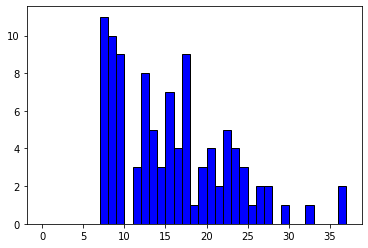

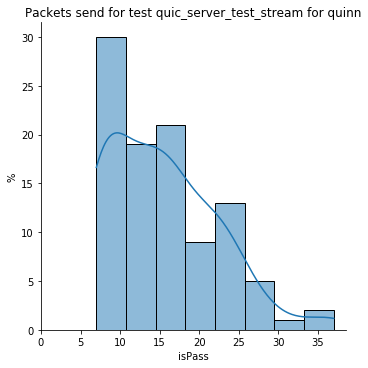

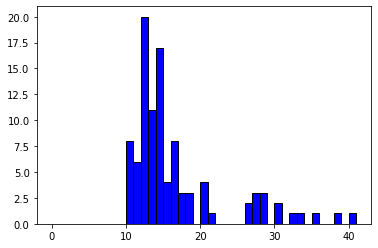

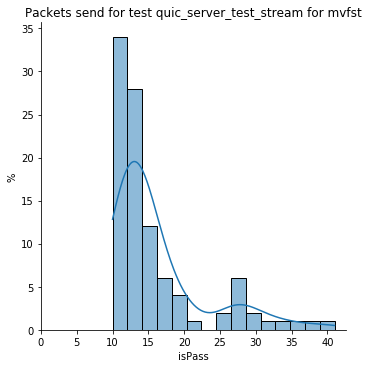

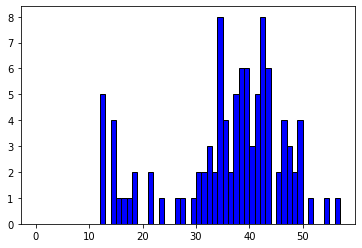

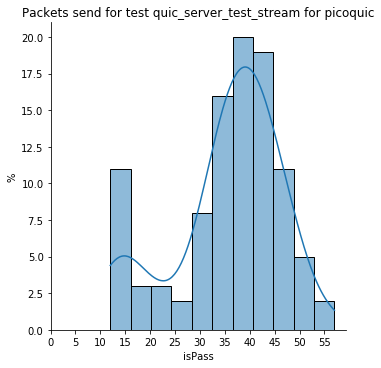

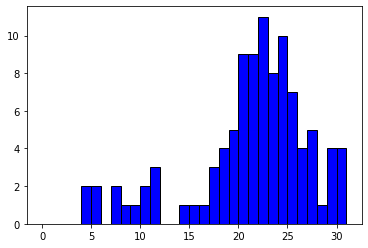

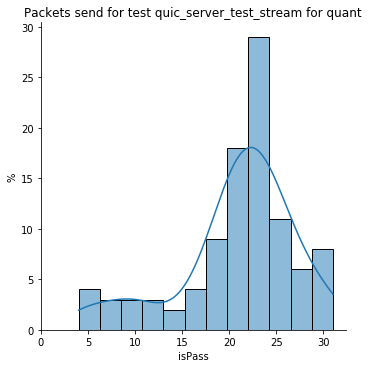

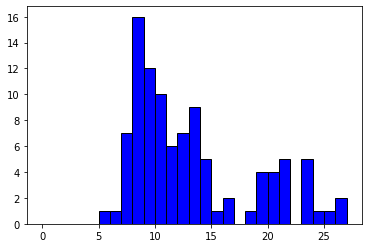

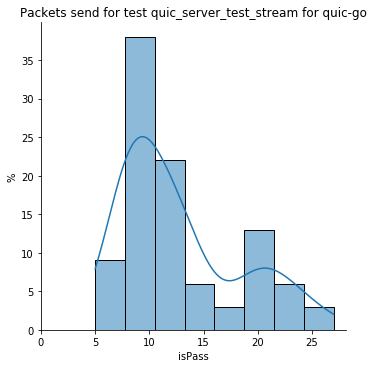

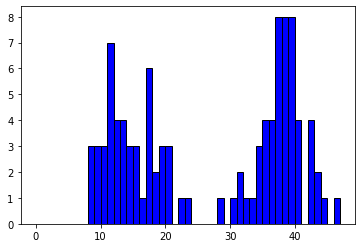

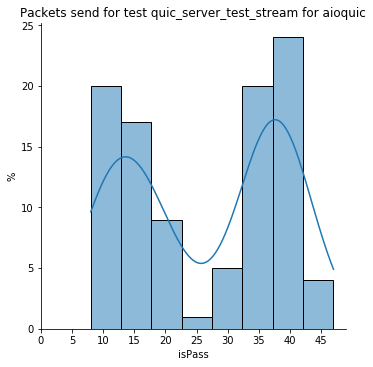

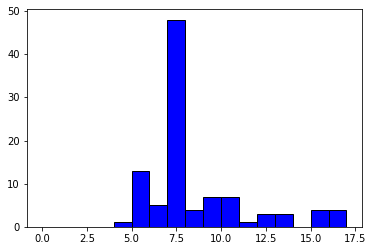

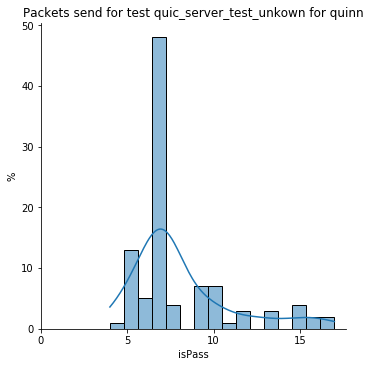

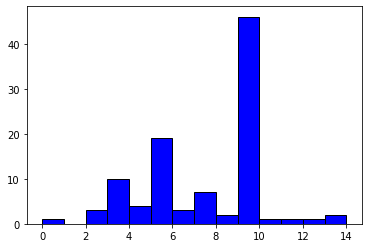

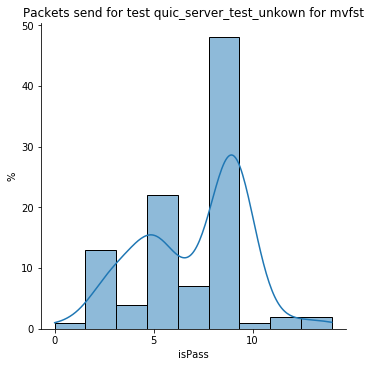

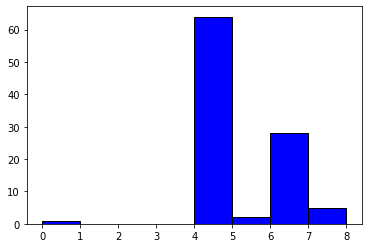

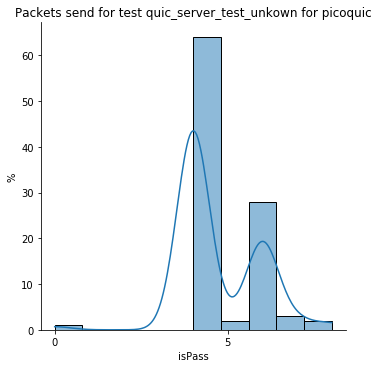

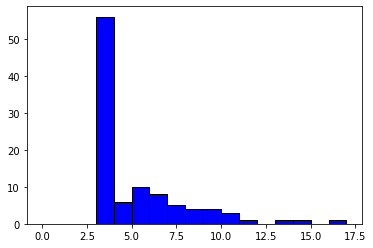

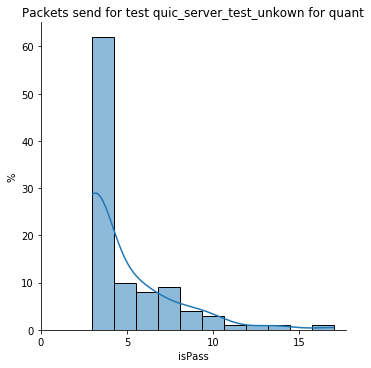

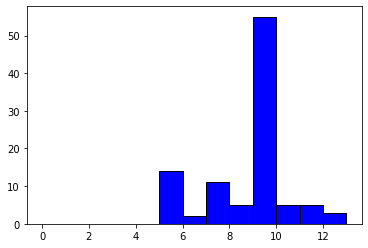

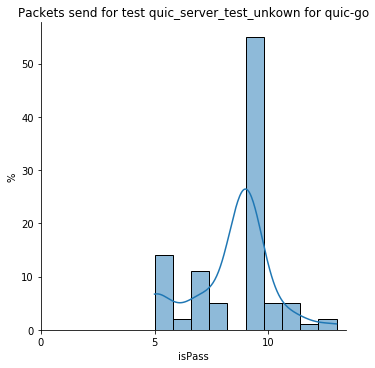

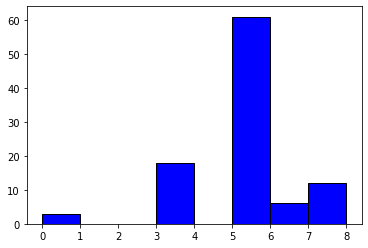

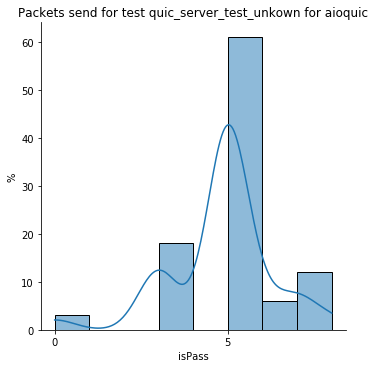

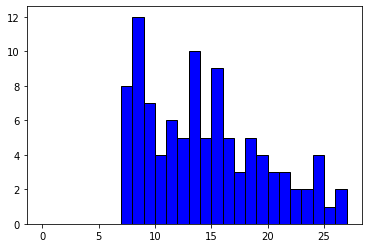

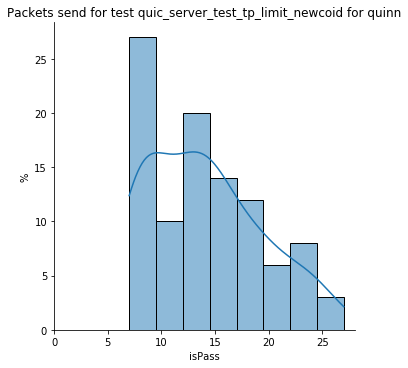

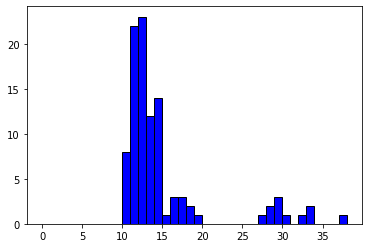

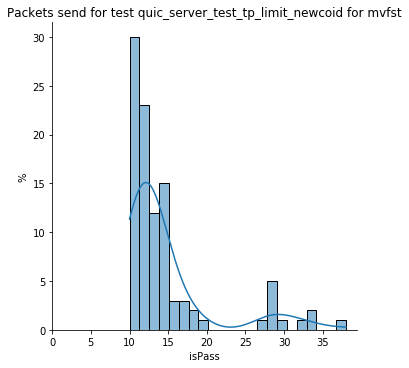

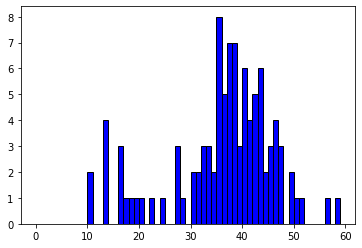

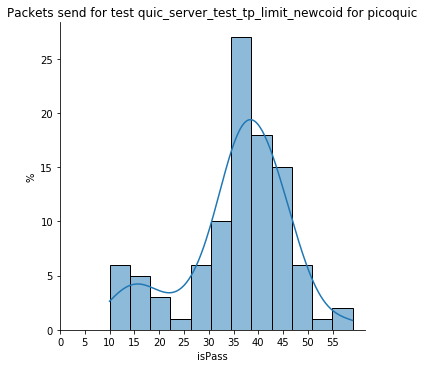

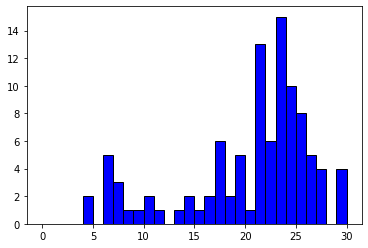

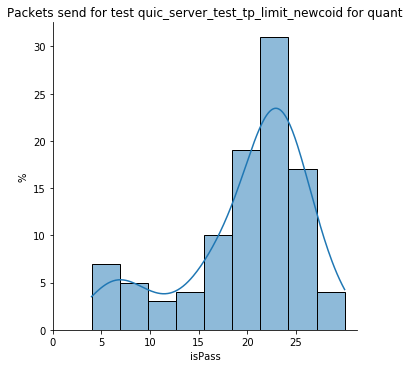

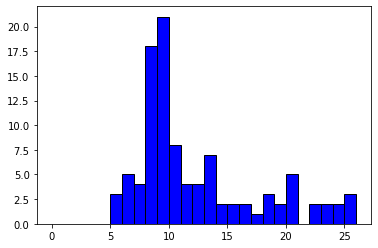

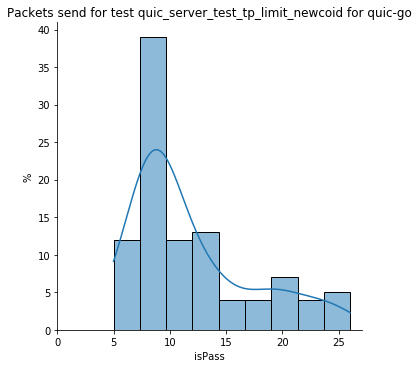

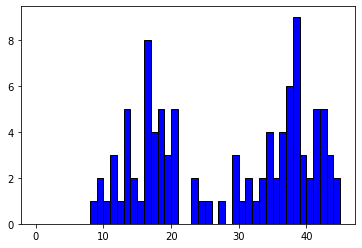

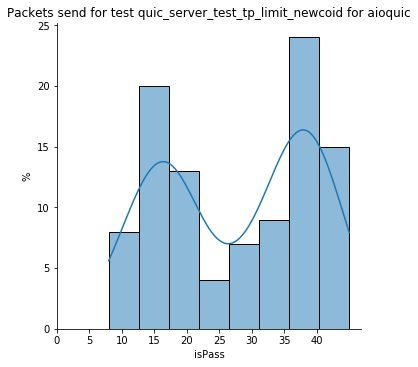

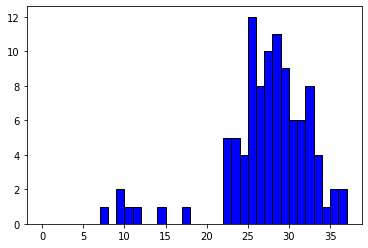

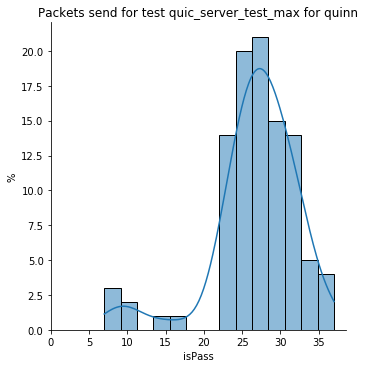

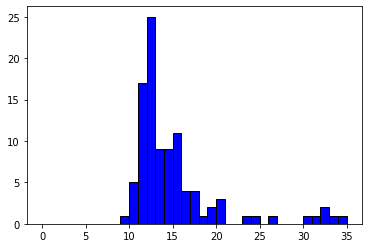

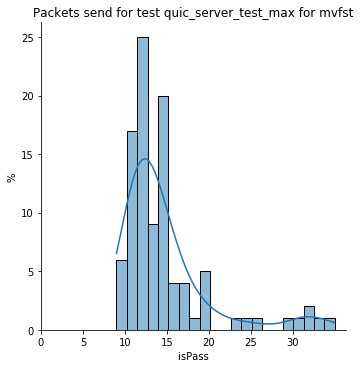

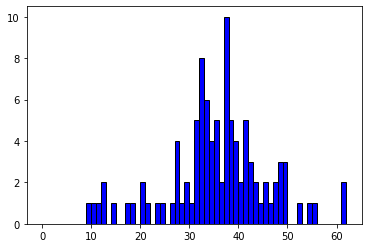

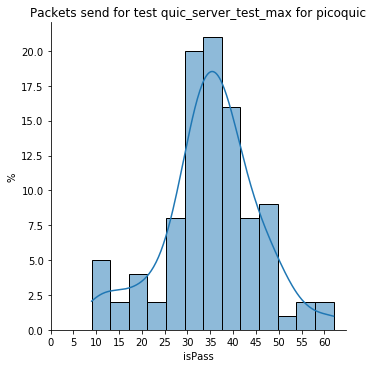

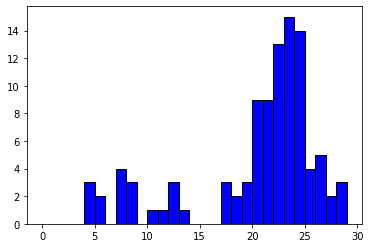

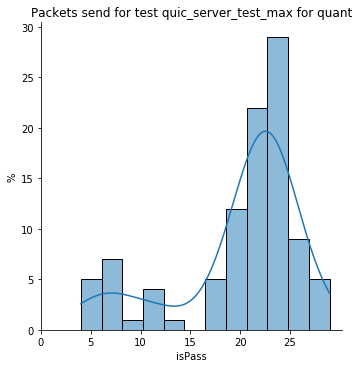

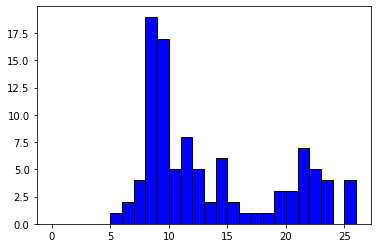

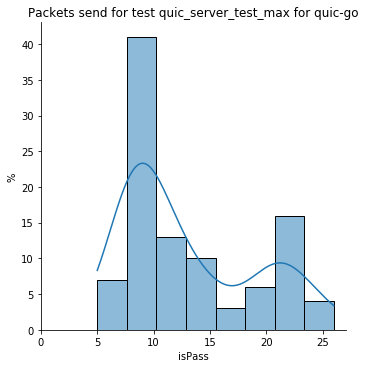

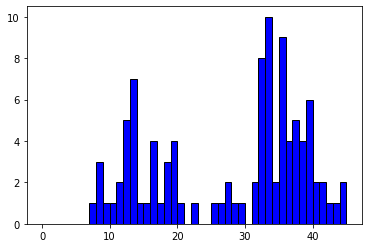

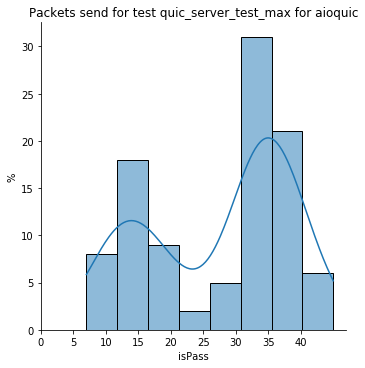

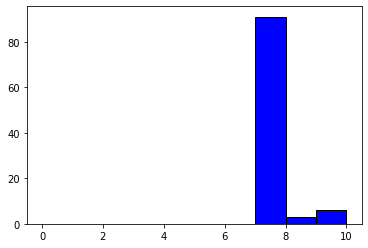

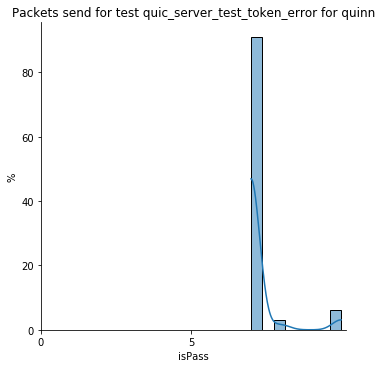

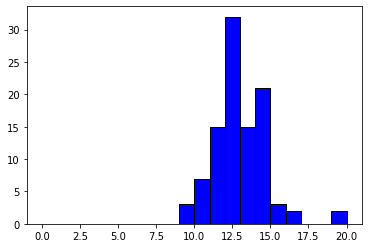

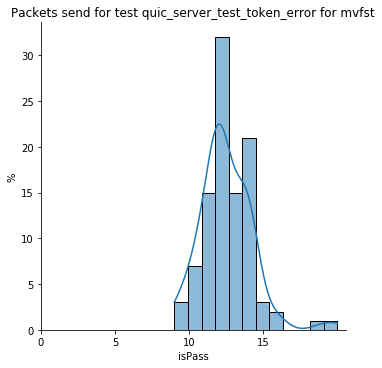

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


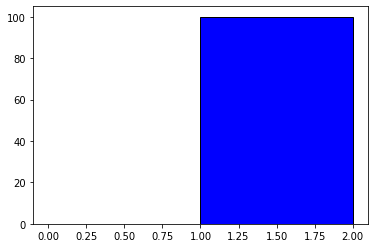

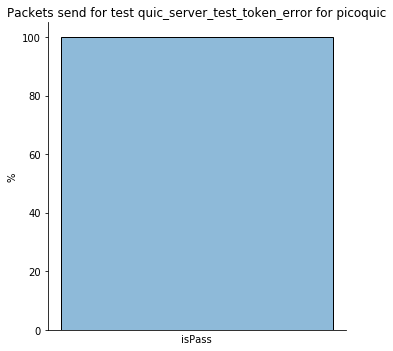

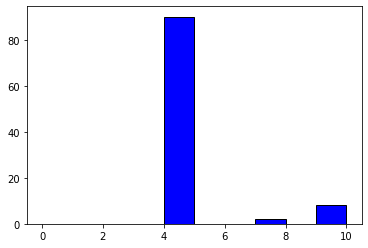

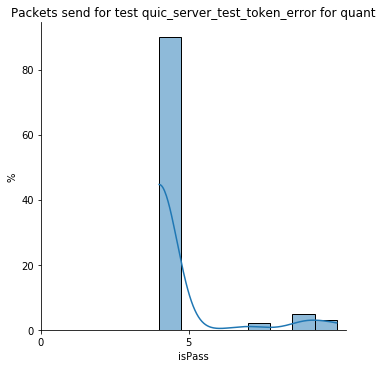

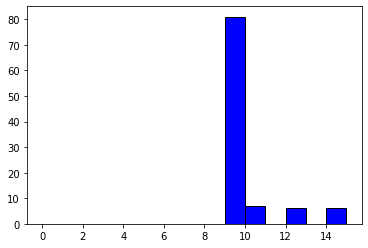

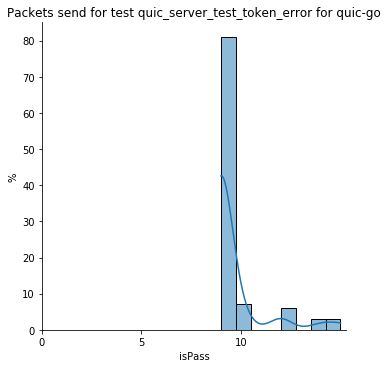

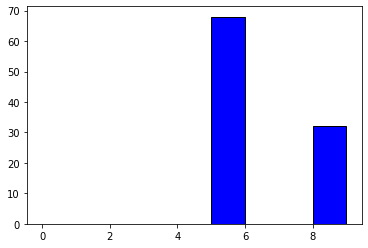

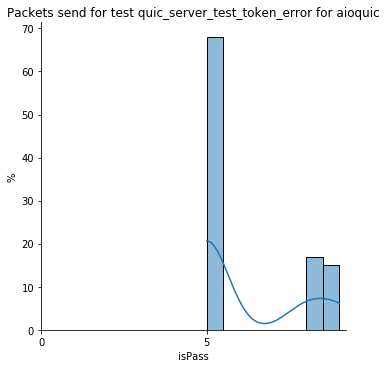

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


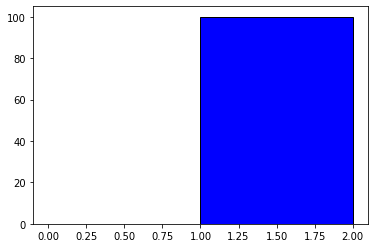

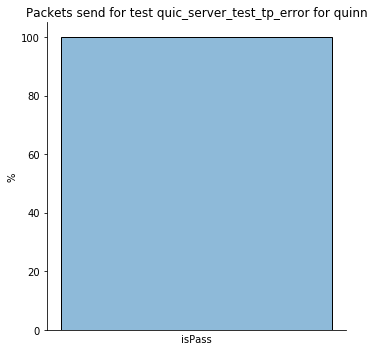

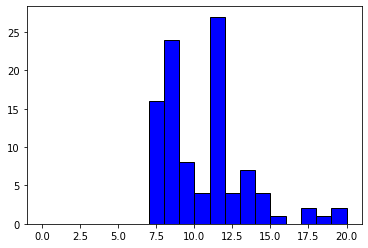

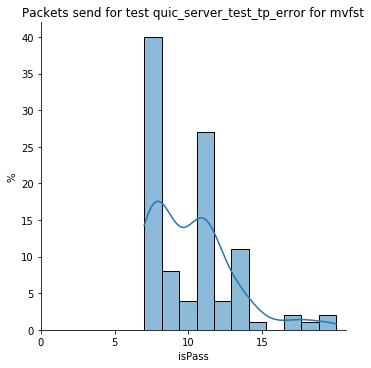

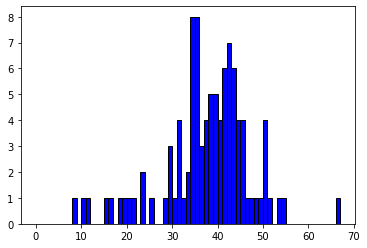

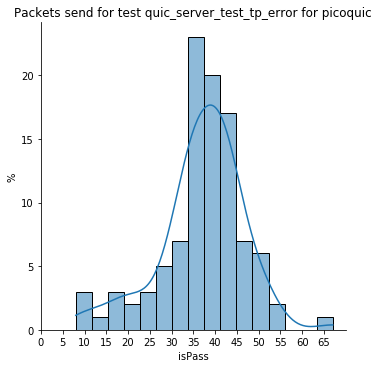

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


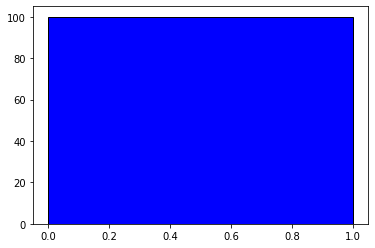

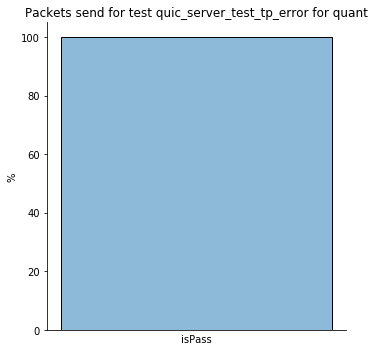

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


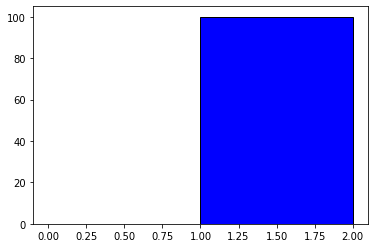

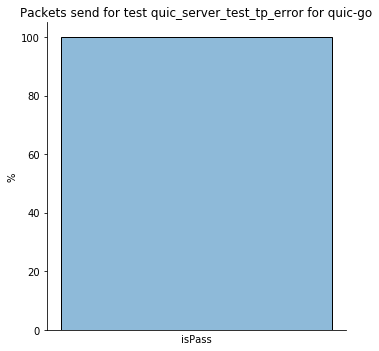

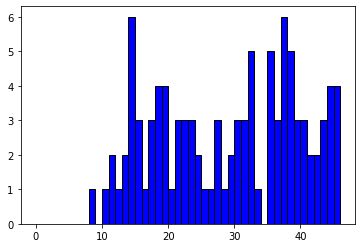

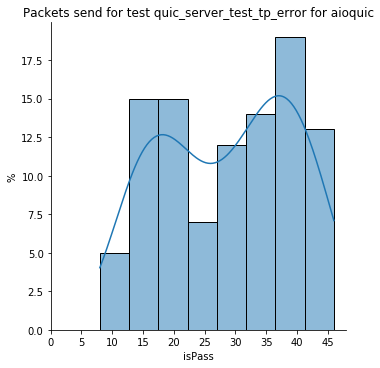

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


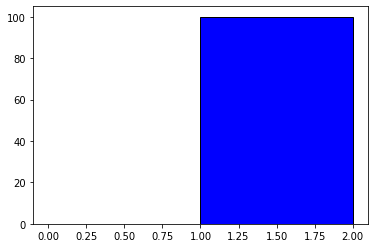

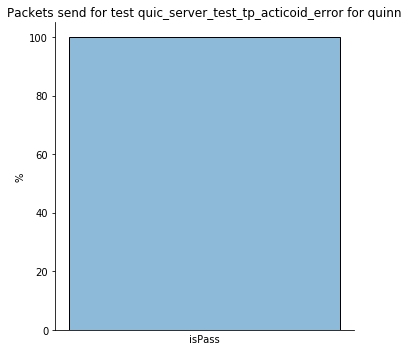

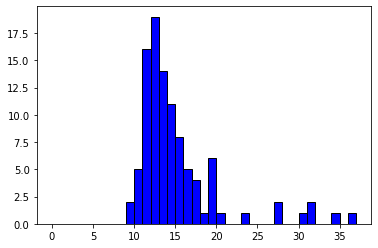

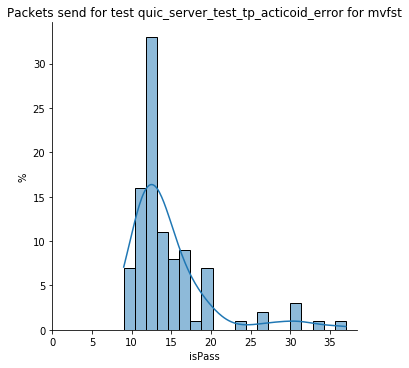

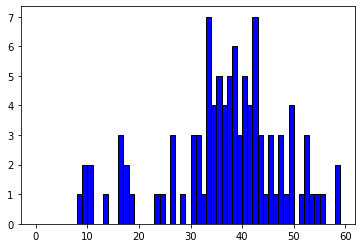

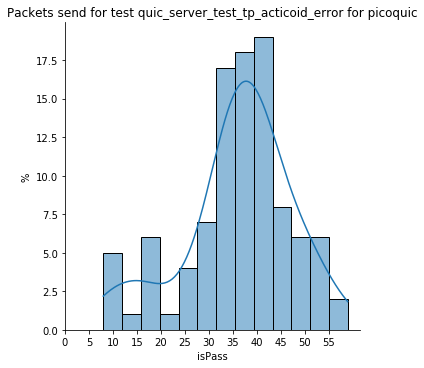

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


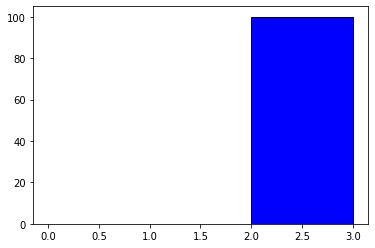

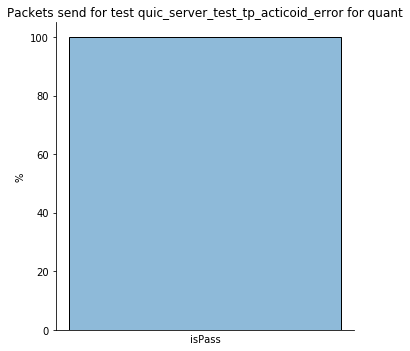

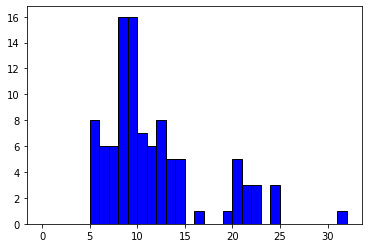

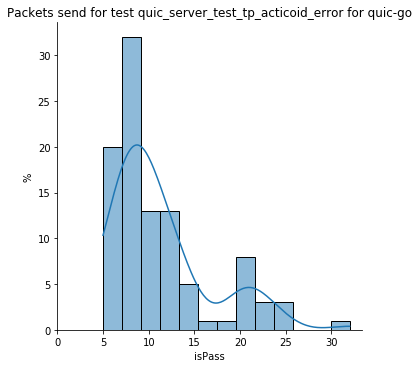

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


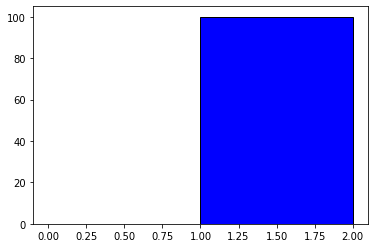

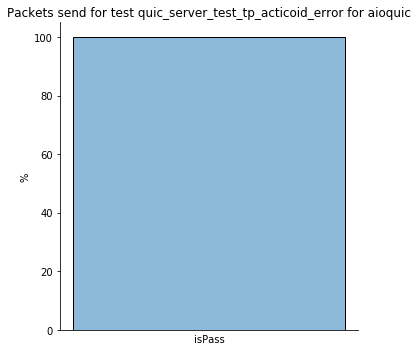

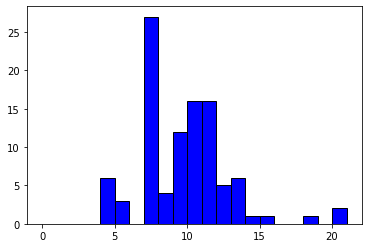

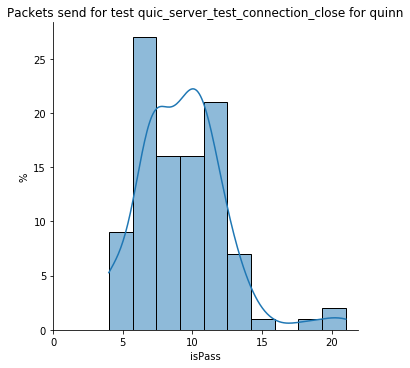

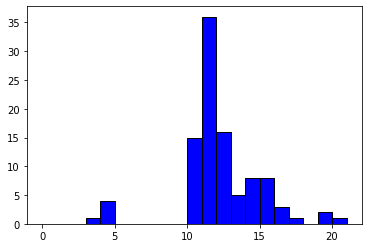

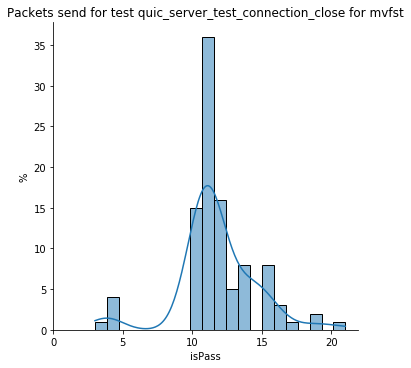

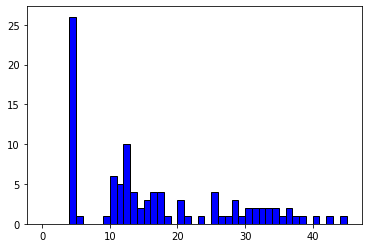

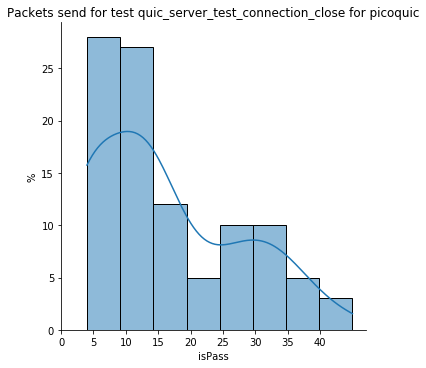

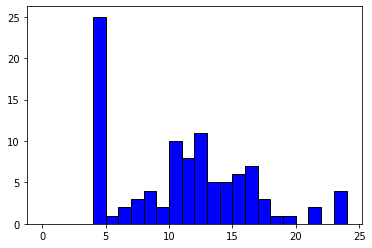

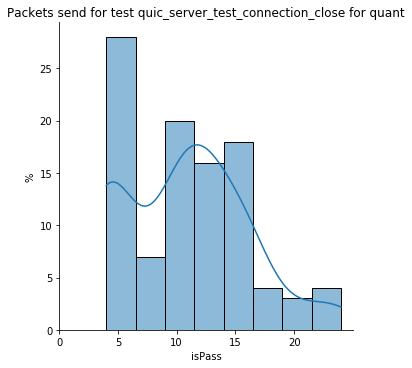

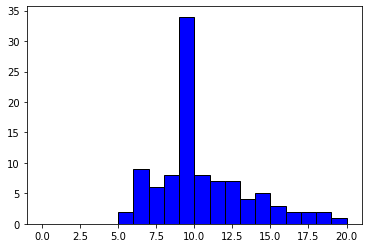

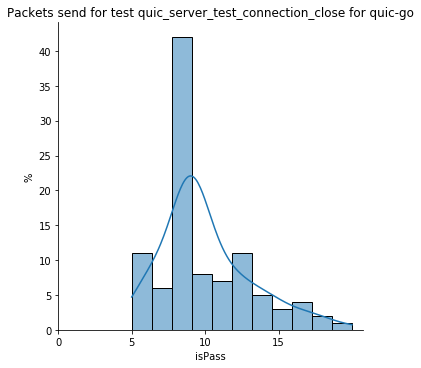

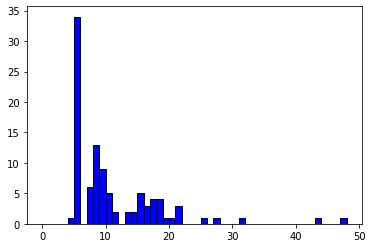

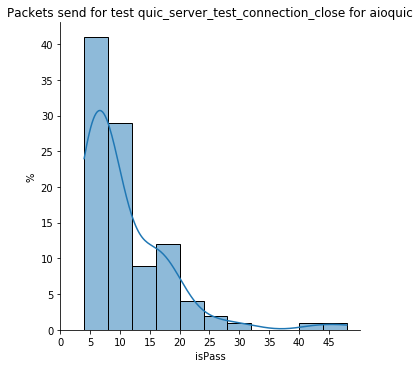

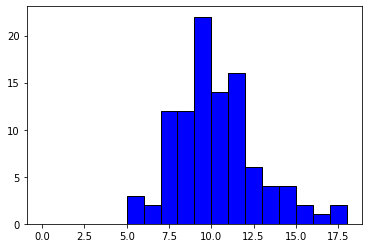

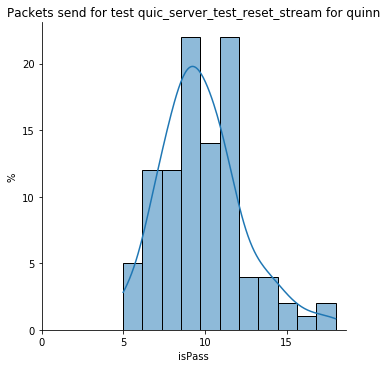

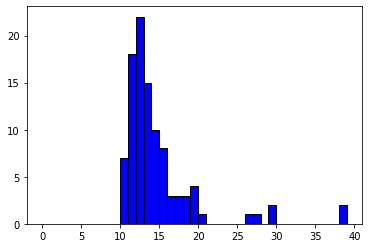

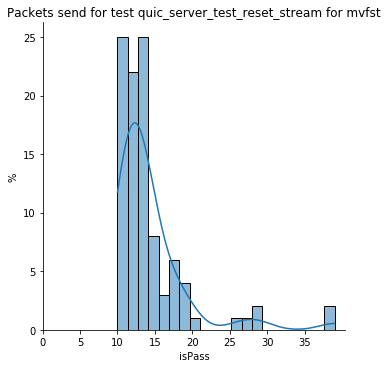

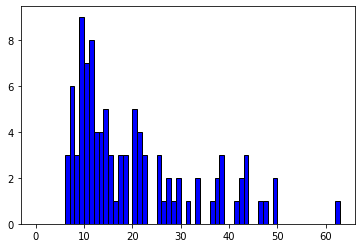

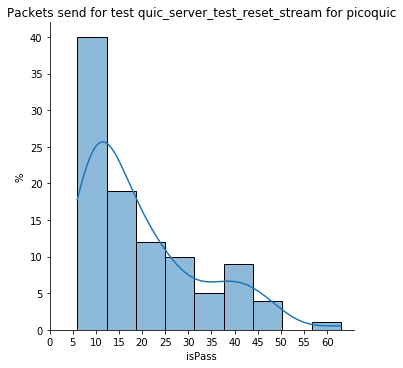

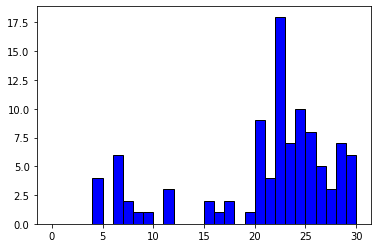

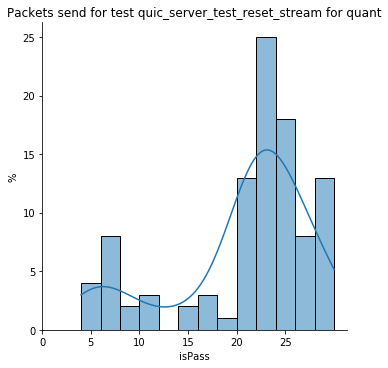

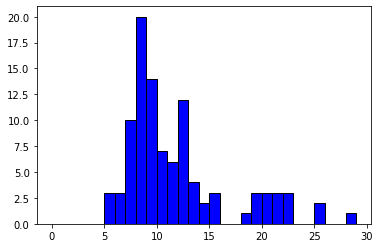

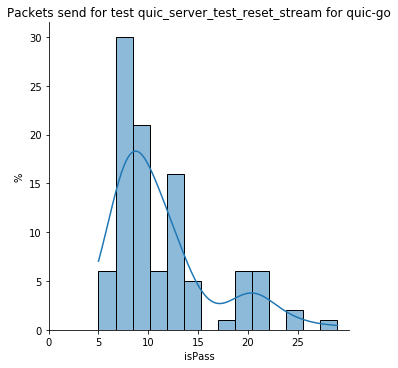

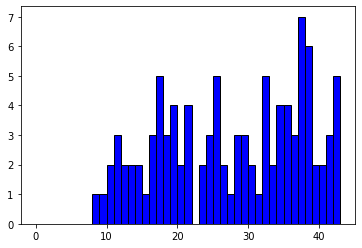

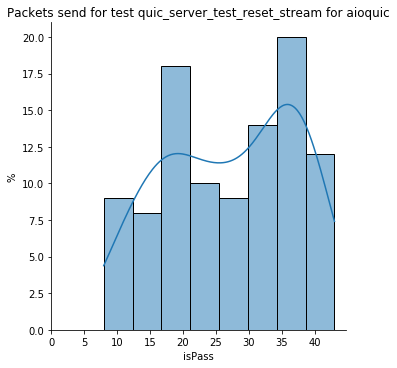

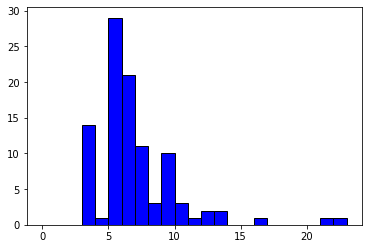

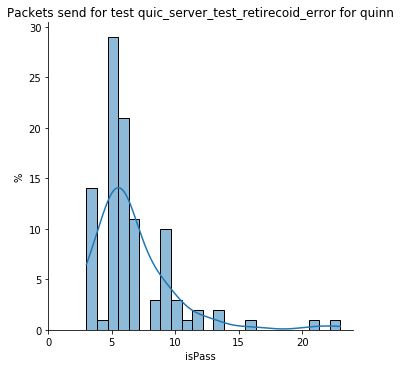

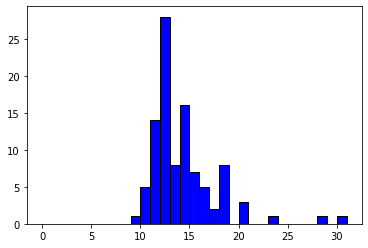

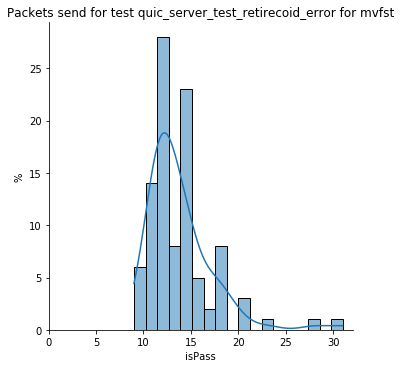

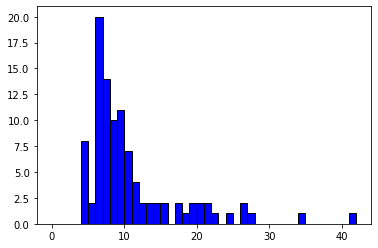

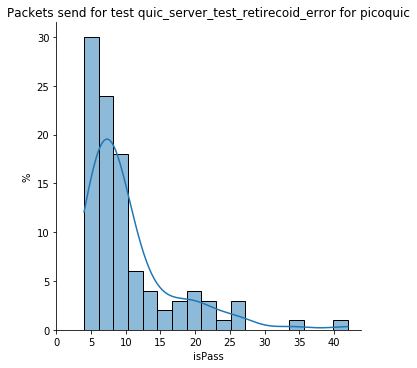

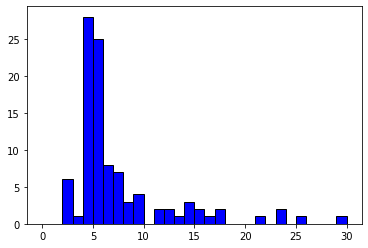

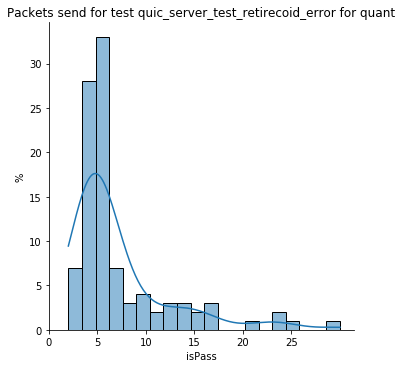

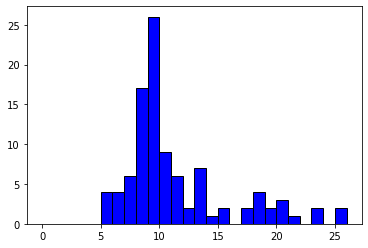

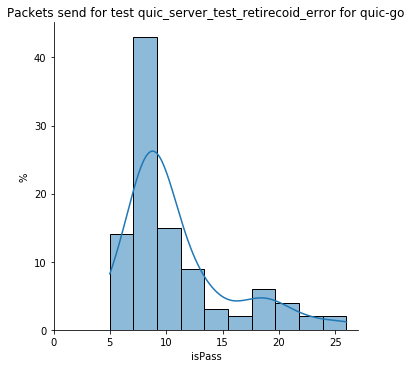

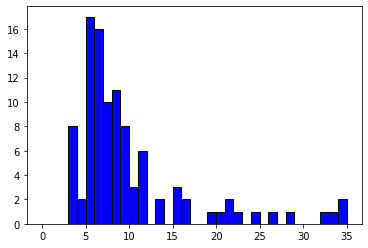

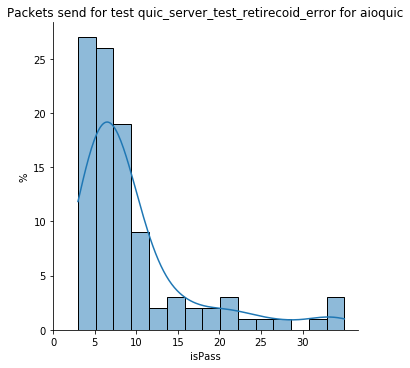

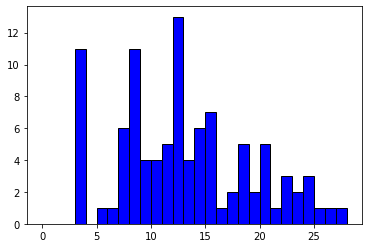

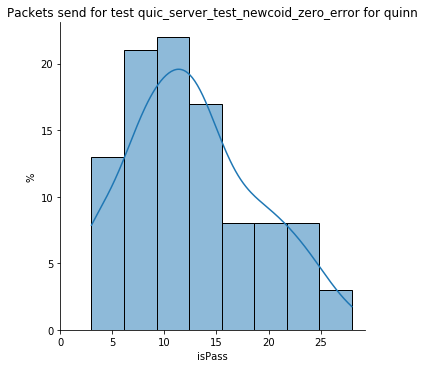

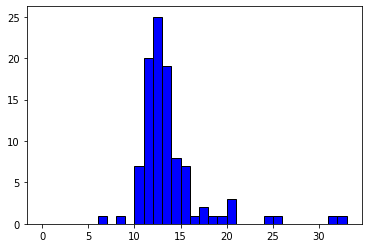

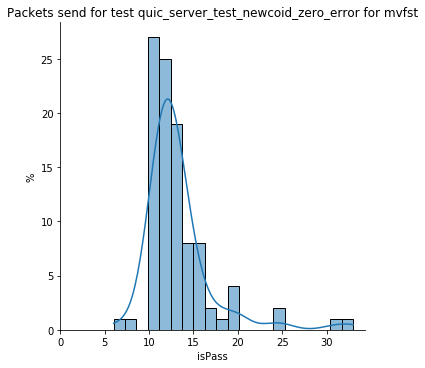

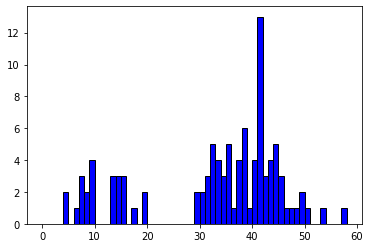

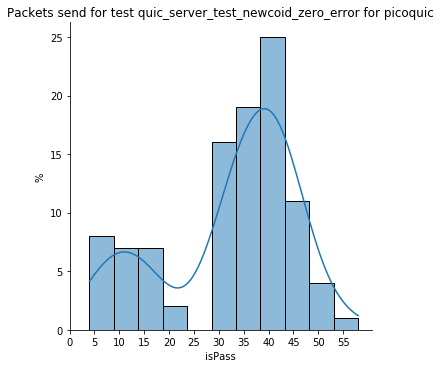

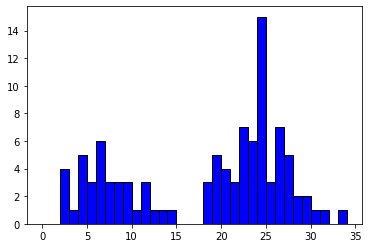

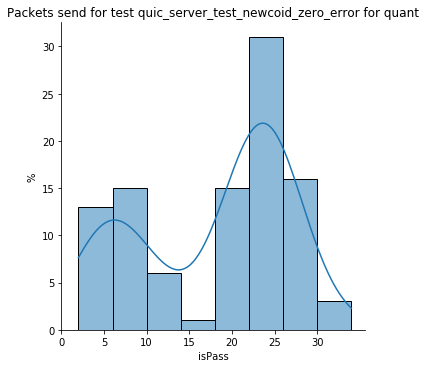

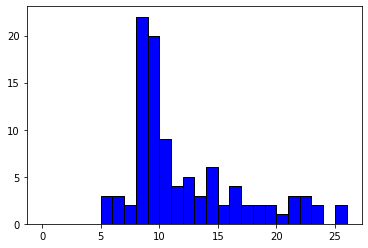

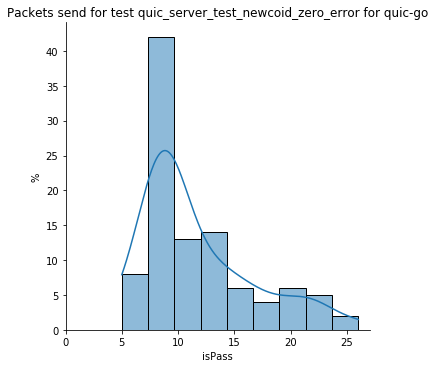

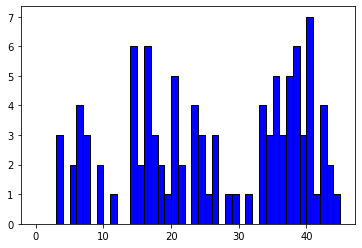

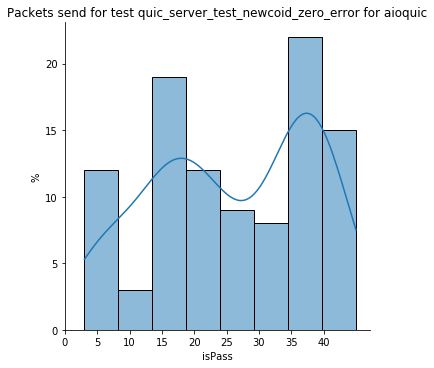

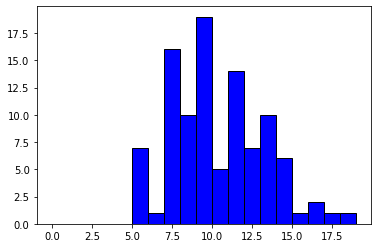

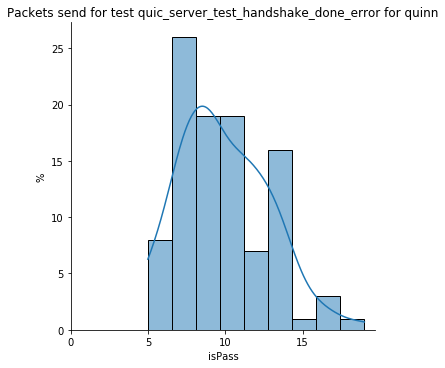

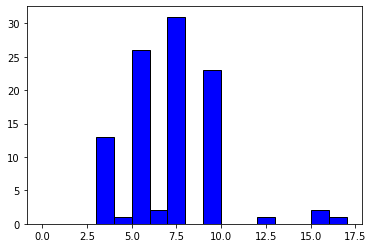

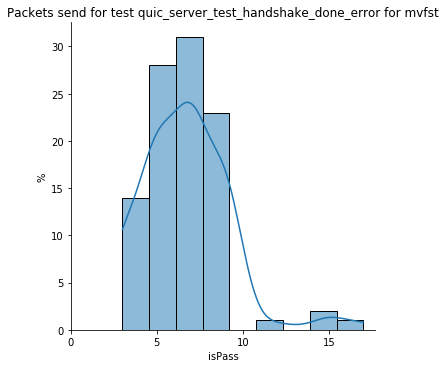

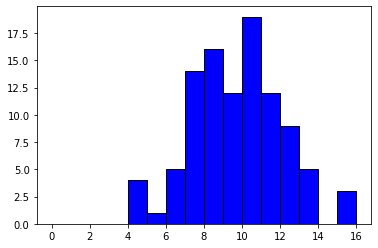

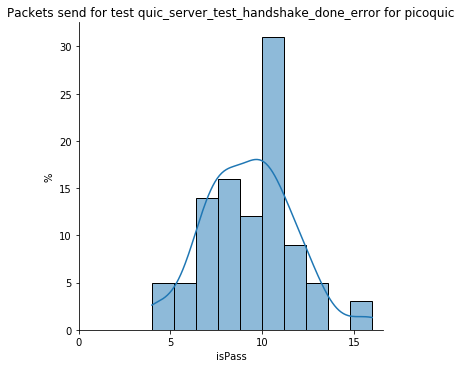

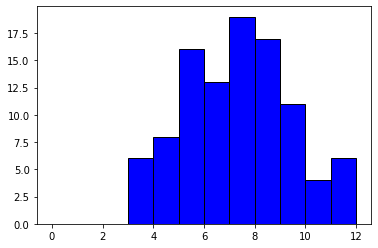

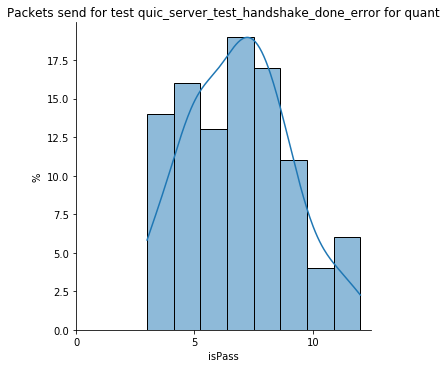

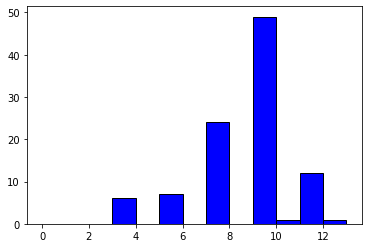

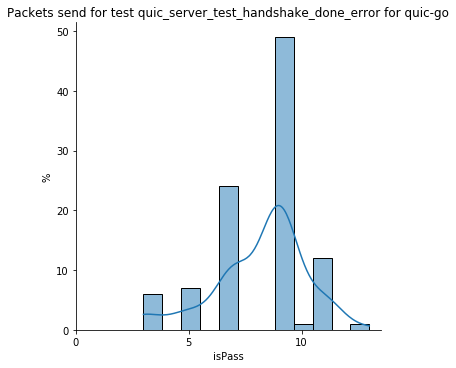

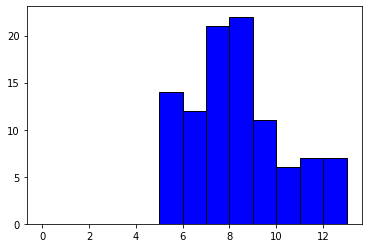

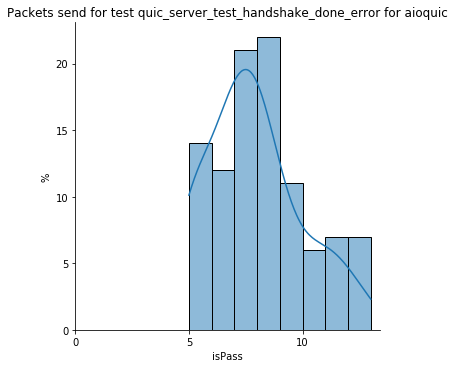

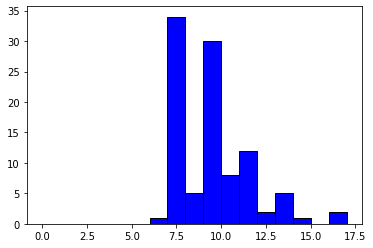

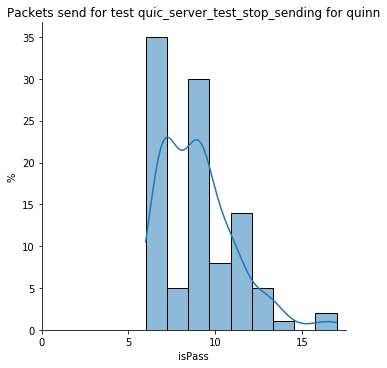

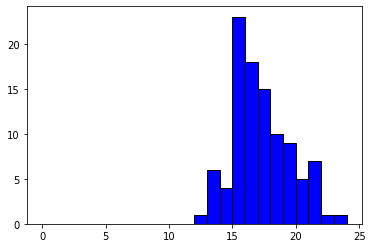

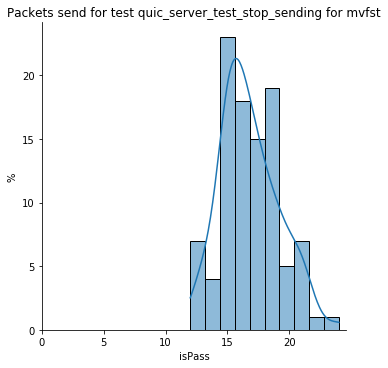

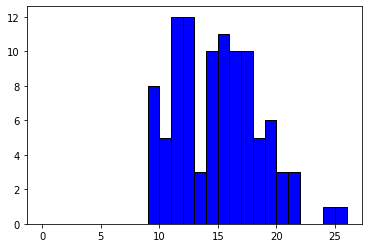

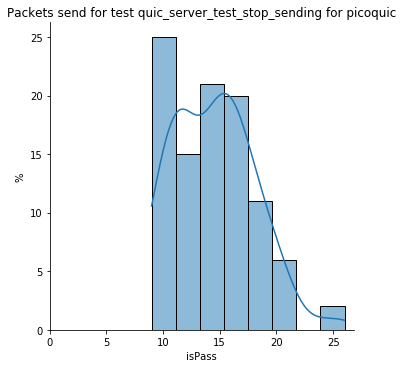

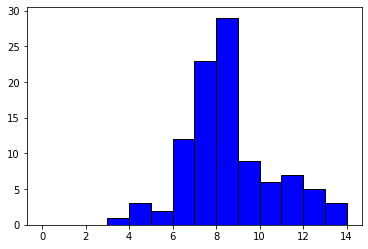

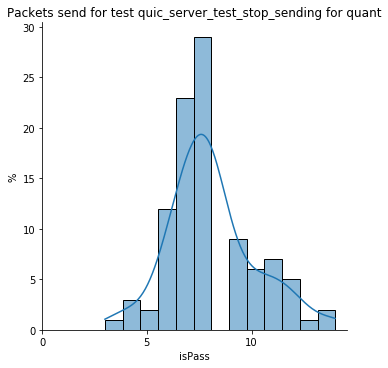

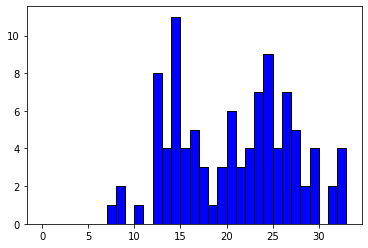

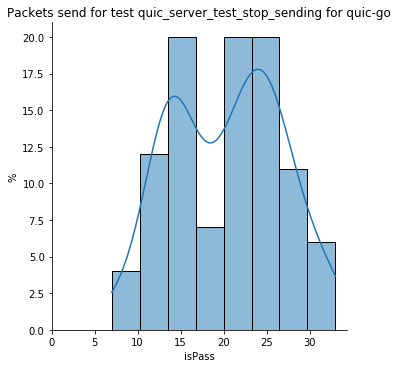

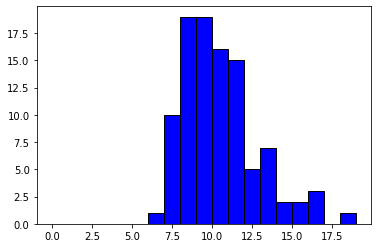

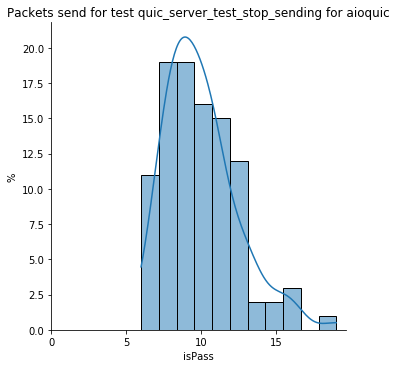

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


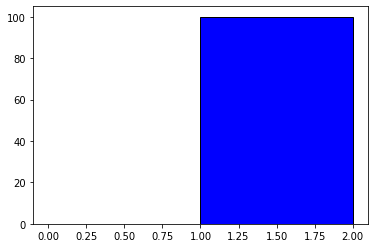

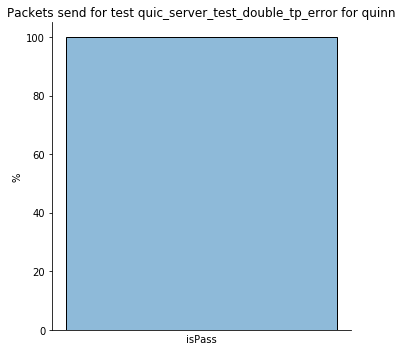

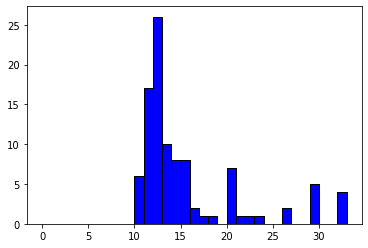

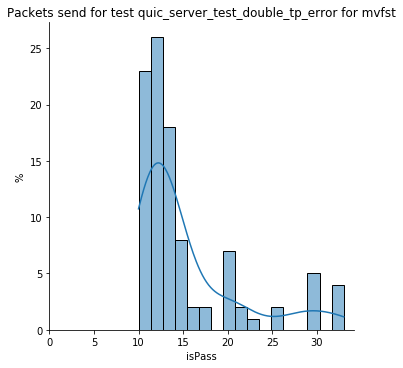

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


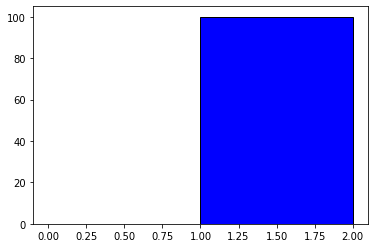

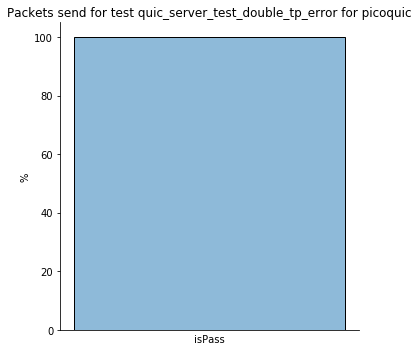

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


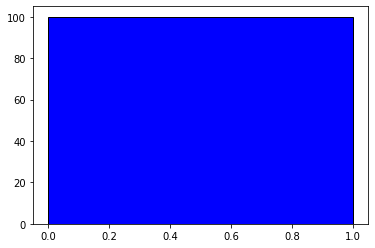

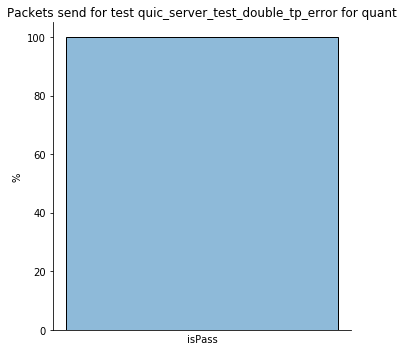

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


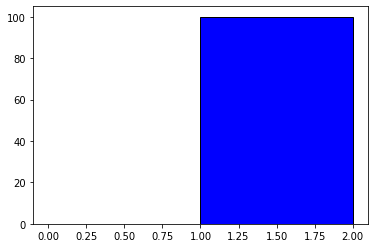

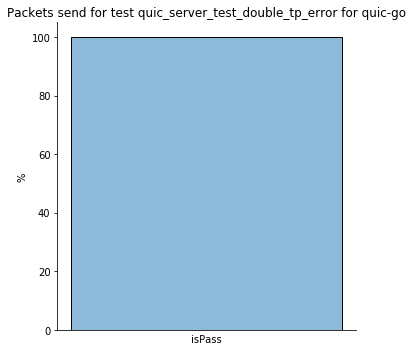

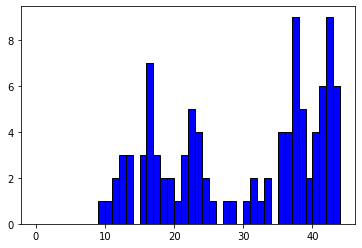

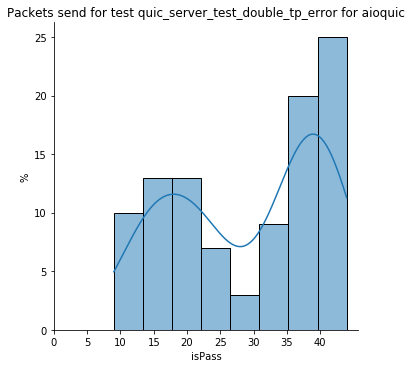

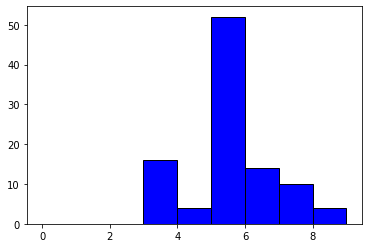

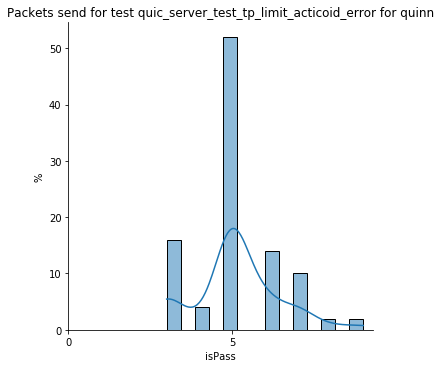

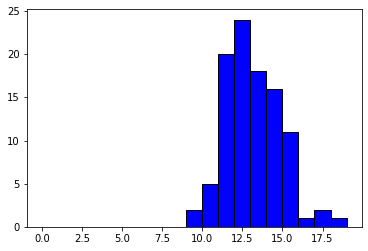

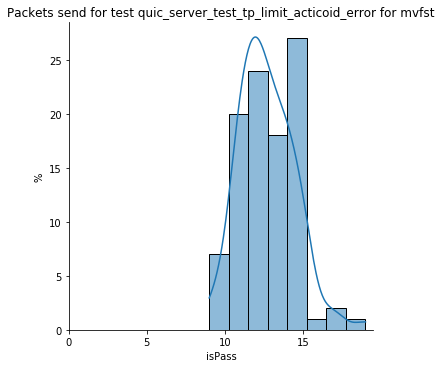

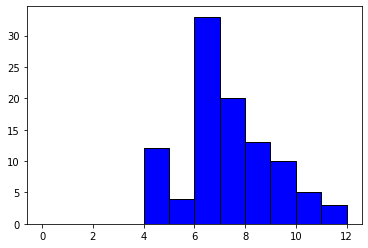

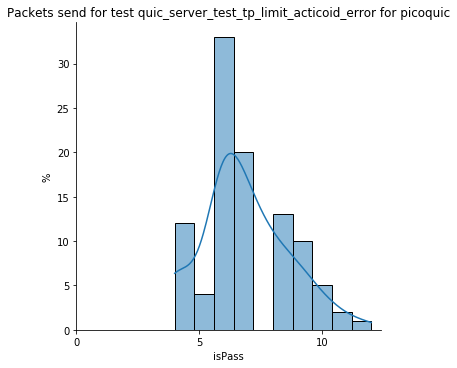

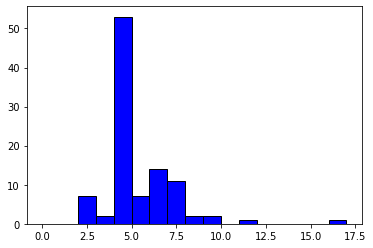

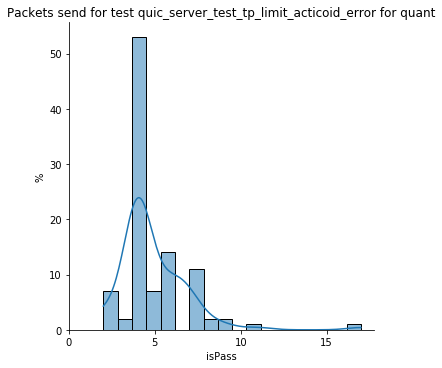

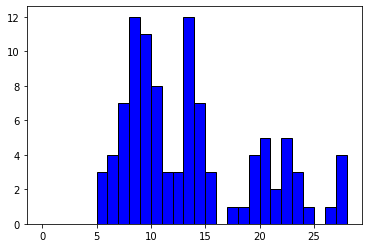

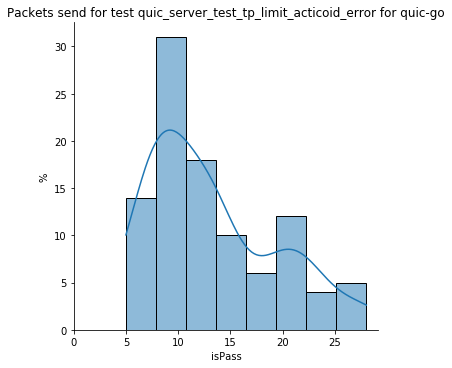

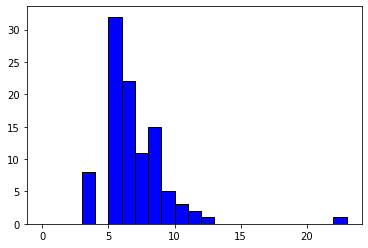

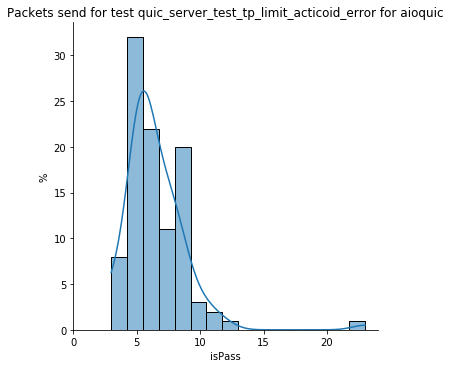

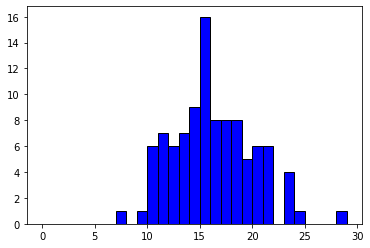

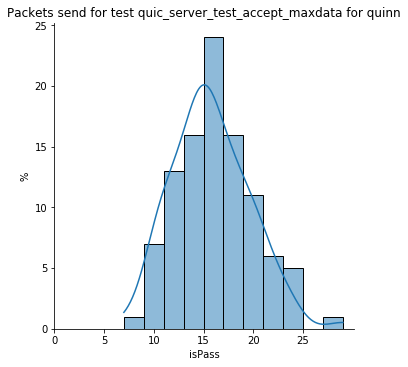

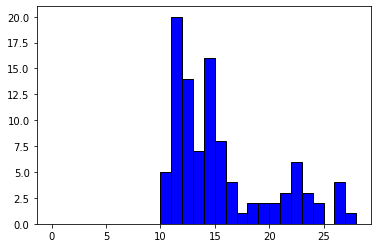

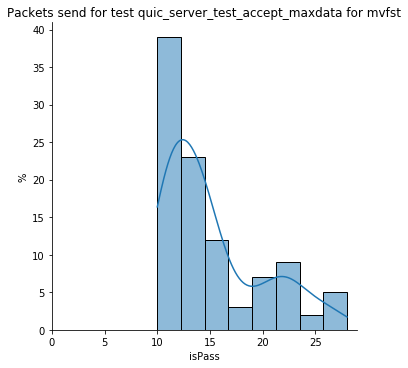

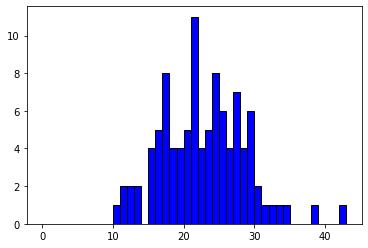

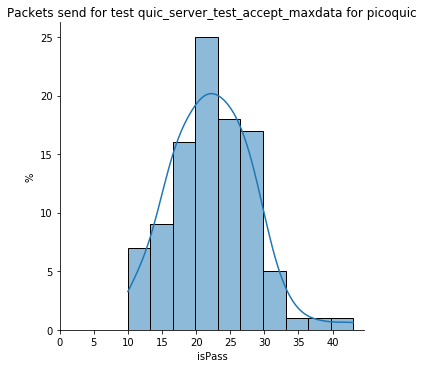

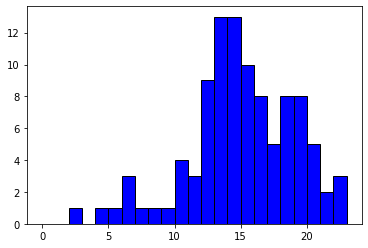

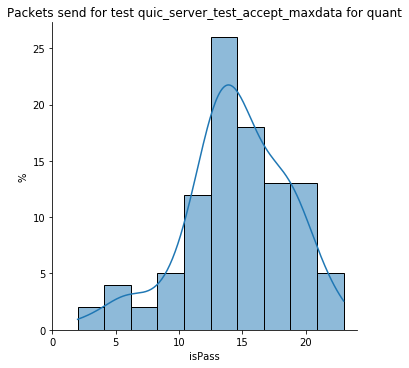

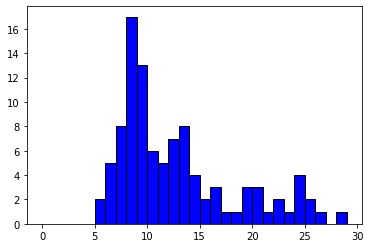

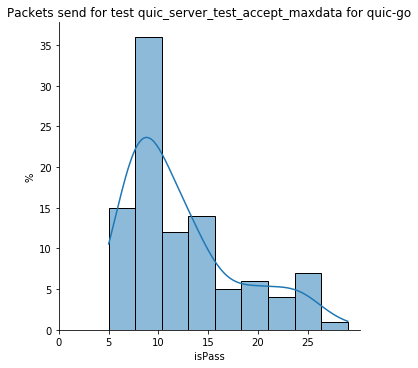

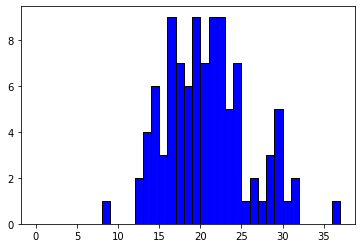

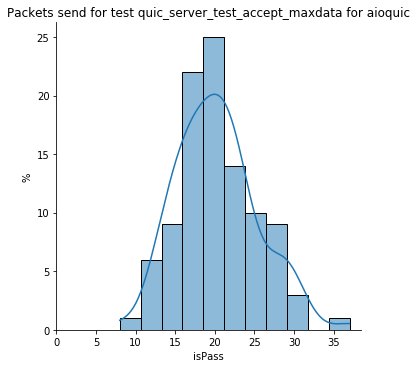

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


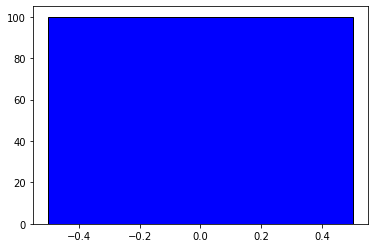

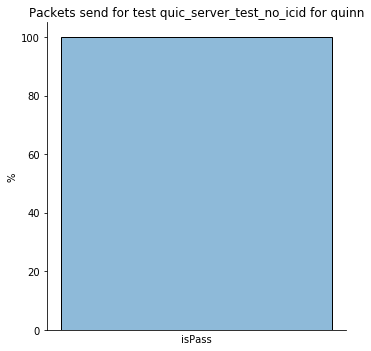

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


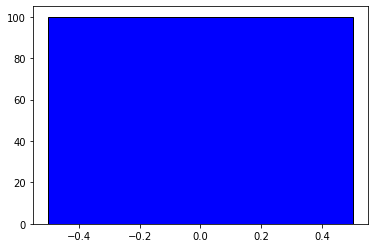

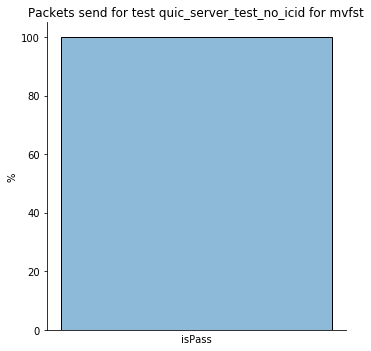

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


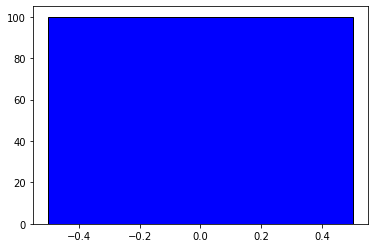

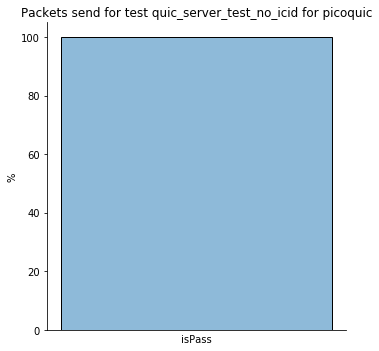

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


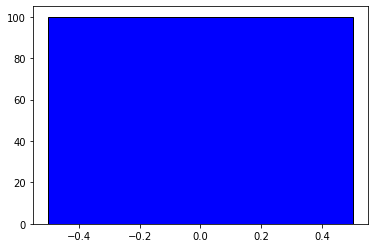

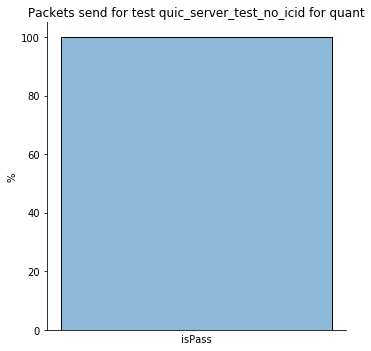

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


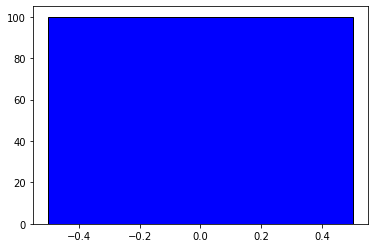

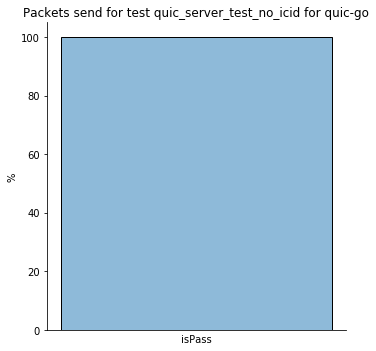

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


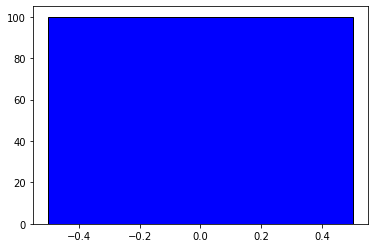

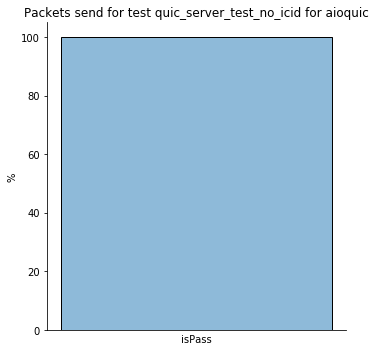

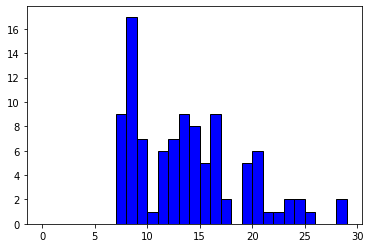

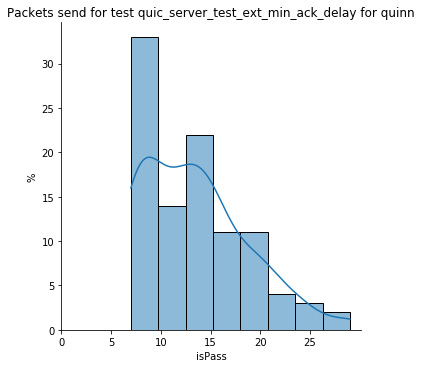

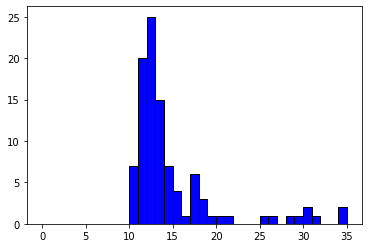

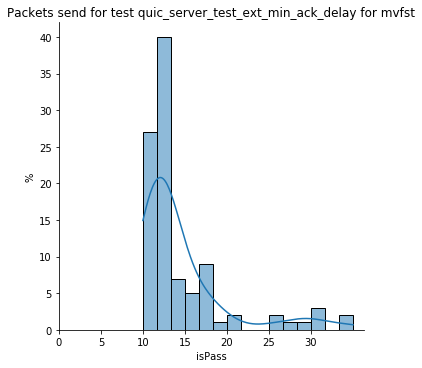

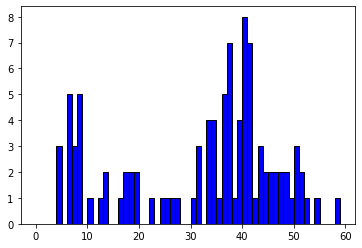

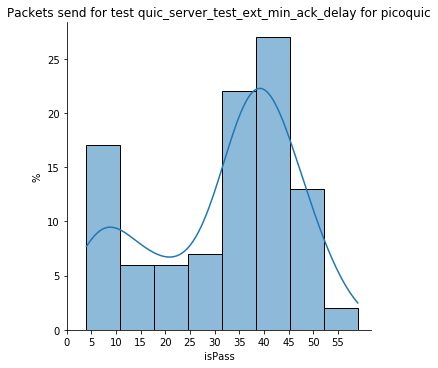

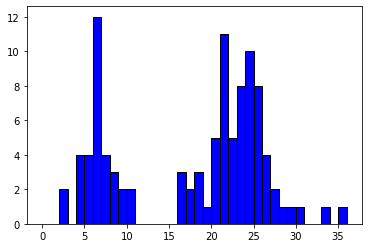

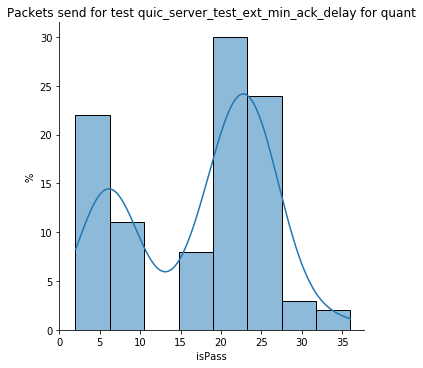

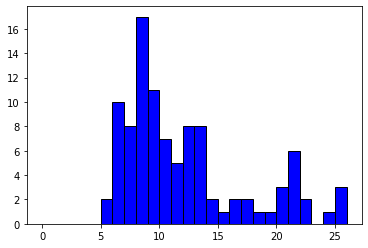

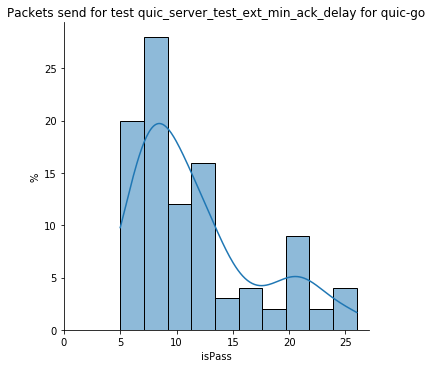

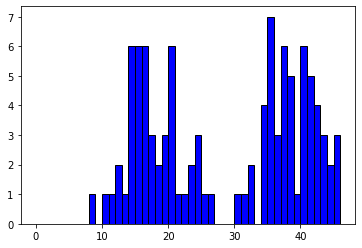

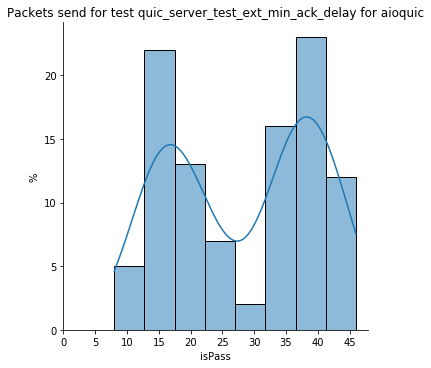

In [31]:
for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        max_value = subsubdf["NbPktSend"].max() 
    
        plt.hist(subsubdf['NbPktSend'], color = 'blue', edgecolor = 'black',
                 range = [0,max_value],bins=max(int(max_value),1))

        # seaborn histogram
        sns.displot(subsubdf['NbPktSend'], 
                     kde=True)
        # Add labels
        plt.xticks(np.arange(0, int(max_value),5))
        # Add labels
        # plt.xticks(np.arange(0, 1, 1))
        # positions = (0, 1)
        # labels = ("Fail", "Pass")
        # plt.xticks(positions, labels)
        plt.title("Packets send for test " + t + " for " + s)
        plt.xlabel('isPass')
        plt.ylabel('%')
        filename = 'plot/' + "packets_" + t + "_for_" + s + '.png'
        plt.savefig(filename)

        plt.show()

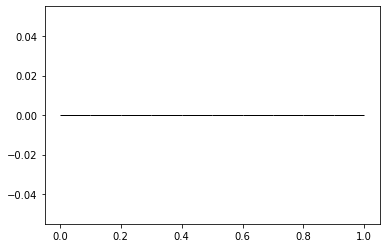

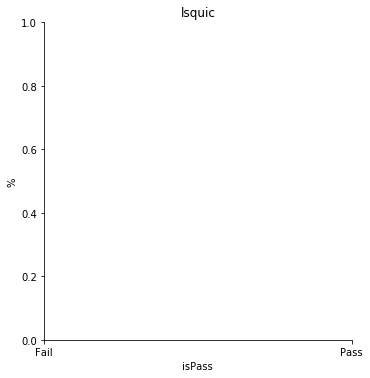

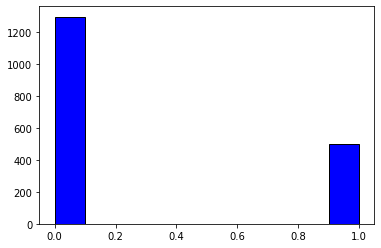

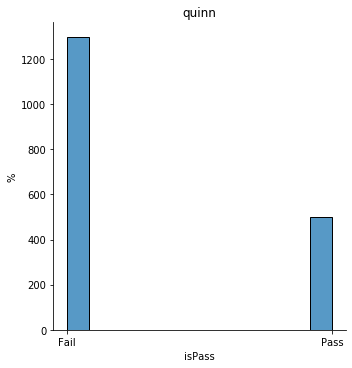

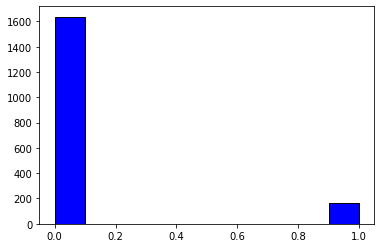

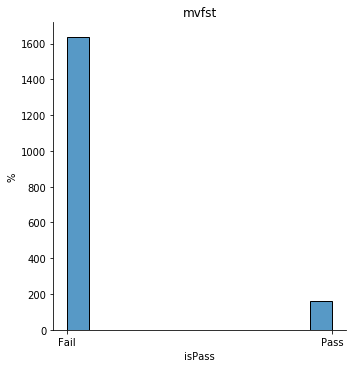

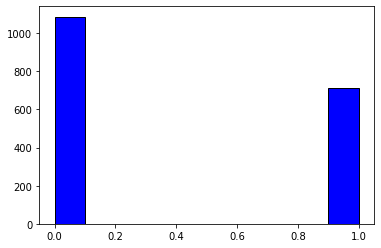

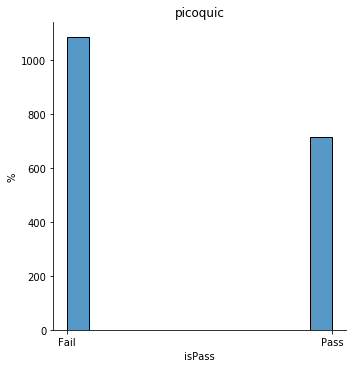

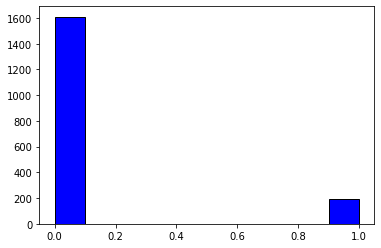

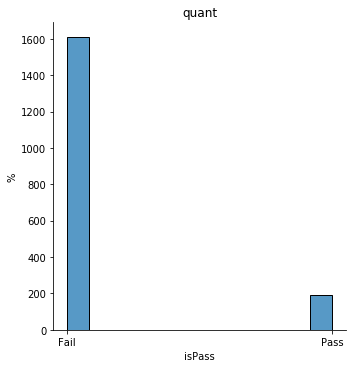

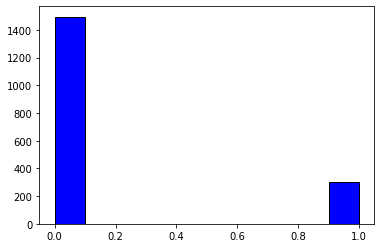

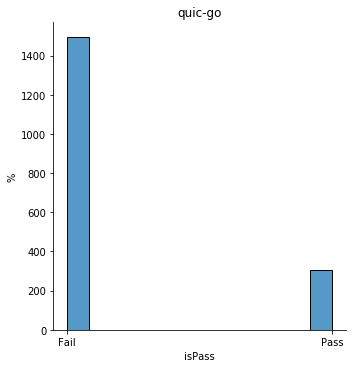

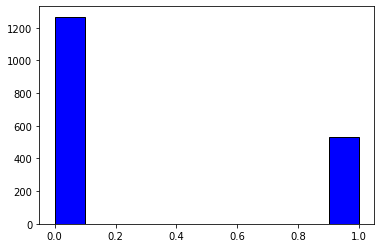

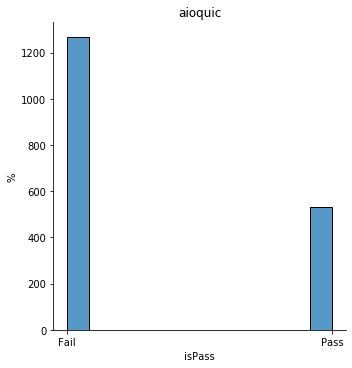

In [33]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    plt.hist(subdf['isPass'], color = 'blue', edgecolor = 'black')

    # seaborn histogram
    sns.displot(subdf['isPass'], kde=False)
    # Add labels
    plt.title(t)
    plt.xticks(np.arange(0, 2, 1))
    positions = (0, 1)
    labels = ("Fail", "Pass")
    plt.xticks(positions, labels)
    plt.xlabel('isPass')
    plt.ylabel('%')
    filename = 'plot/' + t + '.png'
    plt.savefig(filename)
    plt.show()
    

In [51]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    print(t)
    print(len(subdf.index))
    print(subdf["isPass"].sum())
    print()

quinn
1500
548.0

mvfst
1500
163.0

picoquic
1500
680.0

quic-go
1500
326.0

aioquic
1500
491.0

quant
1500
201.0

lsquic
0
0.0



In [52]:
for t in servers:
    subdf = train_df.loc[train_df['Implementation'] == t]
    for s in tests:
        ssubdf = subdf.loc[subdf['TestName'] == s]
        print(t)
        print(s)
        print(len(ssubdf.index))
        print(ssubdf["isPass"].sum())
        print()

quinn
quic_server_test_stream
100
0.0

quinn
quic_server_test_unkown
100
57.0

quinn
quic_server_test_tp_limit_newcoid
100
0.0

quinn
quic_server_test_max
100
0.0

quinn
quic_server_test_token_error
100
100.0

quinn
quic_server_test_tp_error
100
100.0

quinn
quic_server_test_tp_acticoid_error
100
100.0

quinn
quic_server_test_connection_close
100
0.0

quinn
quic_server_test_reset_stream
100
0.0

quinn
quic_server_test_retirecoid_error
0
0.0

quinn
quic_server_test_newcoid_zero_error
0
0.0

quinn
quic_server_test_handshake_done_error
100
91.0

quinn
quic_server_test_stop_sending
100
0.0

quinn
quic_server_test_double_tp_error
100
100.0

quinn
quic_server_test_tp_limit_acticoid_error
100
0.0

quinn
quic_server_test_accept_maxdata
0
0.0

quinn
quic_server_test_no_icid
100
0.0

quinn
quic_server_test_ext_min_ack_delay
100
0.0

mvfst
quic_server_test_stream
100
3.0

mvfst
quic_server_test_unkown
100
26.0

mvfst
quic_server_test_tp_limit_newcoid
100
3.0

mvfst
quic_server_test_max
100
0.0

m

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_stream
quinn
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"']


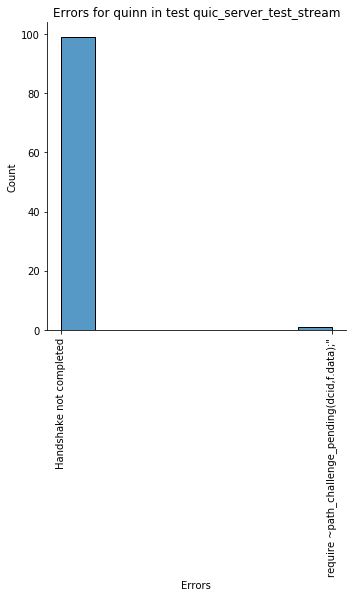

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_stream
mvfst
['Handshake not completed', 'No Error', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134']


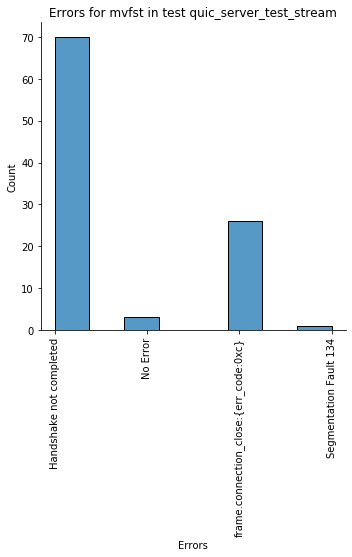

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_stream
picoquic
['No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed']


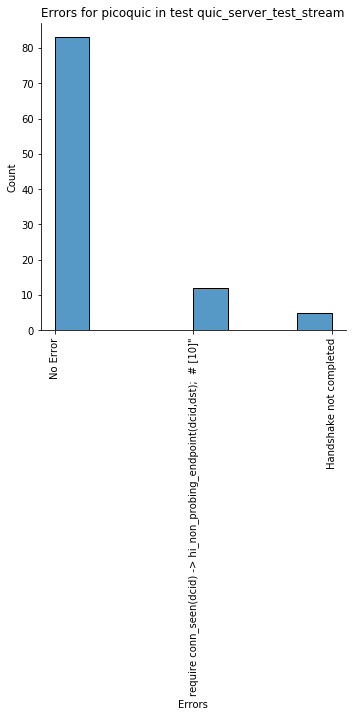

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_stream
quic-go
['Handshake not completed']


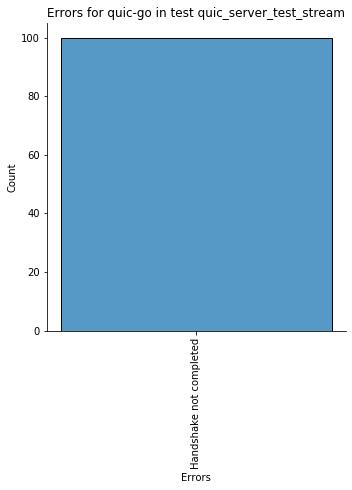

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_stream
aioquic
['frame.connection_close:{err_code:0xa}', 'No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


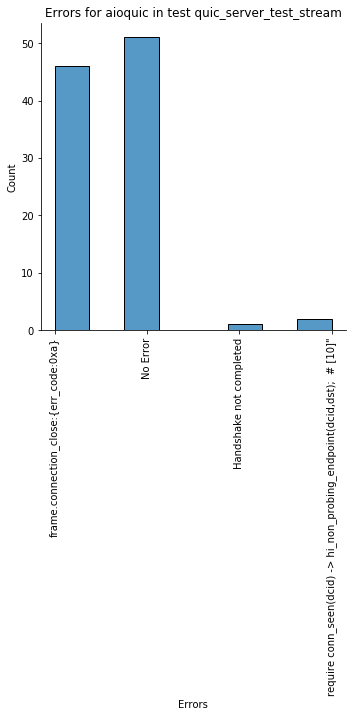

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_stream
quant
['Handshake not completed', 'Segmentation Fault 134']


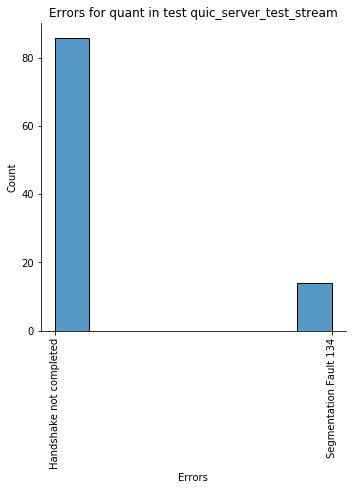

<Figure size 432x288 with 0 Axes>

quic_server_test_stream
lsquic
[]


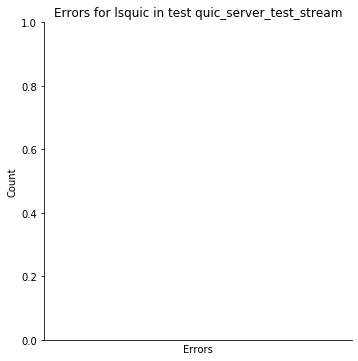

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_unkown
quinn
['No Error', 'Handshake not completed', 'require is_frame_encoding_error;"']


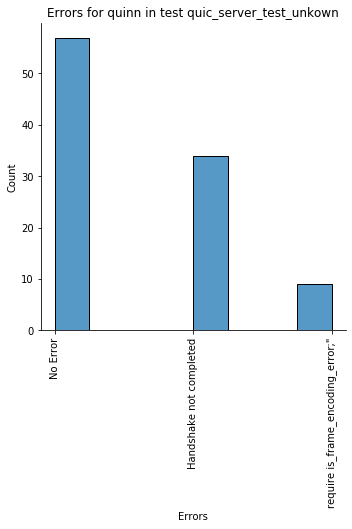

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_unkown
mvfst
['Segmentation Fault 139', 'No Error', 'Handshake not completed', 'require is_frame_encoding_error;"', 'frame.connection_close:{err_code:0x7}']


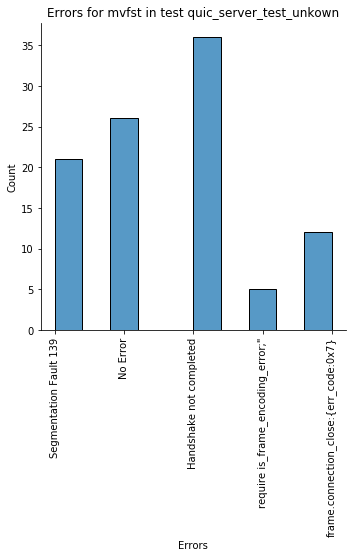

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_unkown
picoquic
['frame.connection_close:{err_code:0xa}', 'Handshake not completed', 'require is_frame_encoding_error;"']


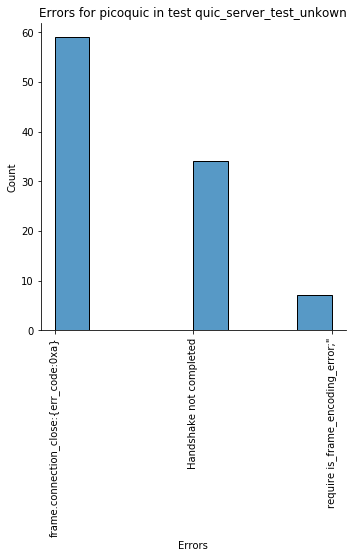

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_unkown
quic-go
['frame.connection_close:{err_code:0x7}', 'Handshake not completed', 'No Error', 'require is_frame_encoding_error;"']


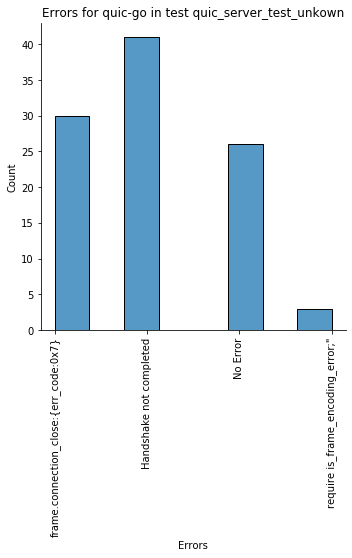

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_unkown
aioquic
['frame.connection_close:{err_code:0xa}', 'Handshake not completed', 'require is_frame_encoding_error;"']


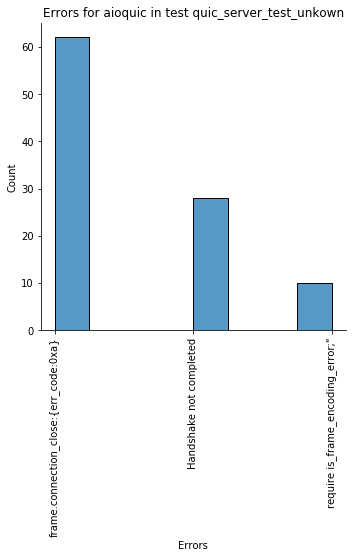

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_unkown
quant
['Handshake not completed', 'Segmentation Fault 134']


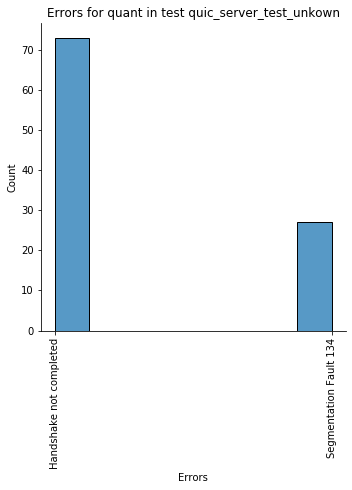

<Figure size 432x288 with 0 Axes>

quic_server_test_unkown
lsquic
[]


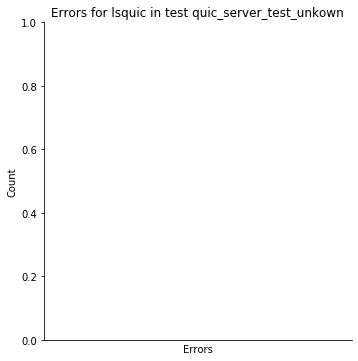

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_limit_newcoid
quinn
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"']


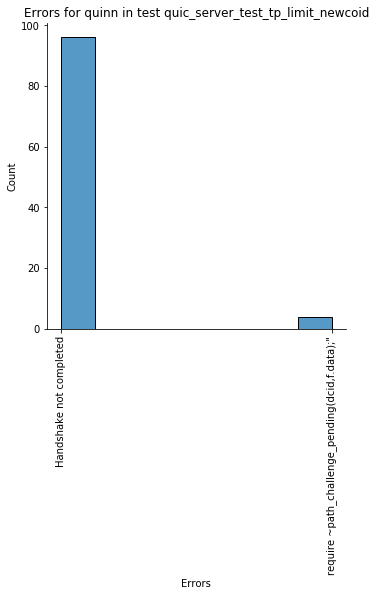

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_limit_newcoid
mvfst
['Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'No Error']


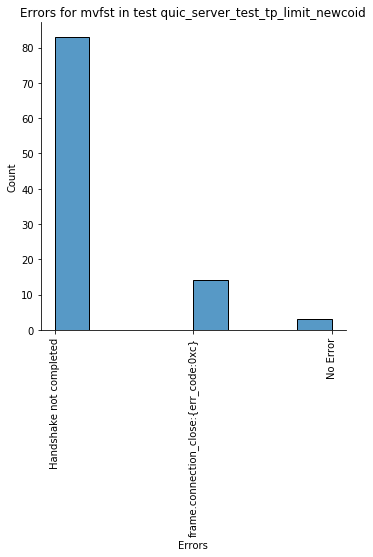

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_limit_newcoid
picoquic
['No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


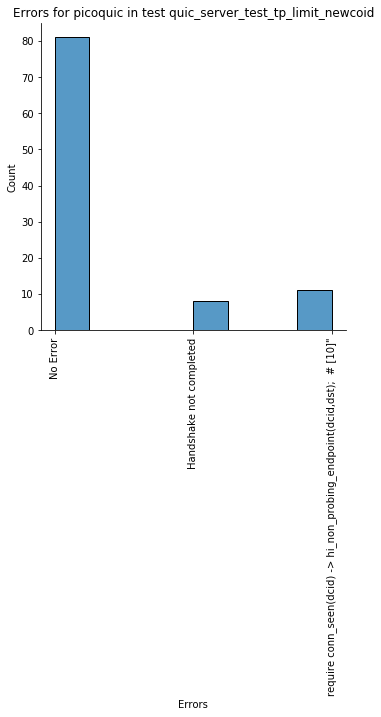

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_limit_newcoid
quic-go
['Handshake not completed']


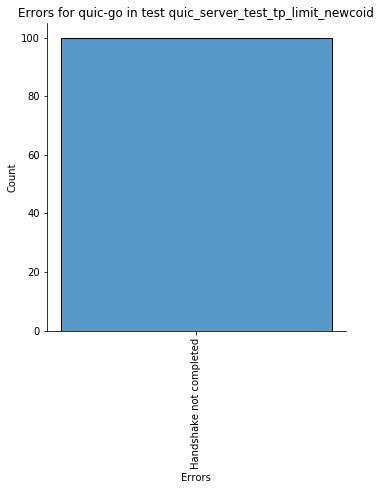

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_limit_newcoid
aioquic
['frame.connection_close:{err_code:0xa}', 'No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


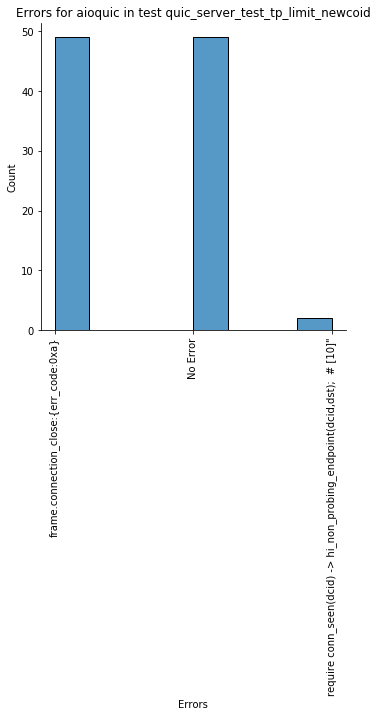

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_limit_newcoid
quant
['Handshake not completed', 'Segmentation Fault 134']


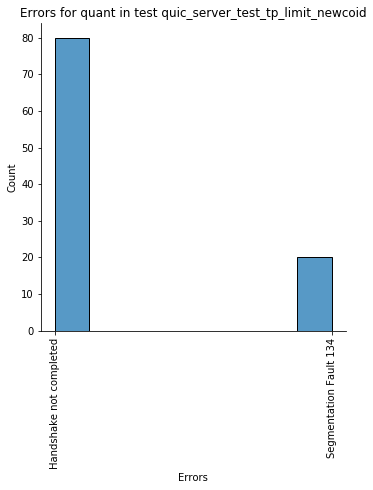

<Figure size 432x288 with 0 Axes>

quic_server_test_tp_limit_newcoid
lsquic
[]


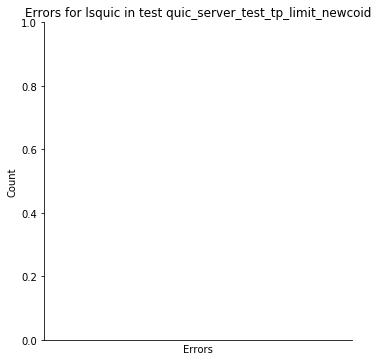

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_max
quinn
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"', 'require stream_id_allowed(dcid,f.id);  # [6]"']


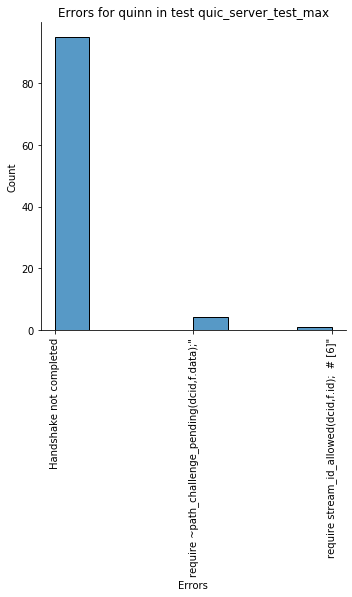

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_max
mvfst
['Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134']


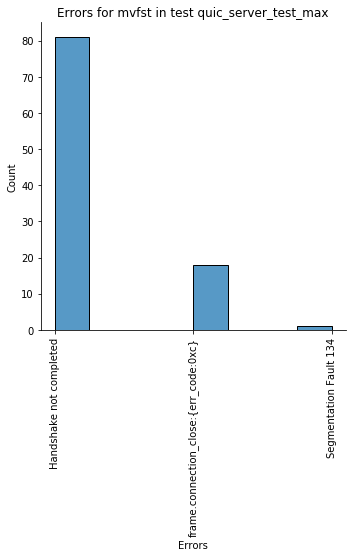

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_max
picoquic
['No Error', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed']


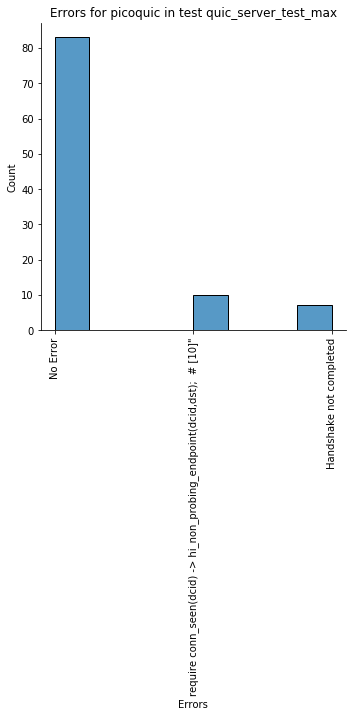

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_max
quic-go
['Handshake not completed']


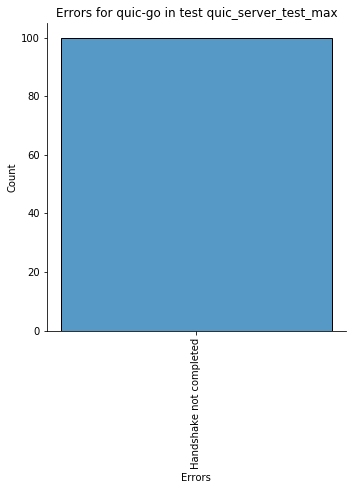

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_max
aioquic
['No Error', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


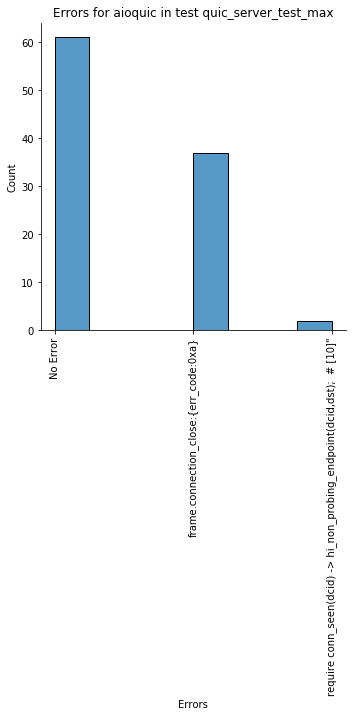

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_max
quant
['Segmentation Fault 134', 'Handshake not completed']


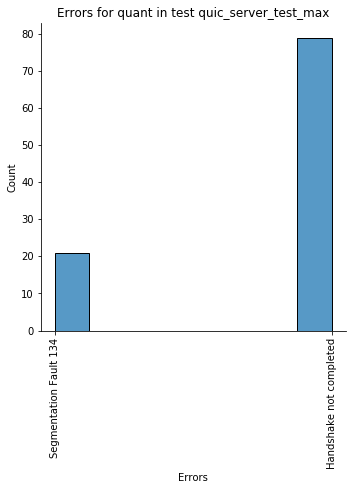

<Figure size 432x288 with 0 Axes>

quic_server_test_max
lsquic
[]


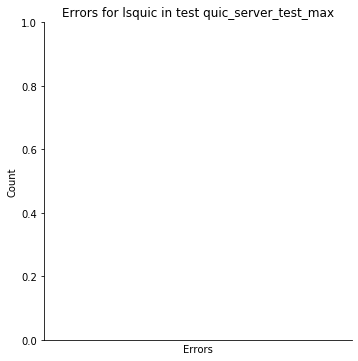

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_token_error
quinn
['Handshake not completed']


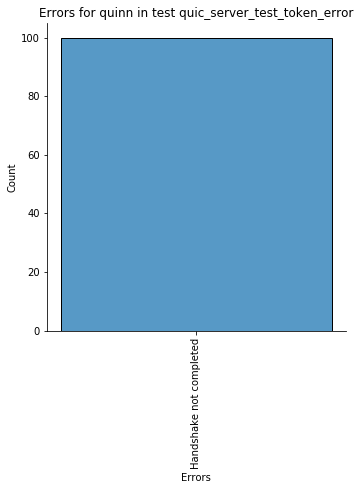

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_token_error
mvfst
['Handshake not completed']


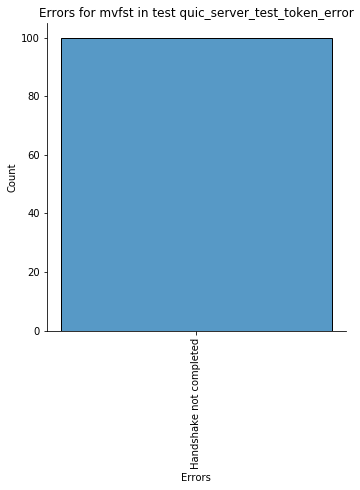

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_token_error
picoquic
['No Error']


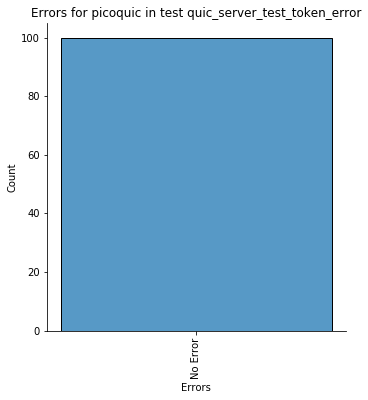

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_token_error
quic-go
['Handshake not completed']


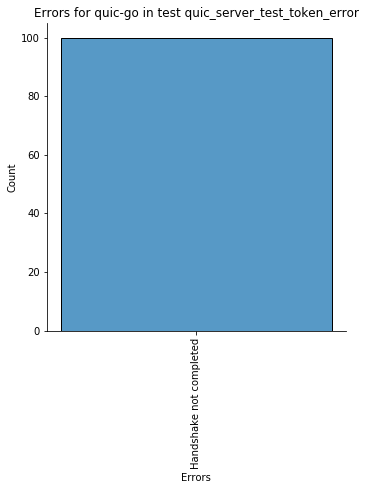

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_token_error
aioquic
['Handshake not completed']


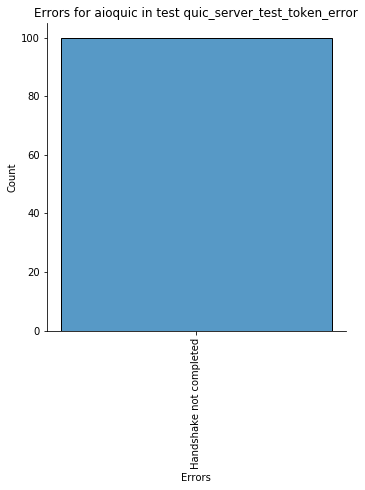

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_token_error
quant
['Handshake not completed']


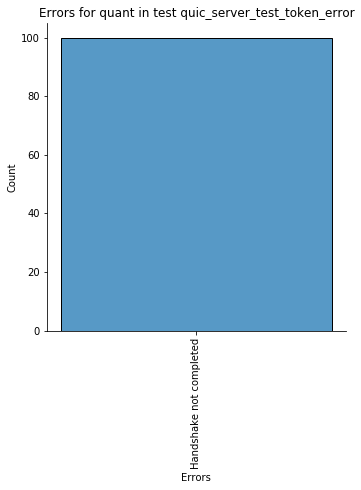

<Figure size 432x288 with 0 Axes>

quic_server_test_token_error
lsquic
[]


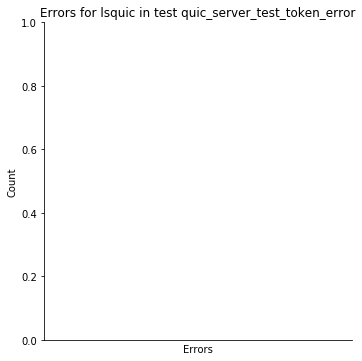

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_error
quinn
['No Error']


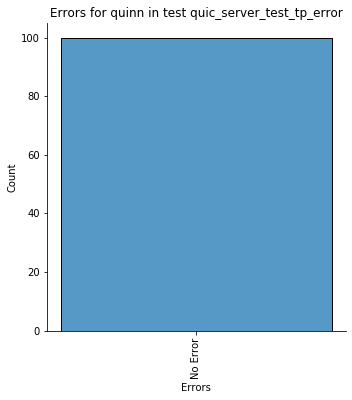

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_error
mvfst
['Handshake not completed', 'No Error', 'frame.connection_close:{err_code:0x8}']


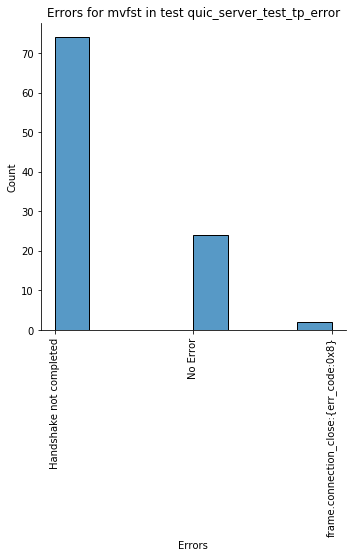

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_error
picoquic
['Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_transport_parameter_error;"']


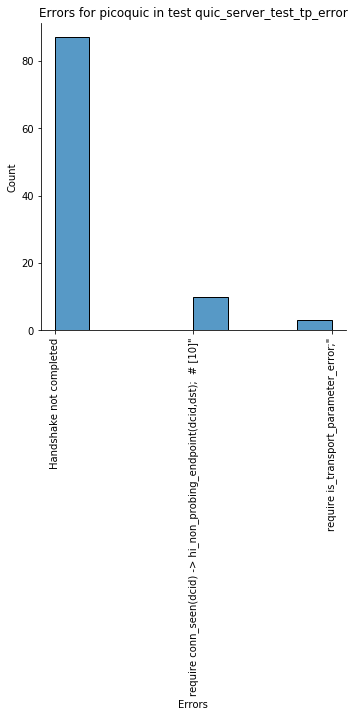

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_error
quic-go
['No Error']


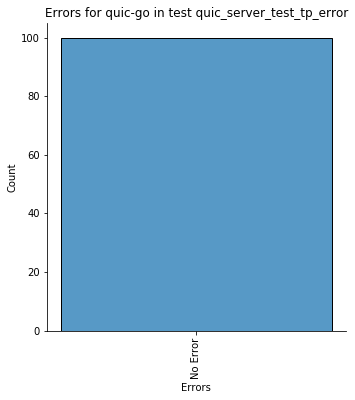

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_error
aioquic
['Handshake not completed', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


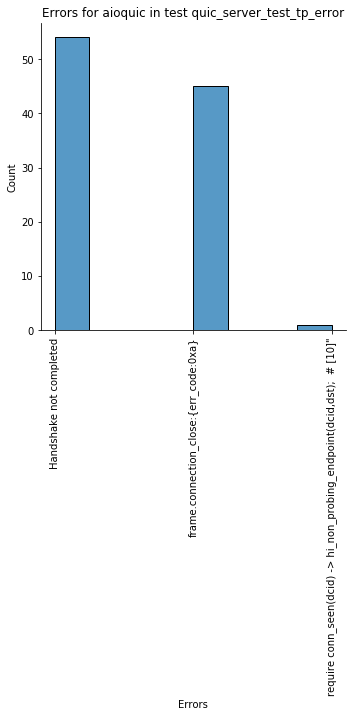

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_error
quant
['server_return_code(1)+timeout']


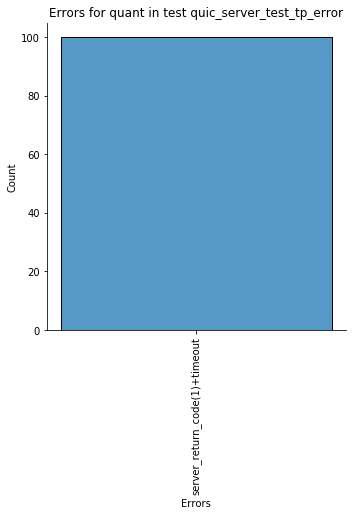

<Figure size 432x288 with 0 Axes>

quic_server_test_tp_error
lsquic
[]


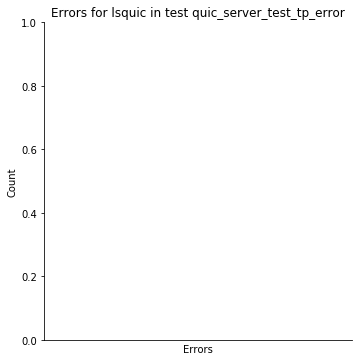

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_acticoid_error
quinn
['No Error']


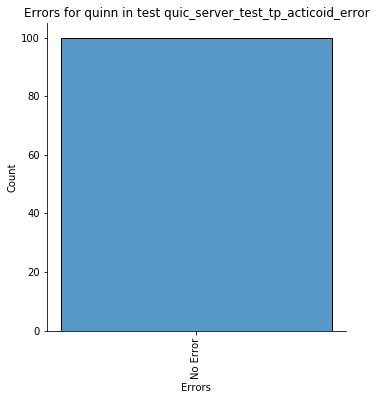

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_acticoid_error
mvfst
['Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134']


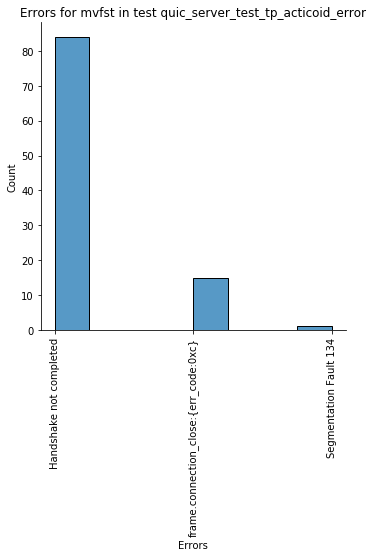

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_acticoid_error
picoquic
['Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'require is_transport_parameter_error;"']


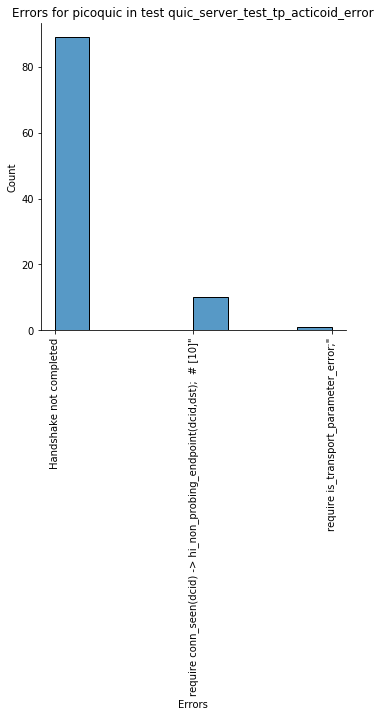

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_acticoid_error
quic-go
['Handshake not completed']


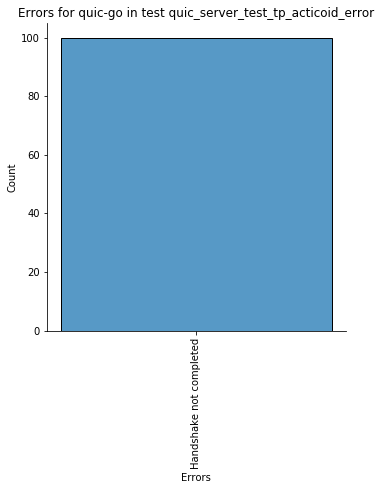

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_acticoid_error
aioquic
['Handshake not completed']


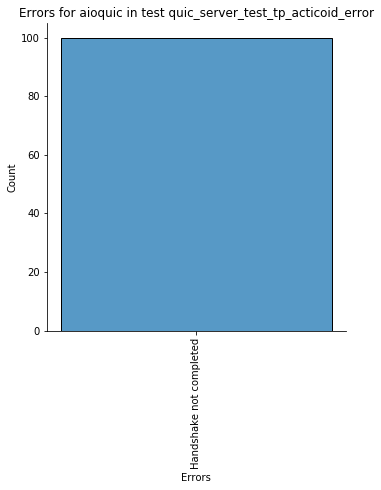

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_tp_acticoid_error
quant
['No Error']


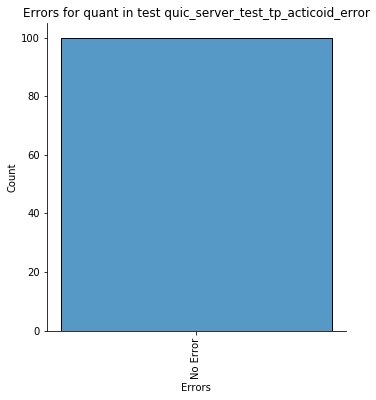

<Figure size 432x288 with 0 Axes>

quic_server_test_tp_acticoid_error
lsquic
[]


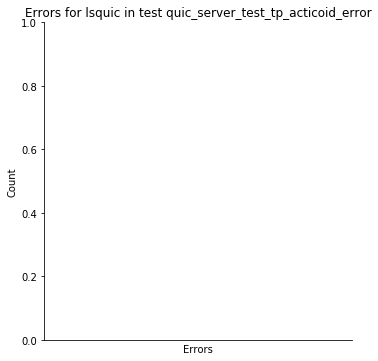

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
quinn
['Handshake not completed', 'require ~path_challenge_pending(dcid,f.data);"']


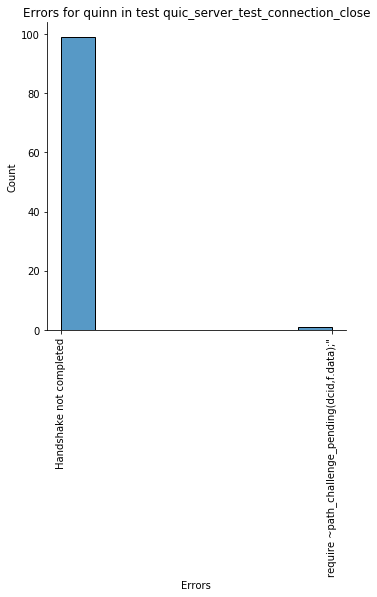

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
mvfst
['Handshake not completed', 'No Error', 'require is_no_error"']


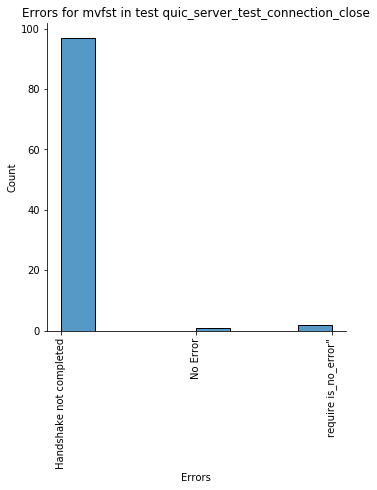

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
picoquic
['No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


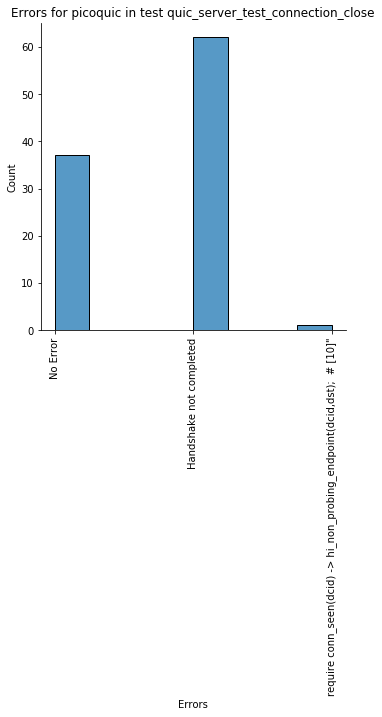

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
quic-go
['Handshake not completed']


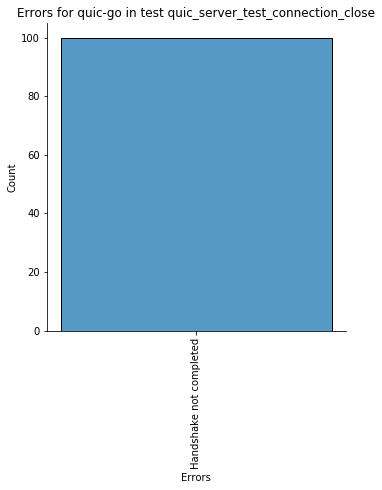

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
aioquic
['Handshake not completed', 'No Error', 'require is_no_error"', 'require conn_total_data(the_cid) > 0;"']


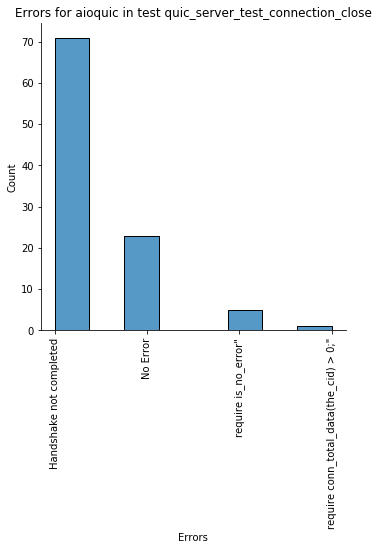

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_connection_close
quant
['Handshake not completed', 'Segmentation Fault 134']


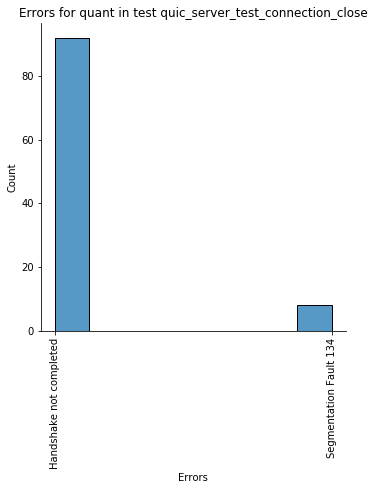

<Figure size 432x288 with 0 Axes>

quic_server_test_connection_close
lsquic
[]


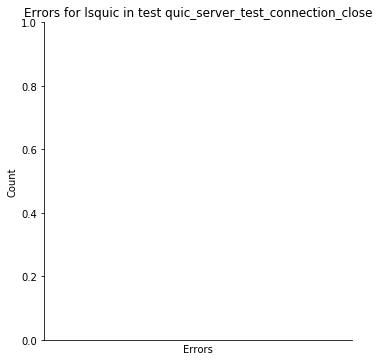

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_reset_stream
quinn
['require stream_id_allowed(dcid,f.id);  # [6]"', 'require ~path_challenge_pending(dcid,f.data);"', 'Handshake not completed']


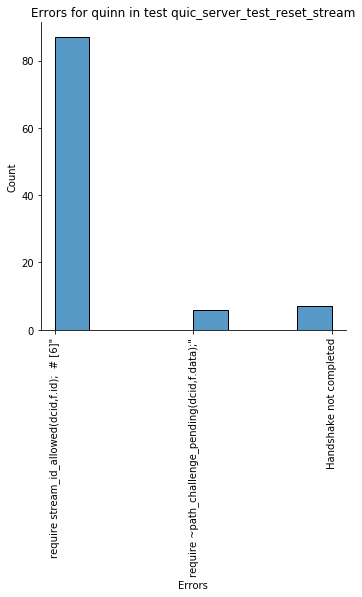

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_reset_stream
mvfst
['Handshake not completed', 'frame.connection_close:{err_code:0xc}', 'Segmentation Fault 134', 'No Error']


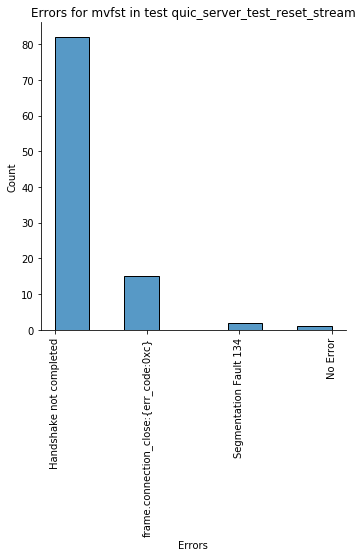

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_reset_stream
picoquic
['require stream_id_allowed(dcid,f.id);  # [4]"', 'No Error', 'Handshake not completed', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"']


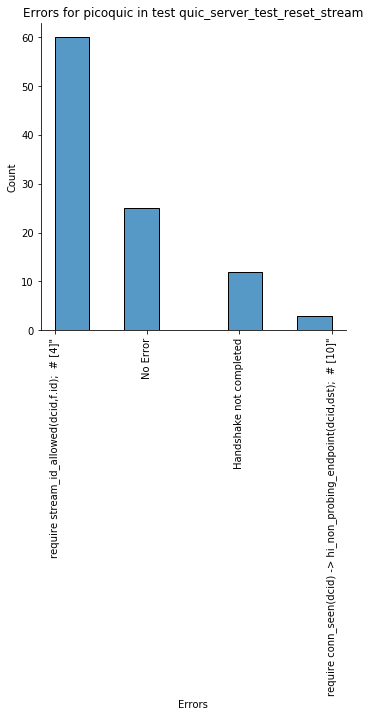

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_reset_stream
quic-go
['Handshake not completed']


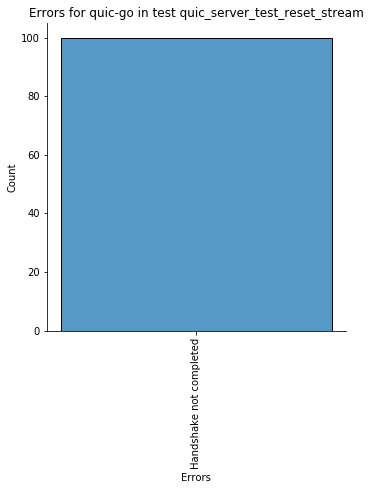

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_reset_stream
aioquic
['No Error', 'frame.connection_close:{err_code:0xa}', 'require conn_seen(dcid) -> hi_non_probing_endpoint(dcid,dst);  # [10]"', 'Handshake not completed']


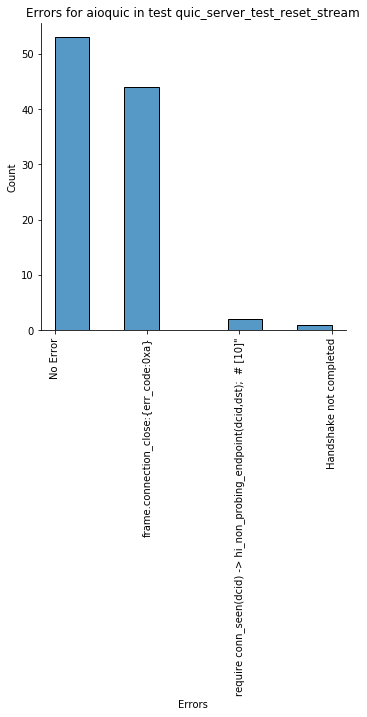

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_reset_stream
quant
['Handshake not completed', 'Segmentation Fault 134']


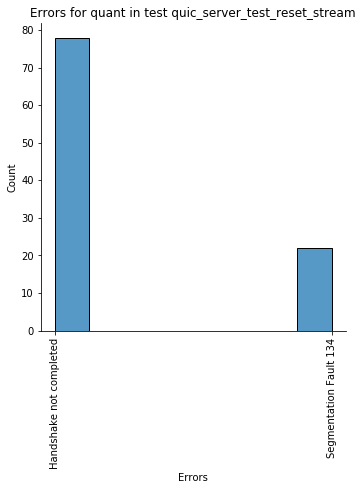

<Figure size 432x288 with 0 Axes>

quic_server_test_reset_stream
lsquic
[]


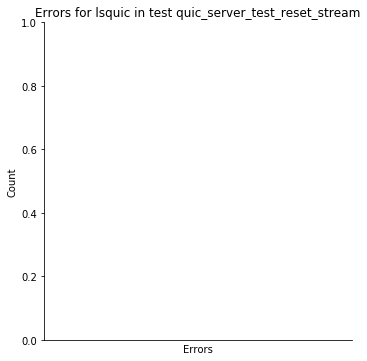

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
quinn
[]


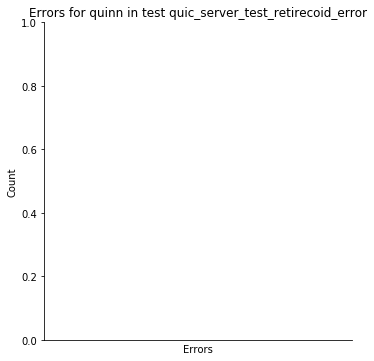

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
mvfst
[]


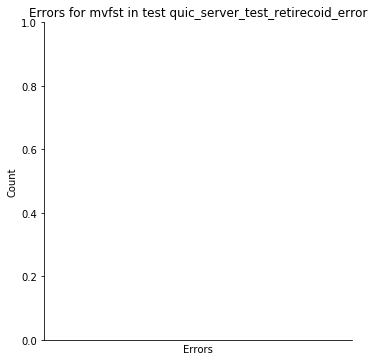

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
picoquic
[]


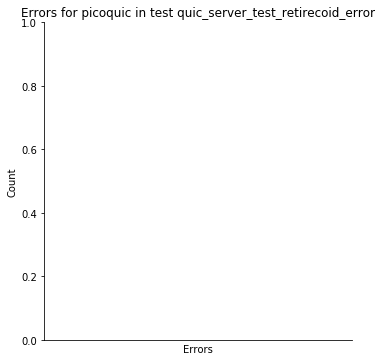

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
quic-go
[]


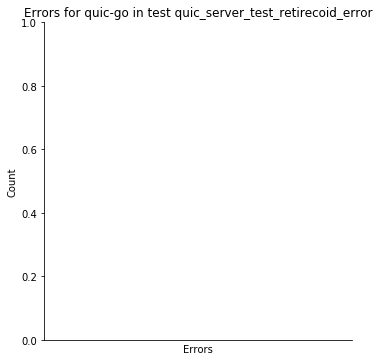

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
aioquic
[]


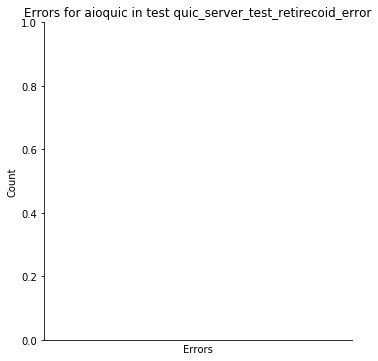

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
quant
[]


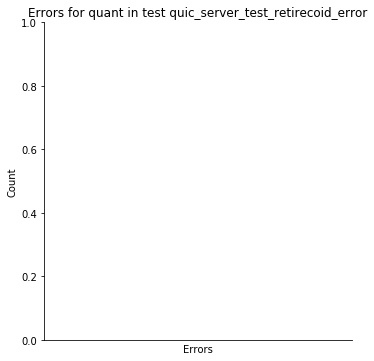

<Figure size 432x288 with 0 Axes>

quic_server_test_retirecoid_error
lsquic
[]


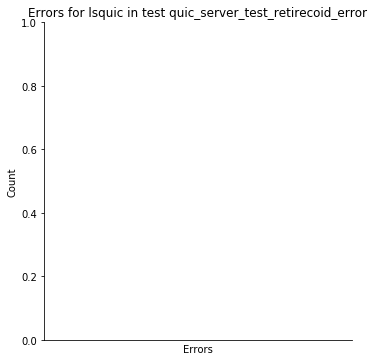

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
quinn
[]


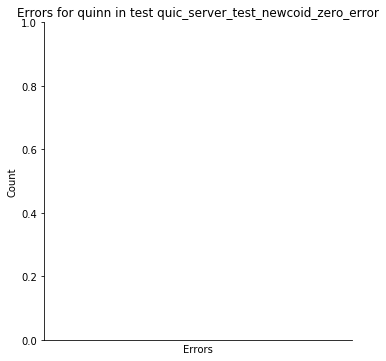

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
mvfst
[]


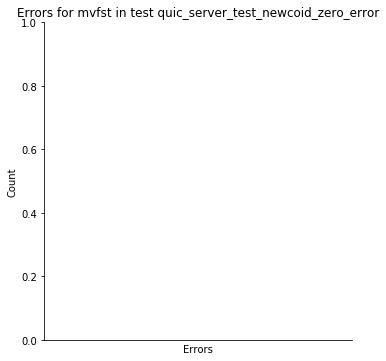

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
picoquic
[]


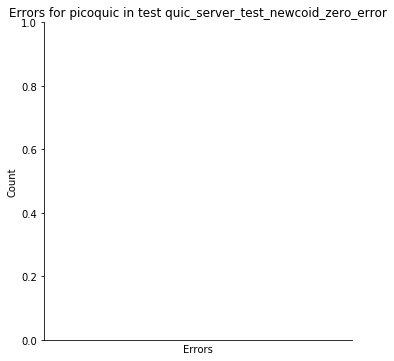

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
quic-go
[]


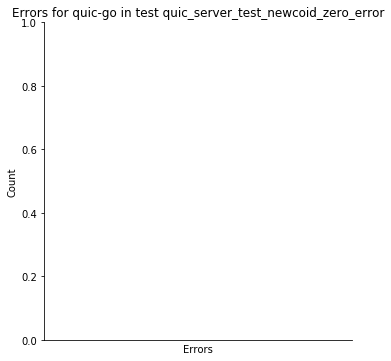

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
aioquic
[]


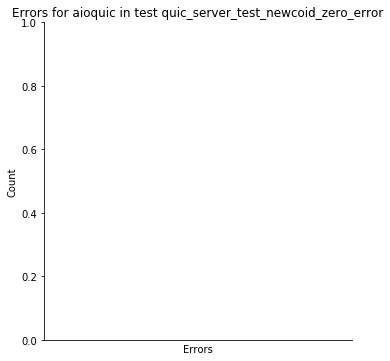

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
quant
[]


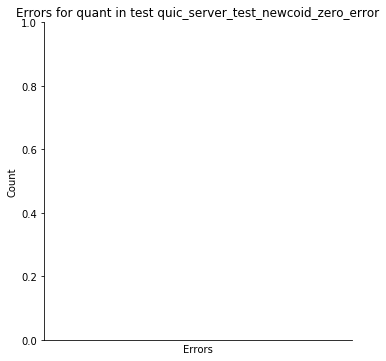

<Figure size 432x288 with 0 Axes>

quic_server_test_newcoid_zero_error
lsquic
[]


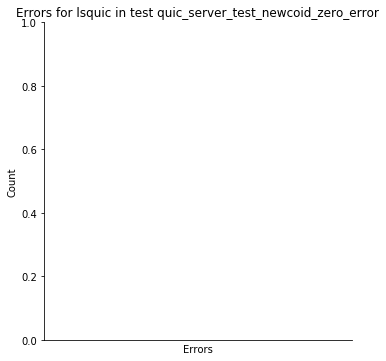

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_handshake_done_error
quinn
['No Error', 'require is_protocol_violation"', 'Handshake not completed']


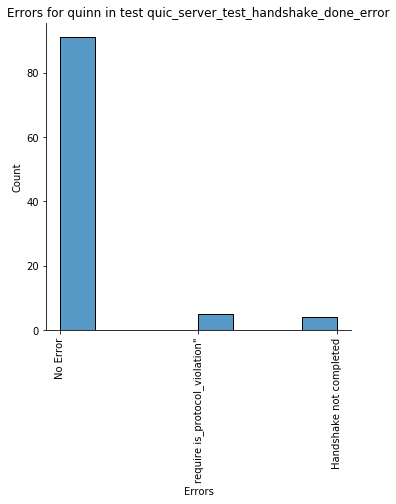

<Figure size 432x288 with 0 Axes>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


quic_server_test_handshake_done_error
mvfst
['Segmentation Fault 139', 'Handshake not completed', 'No Error', 'require is_protocol_violation"']


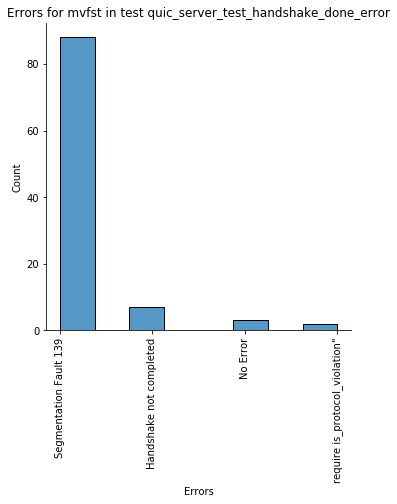

<Figure size 432x288 with 0 Axes>

In [ ]:
tests = ['quic_server_test_stream', 'quic_server_test_unkown',
       'quic_server_test_tp_limit_newcoid', 'quic_server_test_max',
       'quic_server_test_token_error', 'quic_server_test_tp_error',
       'quic_server_test_tp_acticoid_error',
       'quic_server_test_connection_close',
       'quic_server_test_reset_stream',
       'quic_server_test_retirecoid_error',
       'quic_server_test_newcoid_zero_error',
       'quic_server_test_handshake_done_error',
       'quic_server_test_stop_sending',
       'quic_server_test_double_tp_error',
       'quic_server_test_tp_limit_acticoid_error',
       'quic_server_test_accept_maxdata', 'quic_server_test_no_icid',
       'quic_server_test_ext_min_ack_delay']

# 'quant',
servers = ['quinn', 'mvfst', 'picoquic',  'quic-go', 'aioquic','quant','lsquic']
#plt.figure(figsize=[10,10])
#f,a = plt.subplots(2,2)
#a = a.ravel()

all_errors = train_df["ErrorIEV"].unique().tolist()
res = []
for i, row in train_df.iterrows():
    ind = all_errors.index(row["ErrorIEV"])
    res.append(ind)
train_df["ErrorsCode"] = res


for t in tests:
    subdf = train_df.loc[train_df['TestName'] == t]
    for s in servers:
        subsubdf = subdf.loc[subdf['Implementation'] == s]
        errors = subsubdf["ErrorIEV"].unique()
        
        all_errors = subsubdf["ErrorIEV"].unique().tolist()
        res = []
        for i, row in subsubdf.iterrows():
            ind = all_errors.index(row["ErrorIEV"])
            res.append(ind)
        subsubdf["ErrorsCode"] = res
        
        print(t)
        print(s)
        print(all_errors)
        
                
        # seaborn histogram
        sns.displot(x=subsubdf['ErrorsCode'],  kde=False ) #,hue="Implementation"
        # Add labels
        plt.title("Errors for " + s + " in test " + t)
        plt.xticks(np.arange(0,len(all_errors)), rotation=90)  #'vertical'
        positions = tuple(np.arange(0, len(all_errors)))
        labels =  tuple(errors.tolist())
        plt.xticks(positions, labels)
        plt.xlabel('Errors')
        plt.ylabel('Count')
        filename = 'plot/' + "errors_for_" + s + "_in_test_" + t + '.png'
        fig = plt.figure()
        plt.show()
        fig.savefig(filename, dpi=fig.dpi)
